# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

0. Prepare the data (cleaning, formatting)
1. Visualize to identify patterns

    1a. split and transform the data split again
	Then just plot differencing, and say auto arima would probably use first differencing
2. Use automated algorithm 
Specify a model (using autoarima)
3. Check residuals  by plotting ACF of the residential and doing Portmanteau test > Ljung–Box Test: A refined version introduced in 1978 that adjusts for sample size and is more accurate
4. Do residuals look like white noise? If no plot ACF and check other candidate models.
Otherwise 
5. Generate forecasts
6. continue with specified  model and  add lagged features
	For lagged features check BIC+


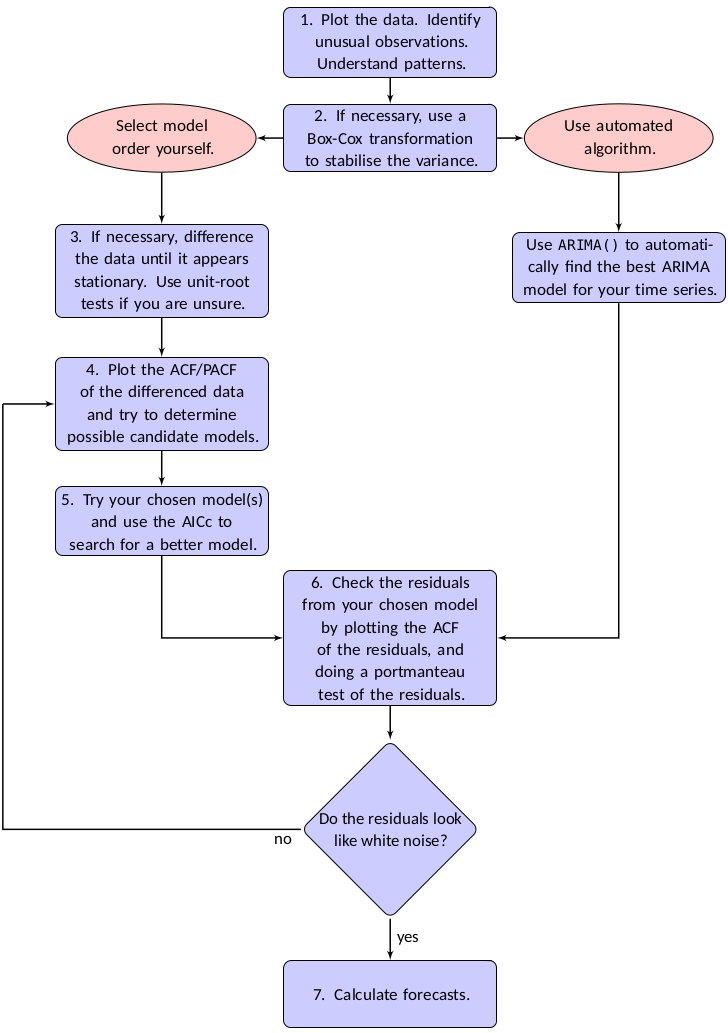



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Split/ Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

In [3]:
# import os

# # Make a local folder for figures
# output_dir = "figures"  # you can change this
# os.makedirs(output_dir, exist_ok=True)

# def plot_series(df, col, xlabel="Date", ylabel=None, title=None, basename=None):
#     x = df[time_col]
#     y = df[col]

#     fig, ax = plt.subplots()
#     ax.plot(x, y)
#     ax.grid(True, alpha=0.35)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel if ylabel else col)
#     ax.set_title(title if title else col)

#     if np.issubdtype(np.array(x).dtype, np.datetime64) or np.issubdtype(pd.Series(x).dtype, np.datetime64):
#         fig.autofmt_xdate()

#     base = basename if basename else col.replace(" ", "_").replace("/", "_").replace("%", "pct")
#     png_path = os.path.join(output_dir, f"{base}.png")
#     pdf_path = os.path.join(output_dir, f"{base}.pdf")
#     fig.savefig(png_path, bbox_inches="tight")
#     fig.savefig(pdf_path, bbox_inches="tight")
#     plt.close(fig)
#     return png_path, pdf_path

# # Plot the time series data
# time_col = "Time Period (T)"
# for col in df.columns:

#     if col != time_col:
#         plot_series(df, col, xlabel="Date", ylabel=col, title=f"Time Series of {col}", basename=col)    
#         print(f"Plotted {col} time series.")
        

In [4]:

# # === PLOT FUNCTION ===
# def plot_series(df, col, xlabel="Date", ylabel=None, title=None, basename=None):
#     x = df[time_col]
#     y = df[col]

#     fig, ax = plt.subplots()
#     ax.plot(x, y, color="black")
#     ax.grid(True, alpha=0.4)
#     ax.set_xlabel(xlabel, fontweight="bold")
#     ax.set_ylabel(ylabel if ylabel else col, fontweight="bold")
#     ax.set_title(title if title else col, fontweight="bold")

#     if np.issubdtype(pd.Series(x).dtype, np.datetime64):
#         fig.autofmt_xdate()

#     base = basename if basename else col.replace(" ", "_").replace("/", "_").replace("%", "pct")
#     png_path = os.path.join(output_dir, f"{base}.png")
#     pdf_path = os.path.join(output_dir, f"{base}.pdf")
#     fig.savefig(png_path, bbox_inches="tight")
#     fig.savefig(pdf_path, bbox_inches="tight")
#     plt.close(fig)

#     print(f"Saved: {png_path}, {pdf_path}")

# # === GENERATE ALL PLOTS ===
# for col in features:
#     plot_series(df, col, ylabel=col, title=col)

# plot_series(df, target, ylabel=target, title=target)

Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


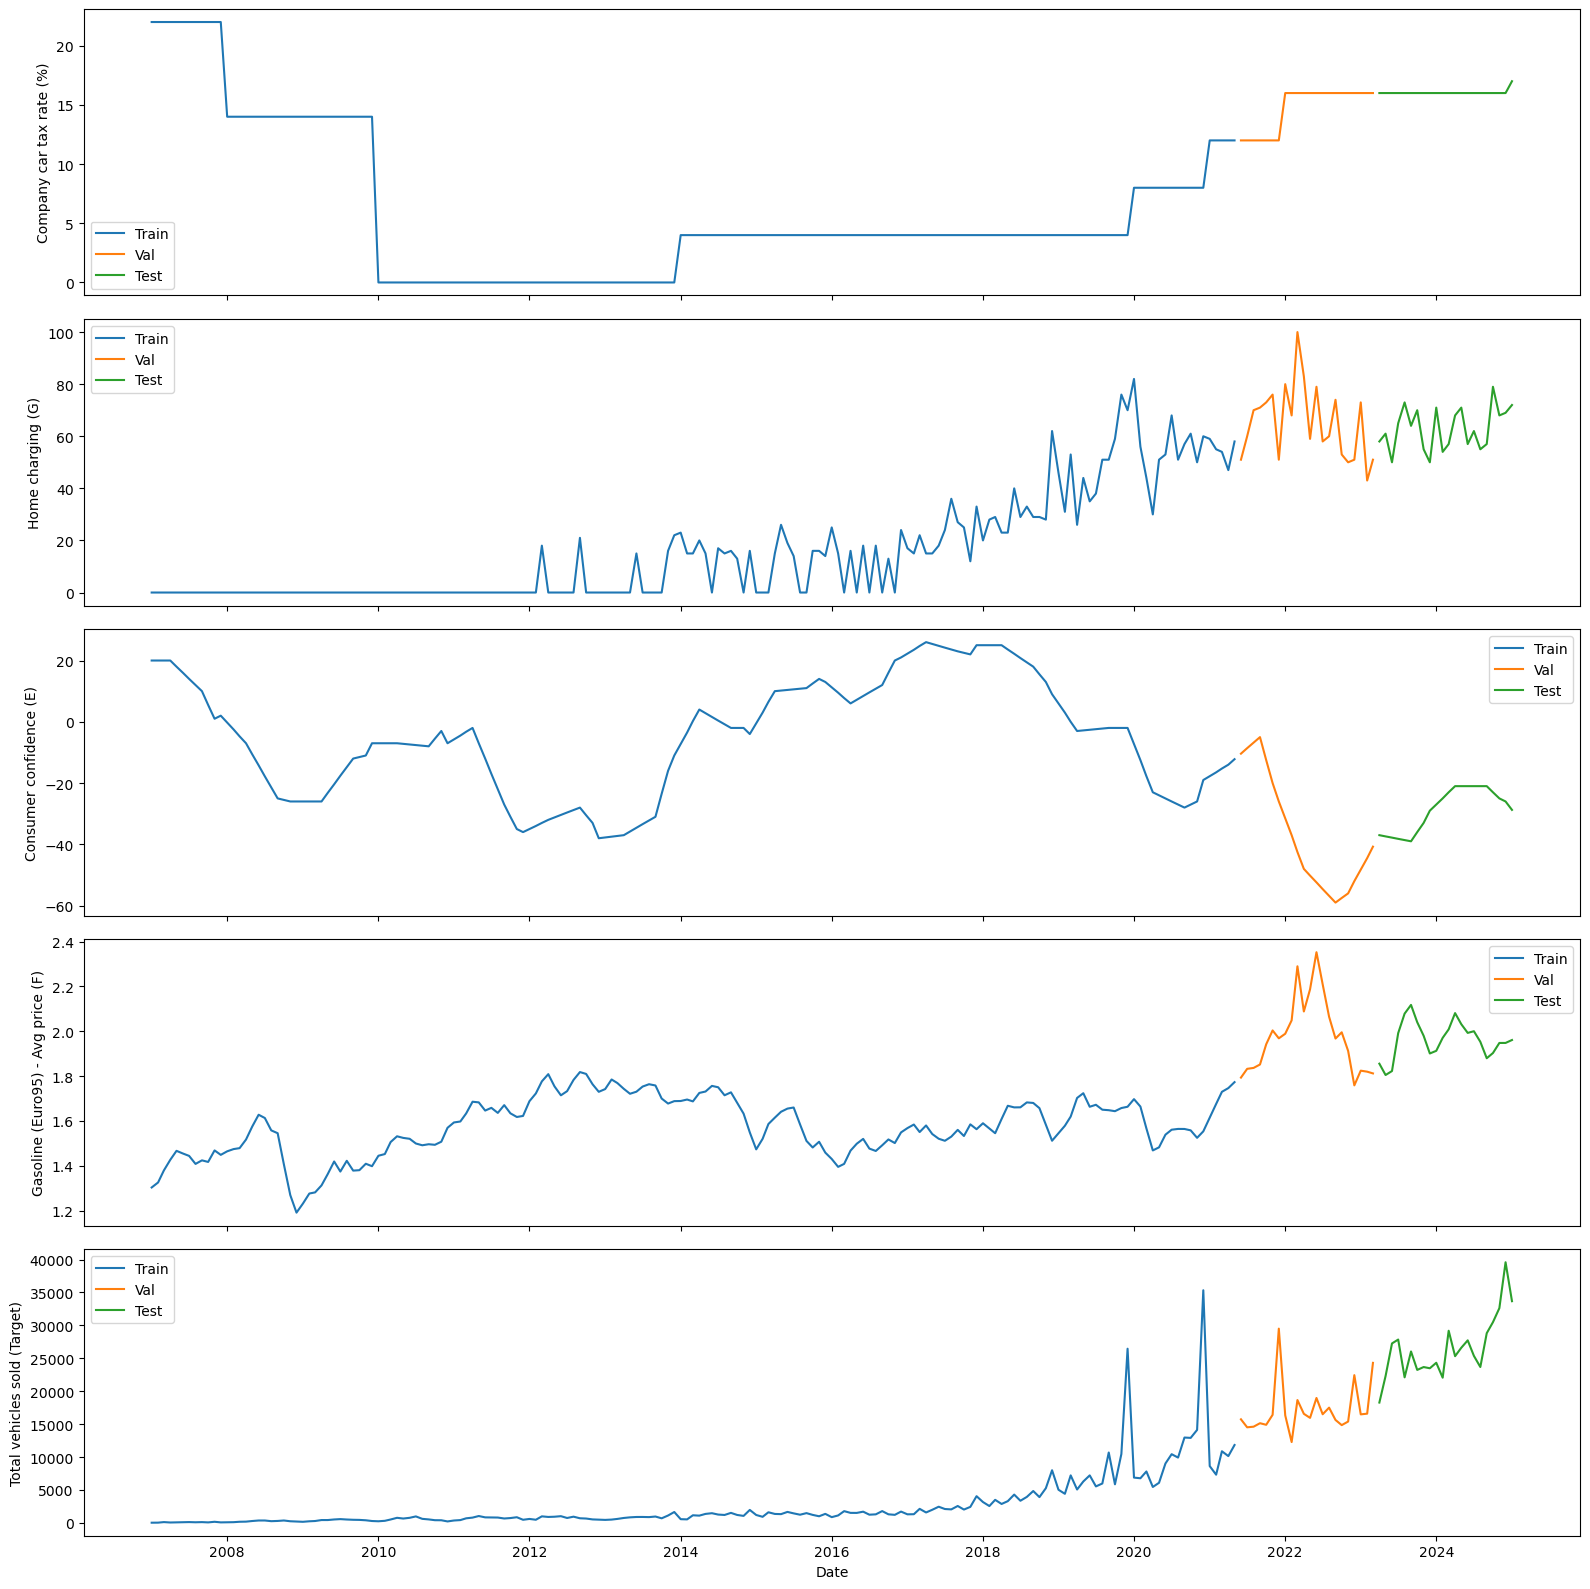

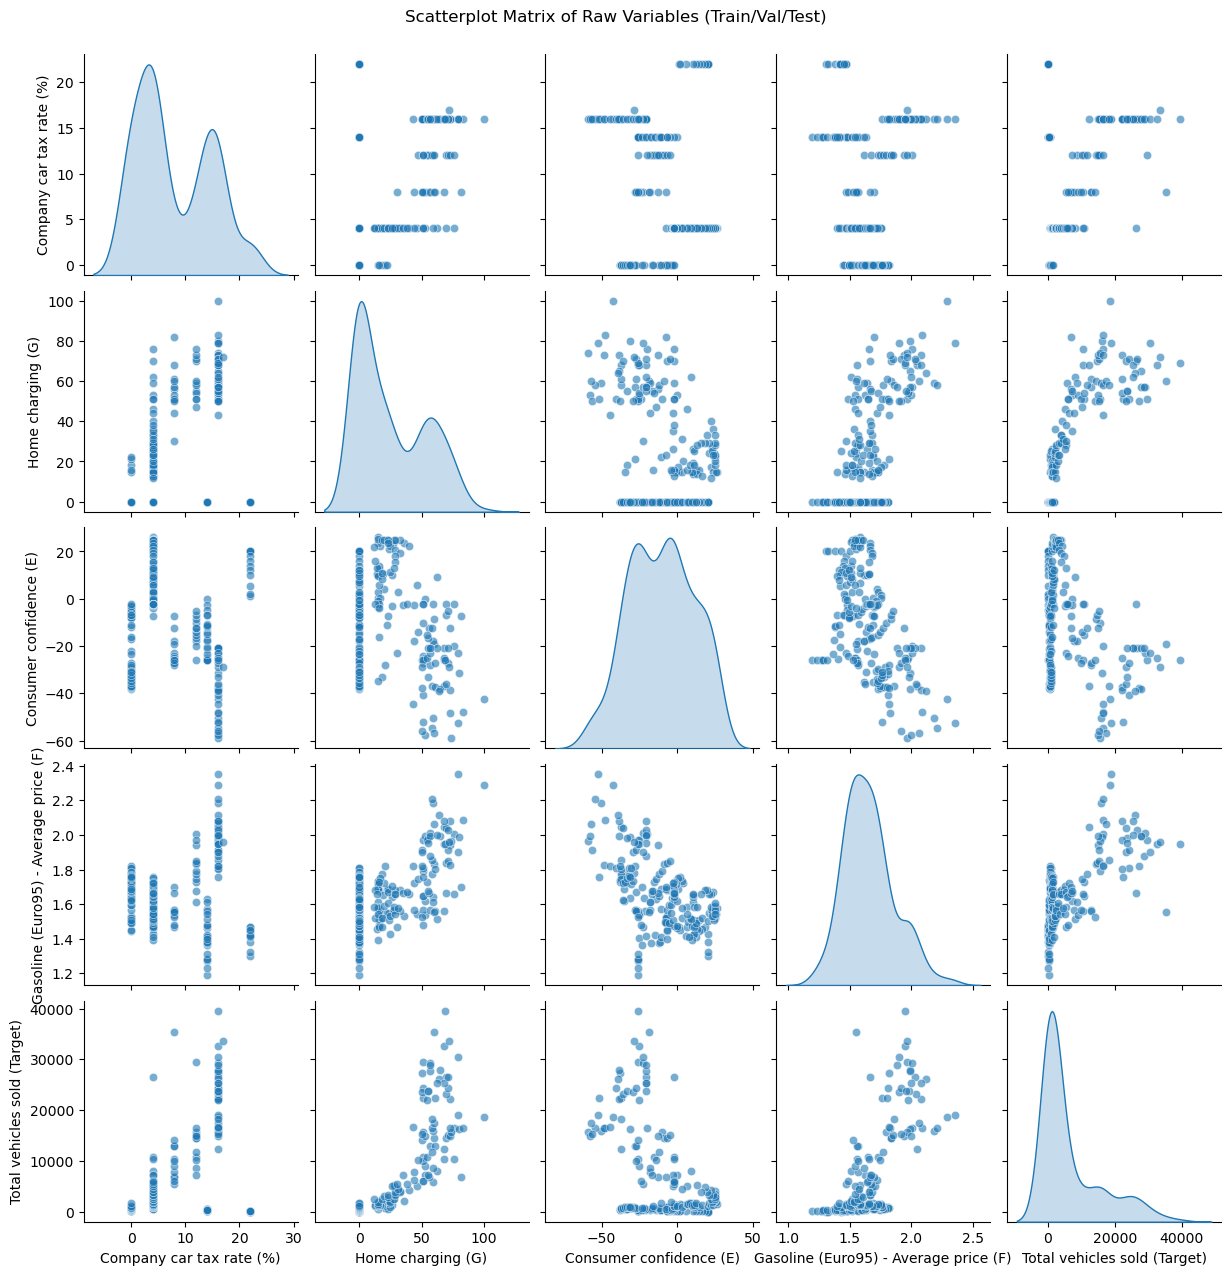

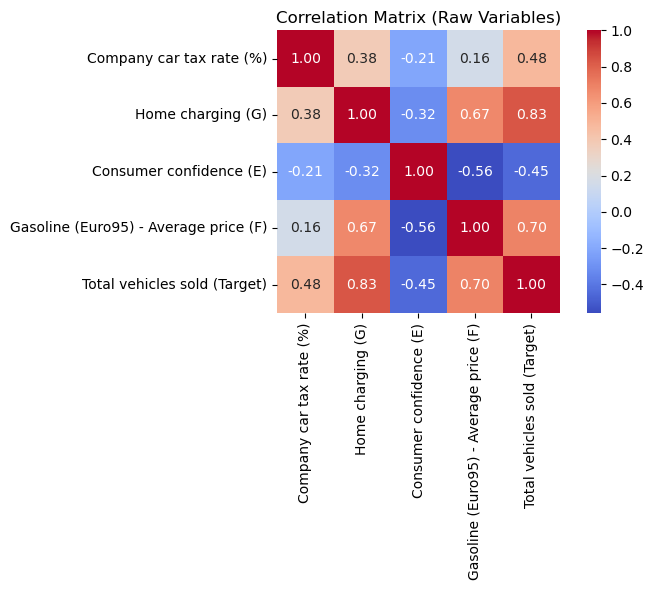

In [5]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")

import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()






## Observations first plots 

> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4.  Transformation & split

## 4a Apply train/val/test split

> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson and boxcox  transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

BC Train: 173 rows | 79.7% of data
BC Val:   22 rows | 10.1% of data
BC Test:  22 rows | 10.1% of data
Company car tax rate (%)_bc               λ = 0.2205  shift = 0.0001
Home charging (G)_bc                      λ = -0.0268  shift = 0.0001
Consumer confidence (E)_yj                λ = 1.0165  shift = 0
Gasoline (Euro95) - Average price (F)_bc  λ = 2.7450  shift = 0
Total vehicles sold (Target)_bc           λ = -0.0017  shift = 0


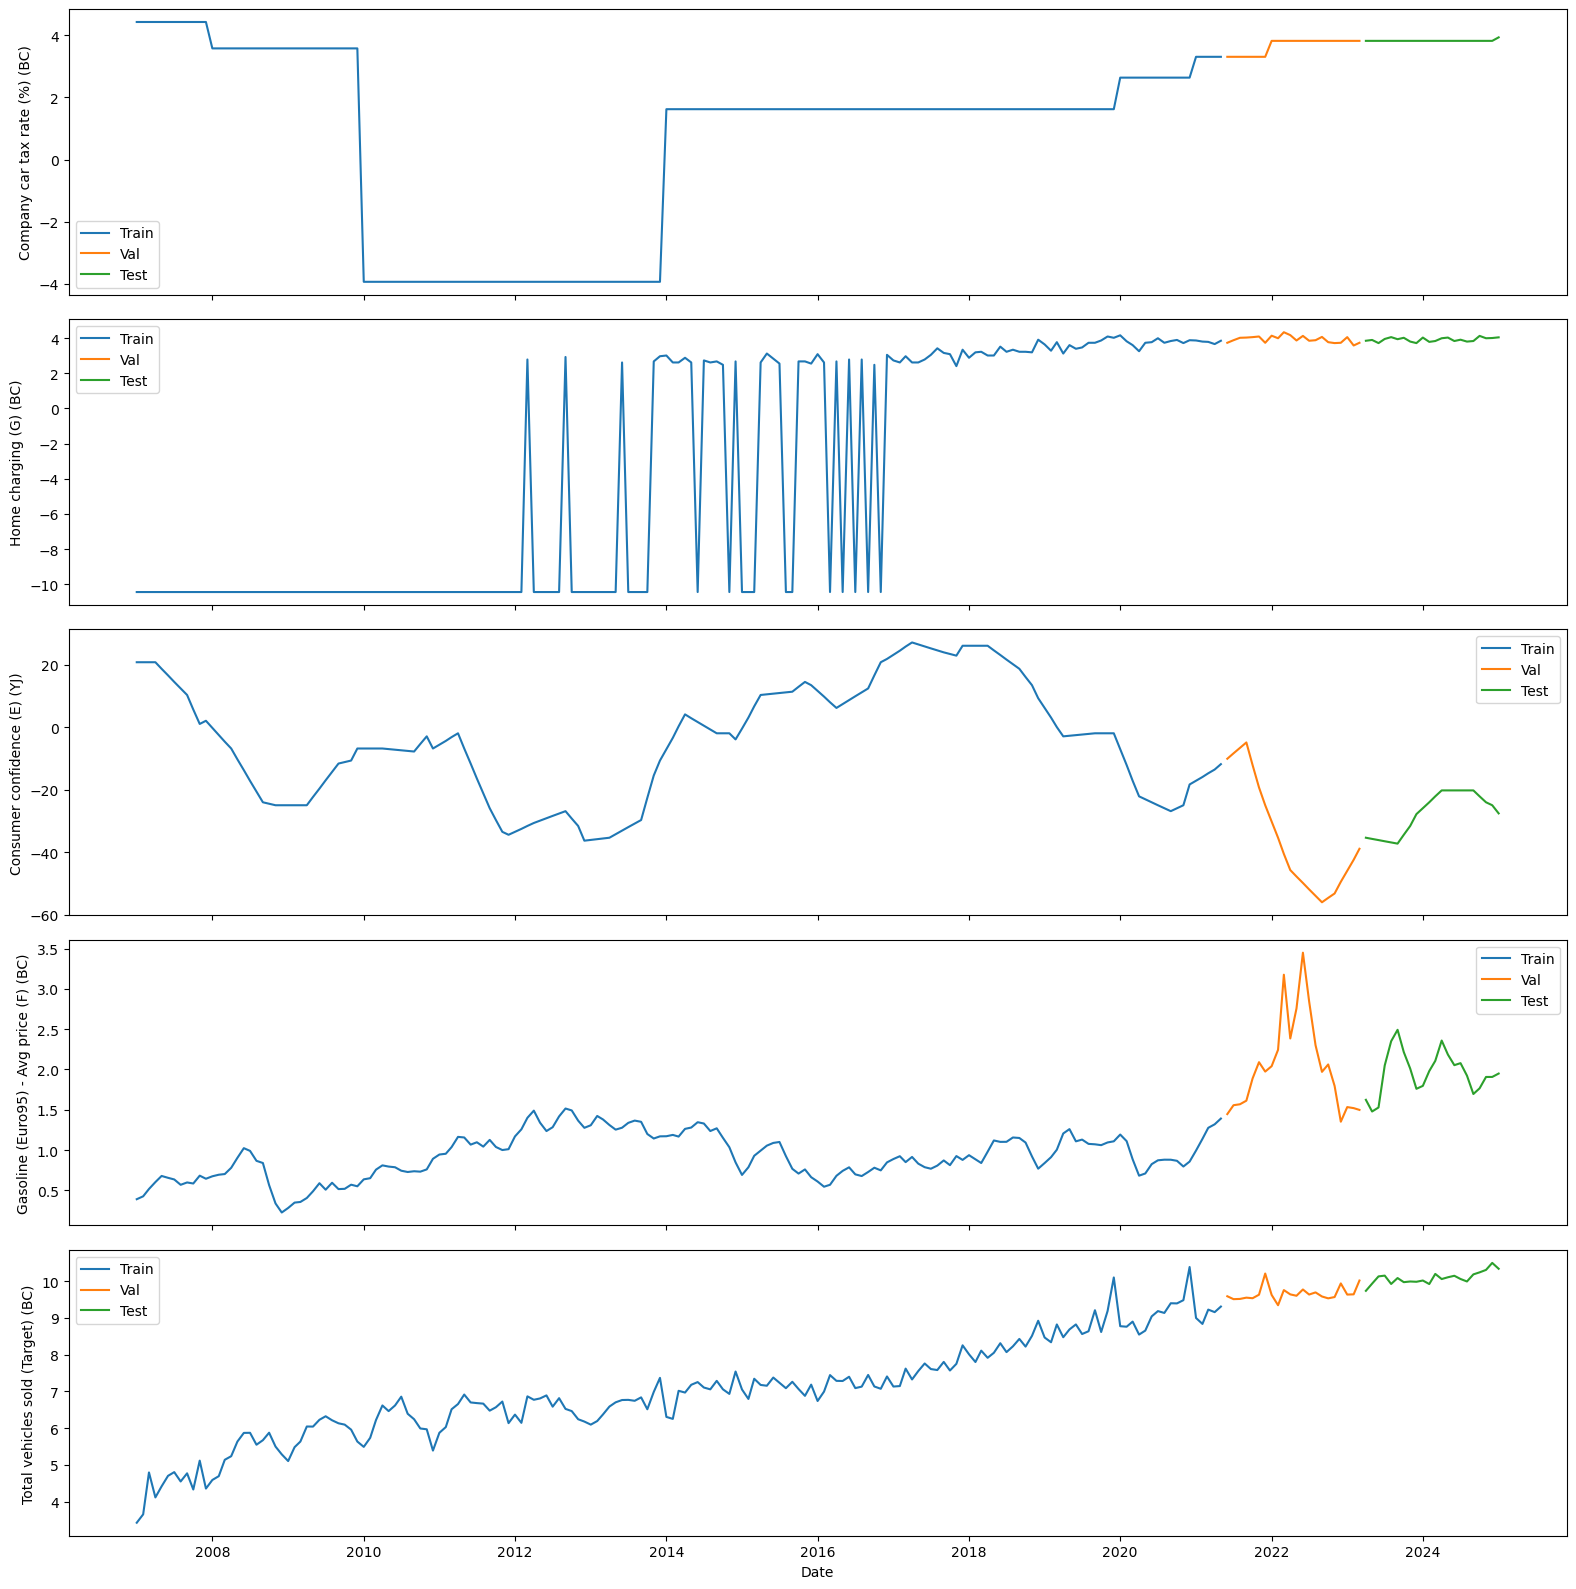

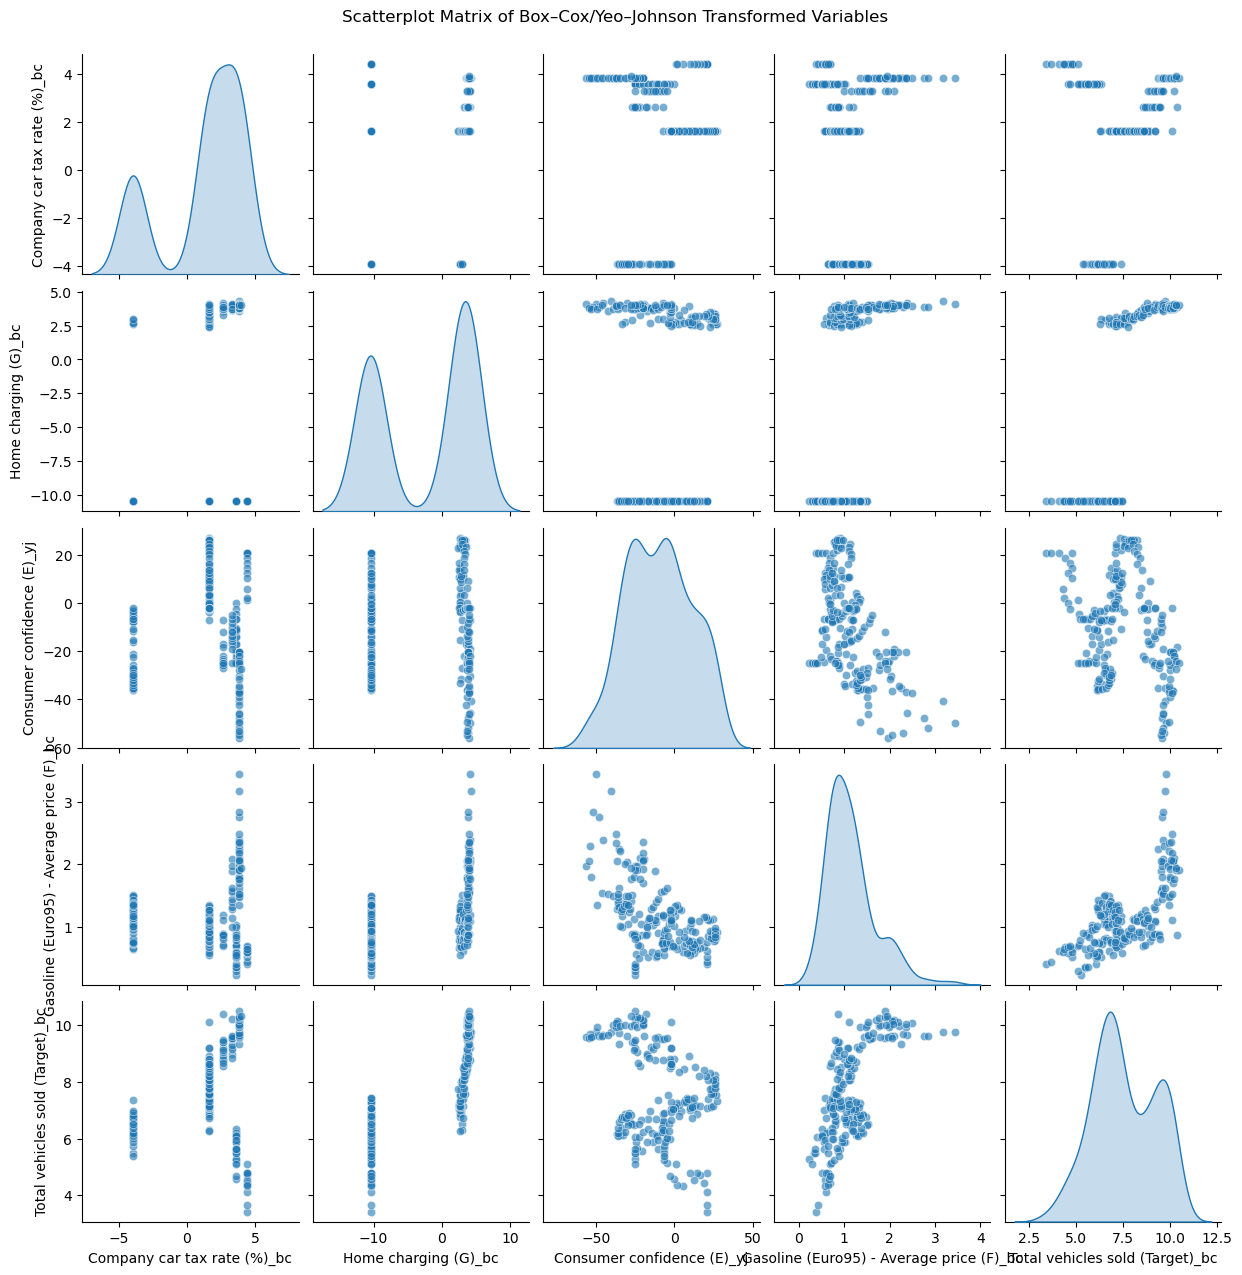

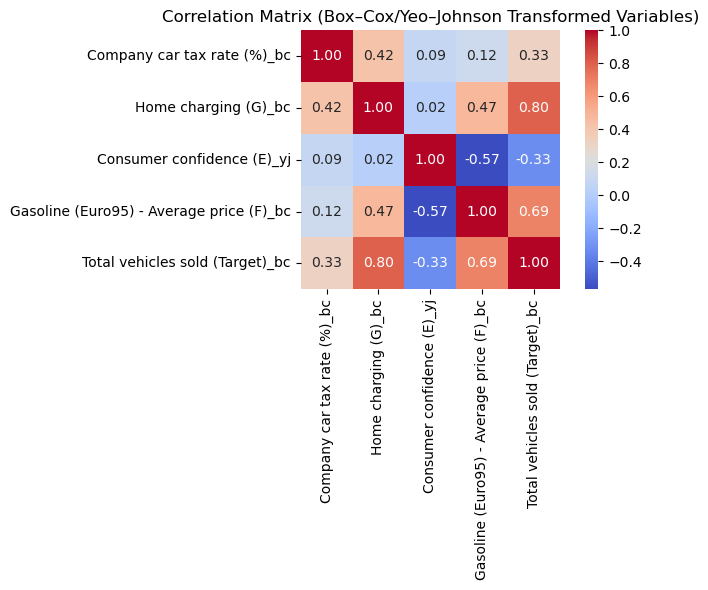

In [6]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
import pandas as pd

features_bc = features_raw.copy()
target_bc = target_raw

boxcox_all = {}
boxcox_lambdas_all = {}
boxcox_shifts_all = {}

for col in features_bc + [target_bc]:
    # Skip Consumer Confidence (use Yeo–Johnson later)
    if "consumer confidence" in col.lower():
        continue

    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)

    # Box–Cox requires strictly positive values: add shift if needed (on train only)
    min_train = train_series.min()
    shift = 0
    if min_train <= 0:
        shift = abs(min_train) + 1e-4  # Small buffer above zero
        train_series_shifted = train_series + shift
    else:
        train_series_shifted = train_series

    pt = PowerTransformer(method='box-cox', standardize=False)
    pt.fit(train_series_shifted)
    boxcox_lambdas_all[col] = pt.lambdas_[0]
    boxcox_shifts_all[col] = shift

    # Apply same shift to full data
    full_series = df[col].values.reshape(-1, 1)
    if shift != 0:
        full_series_shifted = full_series + shift
    else:
        full_series_shifted = full_series

    boxcox_all[col] = pt.transform(full_series_shifted).flatten()

# Now transform Consumer Confidence (Yeo–Johnson)
conf_col = [col for col in features_bc + [target_bc] if "consumer confidence" in col.lower()][0]
train_conf = df[conf_col].iloc[:train_end].values.reshape(-1, 1)
pt_conf = PowerTransformer(method='yeo-johnson', standardize=False)
pt_conf.fit(train_conf)
boxcox_lambdas_all[conf_col] = pt_conf.lambdas_[0]
boxcox_shifts_all[conf_col] = 0
full_conf = df[conf_col].values.reshape(-1, 1)
boxcox_all[conf_col] = pt_conf.transform(full_conf).flatten()

# 2. Build transformed DataFrame with _bc suffix (except conf, which gets _yj)
rename_map = {col: (f"{col}_yj" if "consumer confidence" in col.lower() else f"{col}_bc")
              for col in features_bc + [target_bc]}

bc_df = pd.DataFrame({
    rename_map[col]: boxcox_all[col]
    for col in features_bc + [target_bc]
})

features_bc = [rename_map[col] for col in features_bc]
target_bc   = rename_map[target_bc]

# 3. Define split indices for Box–Cox (same logic as raw)
n_bc         = len(bc_df)
train_end_bc = int(n_bc * 0.8)
val_end_bc   = int(n_bc * 0.9)
test_end_bc  = n_bc

# 4. Split Box–Cox–transformed data
y_train_bc = bc_df[target_bc].iloc[:train_end_bc]
y_val_bc   = bc_df[target_bc].iloc[train_end_bc:val_end_bc]
y_test_bc  = bc_df[target_bc].iloc[val_end_bc:]

companytax_train_bc = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[:train_end_bc]
companytax_val_bc   = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[train_end_bc:val_end_bc]
companytax_test_bc  = bc_df[[c for c in bc_df.columns if "Company car tax rate" in c][0]].iloc[val_end_bc:]

homechg_train_bc = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[:train_end_bc]
homechg_val_bc   = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[train_end_bc:val_end_bc]
homechg_test_bc  = bc_df[[c for c in bc_df.columns if "Home charging" in c][0]].iloc[val_end_bc:]

conf_train_yj = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[:train_end_bc]
conf_val_yj   = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[train_end_bc:val_end_bc]
conf_test_yj  = bc_df[[c for c in bc_df.columns if "consumer confidence" in c.lower()][0]].iloc[val_end_bc:]

gas_train_bc = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[:train_end_bc]
gas_val_bc   = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[train_end_bc:val_end_bc]
gas_test_bc  = bc_df[[c for c in bc_df.columns if "Gasoline" in c][0]].iloc[val_end_bc:]

# Print split info for Box–Cox
print(f"BC Train: {train_end_bc} rows | {train_end_bc/n_bc:.1%} of data")
print(f"BC Val:   {val_end_bc-train_end_bc} rows | {(val_end_bc-train_end_bc)/n_bc:.1%} of data")
print(f"BC Test:  {test_end_bc-val_end_bc} rows | {(test_end_bc-val_end_bc)/n_bc:.1%} of data")

for orig_col in features_bc + [target_bc]:
    base_col = orig_col.replace("_bc", "").replace("_yj", "")
    lam = boxcox_lambdas_all[base_col]
    shift = boxcox_shifts_all[base_col]
    print(f"{orig_col:40s}  λ = {lam:.4f}  shift = {shift:.4g}")



import matplotlib.pyplot as plt
import seaborn as sns

# --- Box–Cox (and Yeo–Johnson for Consumer Confidence) Train/Val/Test Splits: Time Series Plots ---

fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)_bc
axs[0].plot(time_index.iloc[:train_end_bc], companytax_train_bc, label='Train')
axs[0].plot(time_index.iloc[train_end_bc:val_end_bc], companytax_val_bc, label='Val')
axs[0].plot(time_index.iloc[val_end_bc:], companytax_test_bc, label='Test')
axs[0].set_ylabel('Company car tax rate (%) (BC)')
axs[0].legend()

# 2. Home charging (G)_bc
axs[1].plot(time_index.iloc[:train_end_bc], homechg_train_bc, label='Train')
axs[1].plot(time_index.iloc[train_end_bc:val_end_bc], homechg_val_bc, label='Val')
axs[1].plot(time_index.iloc[val_end_bc:], homechg_test_bc, label='Test')
axs[1].set_ylabel('Home charging (G) (BC)')
axs[1].legend()

# 3. Consumer confidence (E)_yj
axs[2].plot(time_index.iloc[:train_end_bc], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_bc:val_end_bc], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_bc:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E) (YJ)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)_bc
axs[3].plot(time_index.iloc[:train_end_bc], gas_train_bc, label='Train')
axs[3].plot(time_index.iloc[train_end_bc:val_end_bc], gas_val_bc, label='Val')
axs[3].plot(time_index.iloc[val_end_bc:], gas_test_bc, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F) (BC)')
axs[3].legend()

# 5. Total vehicles sold (Target)_bc
axs[4].plot(time_index.iloc[:train_end_bc], y_train_bc, label='Train')
axs[4].plot(time_index.iloc[train_end_bc:val_end_bc], y_val_bc, label='Val')
axs[4].plot(time_index.iloc[val_end_bc:], y_test_bc, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target) (BC)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) for Box–Cox/Yeo–Johnson transformed features + target ---
sns.pairplot(bc_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Box–Cox/Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlation matrix ---
corr_matrix_bc = bc_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_bc, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Box–Cox/Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()


# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


> Beargumenteer waar om benchamrk op raw data is geplot en niet op de transfomeerde data 

✅ Yes, benchmarks can be set on YJ-transformed data.
But for performance metrics like RMSE and MAPE, you should:

⚠️ Always inverse-transform the forecasts back to the original (raw) scale before calculating those metrics.

> Eventueel MESA uithalen 

Validation (rolling origin, h=3):
Naive          → RMSE: 4706.88  MAE: 3040.25  MAPE: 16.13%
Seasonal naive → RMSE: 8676.37  MAE: 6515.95  MAPE: 38.13%
Drift          → RMSE: 5071.55  MAE: 3275.79  MAPE: 18.21%


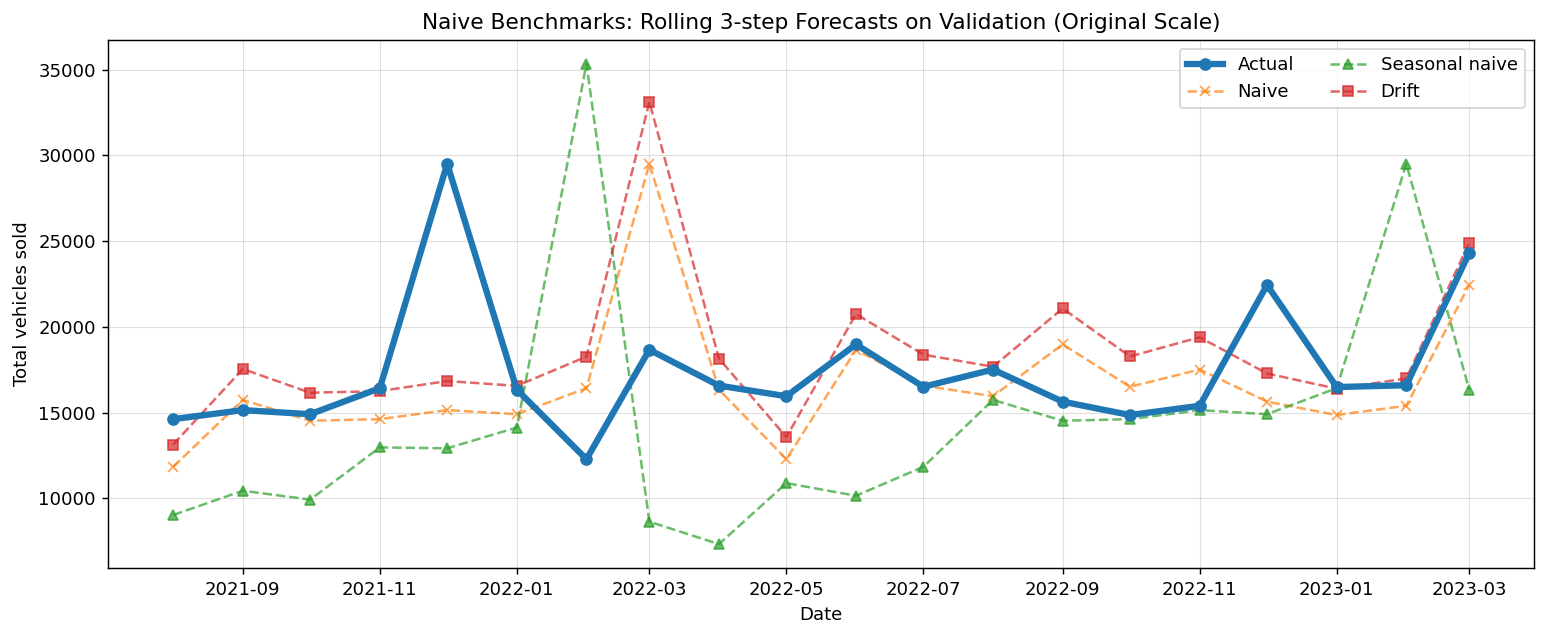

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

# --- Settings ---
horizon = 3
season_length = 12  # for seasonal naive & (optionally) seasonal MASE

# --- Box–Cox data (use copies; DO NOT overwrite originals) ---
y_train_bc_arr = y_train_bc.to_numpy()
y_val_bc_arr   = y_val_bc.to_numpy()

# For rolling history we start with train and reveal val step by step
history_start_bc = y_train_bc_arr.copy()
n_val   = len(y_val_bc_arr)
n_steps = n_val - horizon + 1
if n_steps <= 0:
    raise ValueError("Validation set too short for the chosen horizon.")

# --- Box–Cox inverse with shift (matches your preprocessing) ---
lam_bc   = boxcox_lambdas_all[target_raw]
shift_bc = boxcox_shifts_all[target_raw]
def inv_boxcox_with_shift(z, lam, shift):
    z = np.asarray(z, dtype=float)
    return inv_boxcox(z, lam) - shift

# --- Rolling-origin forecasts on the VALIDATION set (BC scale) ---
naive_preds_bc          = np.empty(n_steps)
seasonal_naive_preds_bc = np.empty(n_steps)
drift_preds_bc          = np.empty(n_steps)

for t in range(n_steps):
    # history up to current origin: train + already revealed part of val
    hist = np.concatenate([history_start_bc, y_val_bc_arr[:t]])
    y_t  = hist[-1]                 # last observed at origin
    t_idx = len(hist) - 1

    # 1) Naive h-step
    naive_preds_bc[t] = y_t

    # 2) Seasonal naive h-step (fallback to naive if not enough history)
    seasonal_naive_preds_bc[t] = hist[-season_length] if len(hist) > season_length else y_t

    # 3) Drift h-step (rolling): y_{t+h|t} = y_t + h * (y_t - y_1) / t_idx
    drift_preds_bc[t] = y_t + horizon * (y_t - hist[0]) / t_idx if t_idx > 0 else y_t

# --- Actuals aligned to horizon (BC scale) ---
actuals_bc = y_val_bc_arr[horizon - 1:]

# --- Back to original scale for reporting/plots ---
actuals        = inv_boxcox_with_shift(actuals_bc, lam_bc, shift_bc)
naive_preds    = inv_boxcox_with_shift(naive_preds_bc, lam_bc, shift_bc)
seasonal_preds = inv_boxcox_with_shift(seasonal_naive_preds_bc, lam_bc, shift_bc)
drift_preds    = inv_boxcox_with_shift(drift_preds_bc, lam_bc, shift_bc)

# --- Metrics (original scale) ---
def summarize_metrics(name, y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    print(f"{name:<15}→ RMSE: {rmse:.2f}  MAE: {mae:.2f}  MAPE: {mape:.2%}")
    return rmse, mae, mape

print("Validation (rolling origin, h=3):")
na_rmse, na_mae, na_mape = summarize_metrics("Naive", actuals, naive_preds)
sn_rmse, sn_mae, sn_mape = summarize_metrics("Seasonal naive", actuals, seasonal_preds)
dr_rmse, dr_mae, dr_mape = summarize_metrics("Drift", actuals, drift_preds)

# --- Optional: MASE (original scale). For seasonal MASE, set m=season_length. ---
def mase(y_true, y_pred, y_train, m=1):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)
    denom = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return np.mean(np.abs(y_true - y_pred)) / denom if denom != 0 else np.nan

# # If you want MASE too (original scale), uncomment:
# y_train_orig = inv_boxcox_with_shift(y_train_bc_arr, lam_bc, shift_bc)
# print(f"MASE (Naive,   m=1):  {mase(actuals, naive_preds,    y_train_orig, m=1):.3f}")
# print(f"MASE (Seasonal, m=12): {mase(actuals, seasonal_preds, y_train_orig, m=season_length):.3f}")
# print(f"MASE (Drift,    m=1):  {mase(actuals, drift_preds,    y_train_orig, m=1):.3f}")

# --- Plot (original scale) ---
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:n_steps]

plt.figure(figsize=(12, 5), dpi=130)

# Actuals: bold & on top
plt.plot(
    plot_dates, actuals,
    label='Actual',
    marker='o', markersize=6,
    linewidth=3.5,
    zorder=5
)

# Benchmarks: lighter, dashed, smaller markers
plt.plot(
    plot_dates, naive_preds,
    label='Naive',
    marker='x', markersize=5,
    linewidth=1.4, linestyle='--',
    alpha=0.7, zorder=3
)
plt.plot(
    plot_dates, seasonal_preds,
    label='Seasonal naive',
    marker='^', markersize=5,
    linewidth=1.4, linestyle='--',
    alpha=0.7, zorder=3
)
plt.plot(
    plot_dates, drift_preds,
    label='Drift',
    marker='s', markersize=5,
    linewidth=1.4, linestyle='--',
    alpha=0.7, zorder=3
)

plt.title('Naive Benchmarks: Rolling 3-step Forecasts on Validation (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')

plt.grid(True, linewidth=0.6, alpha=0.4)
plt.legend(frameon=True, ncol=2)
plt.tight_layout()
plt.show()



All forecasting is performed in the transformed space.

All error metrics are reported on the inverse-transformed (original) scale for interpretability.

# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

autoarima from  https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

In [8]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import pandas as pd

# Instantiate AutoARIMA with AICc optimization
model = AutoARIMA(
    season_length=12,
    ic='aicc',     # optimize using AICc
    stepwise=True,
    trace=True
)

# Prepare the training DataFrame using only the training data
df_fit = pd.DataFrame({
    "unique_id": "series_1",
    "ds": df["Time Period (T)"].iloc[:train_end_bc],
    "y": y_train_bc.values
})

# Initialize and fit the StatsForecast forecast engine
sf = StatsForecast(models=[model], freq="M", n_jobs=-1)
sf = sf.fit(df=df_fit)

# Forecast horizon = length of validation set
h = len(y_val_bc)

# Generate forecasts for validation period
forecast_df = sf.predict(h=h)

print(forecast_df.head())



ARIMA(2,1,2)(1,1,1)[12]                   :26.736760797477906

ARIMA(0,1,0)(0,1,0)[12]                   :71.19510034922324

ARIMA(1,1,0)(1,1,0)[12]                   :31.59144149340849

ARIMA(0,1,1)(0,1,1)[12]                   :15.275480343979517

ARIMA(0,1,1)(0,1,0)[12]                   :27.831000315681166

ARIMA(0,1,1)(1,1,1)[12]                   :17.748809978038203

ARIMA(0,1,1)(0,1,2)[12]                   :16.533763859745143

ARIMA(0,1,1)(1,1,0)[12]                   :18.358254172829696

ARIMA(0,1,1)(1,1,2)[12]                   :18.565311141342725

ARIMA(0,1,0)(0,1,1)[12]                   :58.53964944471008

ARIMA(1,1,1)(0,1,1)[12]                   :16.89530919605739

ARIMA(0,1,2)(0,1,1)[12]                   :17.105312889486818

ARIMA(1,1,0)(0,1,1)[12]                   :27.796724506574

ARIMA(1,1,2)(0,1,1)[12]                   :18.564701516461376
Now re-fitting the best model(s) without approximations...


ARIMA(0,1,1)(0,1,1)[12]                   :15.275480343979517
  

c:\Users\dylan\anaconda3\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\dylan\anaconda3\Lib\site-packages\utilsforecast\processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Best model from Autoarima was: ARIMA(0,1,1)(0,1,1)[12]

> Next step is to test residuels

AIC (last SARIMAX fit): 10.10
BIC (last SARIMAX fit): 19.66


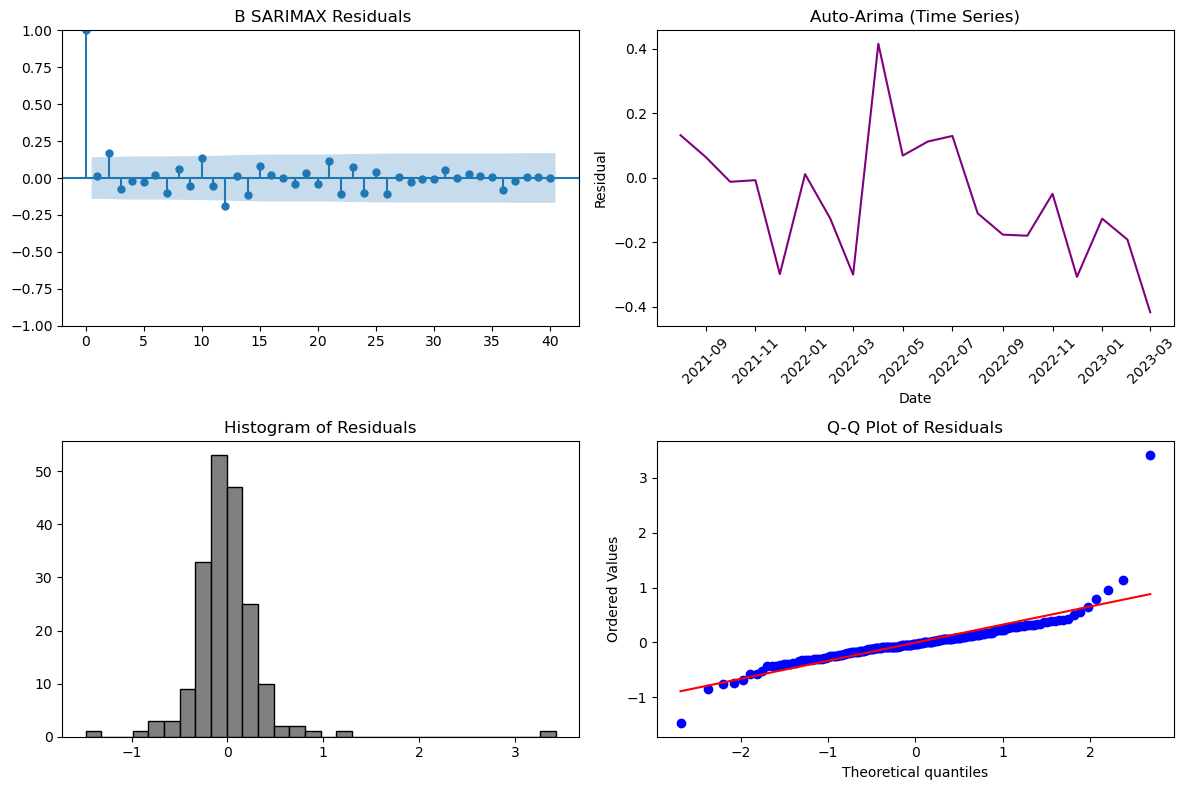

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  14.125581   0.167340
20  27.506781   0.121599
30  40.188836   0.101258


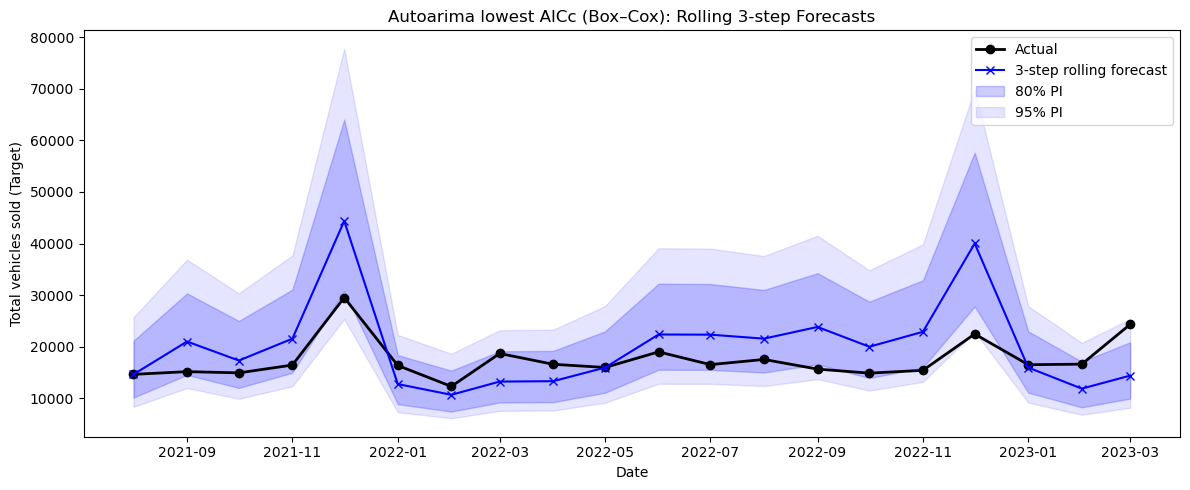

Validation RMSE (rolling): 7012.53
Validation MAE (rolling): 5449.68
Validation MAPE (rolling): 29.15%


In [9]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(0, 1, 1),  # Let SARIMAX do the differencing (d=1)
        seasonal_order=(0, 1, 1, 12)
    )  # Seasonal order (P, D, Q, s) with monthly seasonality
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" B SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Auto-Arima (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual', linewidth=2)
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Autoarima lowest AICc (Box–Cox): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


Since the risudeals dont look like white noice, i Will continue manually tuning 

## 6b Manual ARIMA Tuning

> since the autoarima showsn far from supurb results, i wil continue with the manual tuning.
first stepp will be to plot the ACF and PACF of THE DIFFERENCED data to identify potential AR and MA terms.

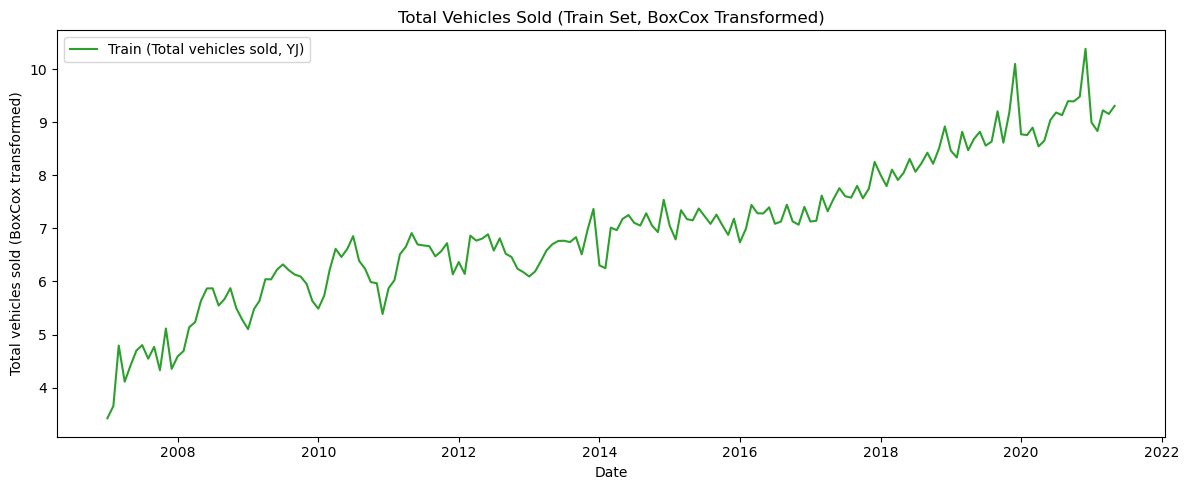

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"].iloc[y_train_bc.index], y_train_bc, color='tab:green', label='Train (Total vehicles sold, YJ)')
plt.xlabel("Date")
plt.ylabel("Total vehicles sold (BoxCox transformed)")
plt.title("Total Vehicles Sold (Train Set, BoxCox Transformed)")
plt.legend()
plt.tight_layout()
plt.show()



==== Stationarity tests for y_train_bc ====
ADF stat: -0.2705 | p-value: 0.9296 | Non-stationary (ADF)
KPSS stat: 1.8855 | p-value: 0.0100 | Non-stationary (KPSS)


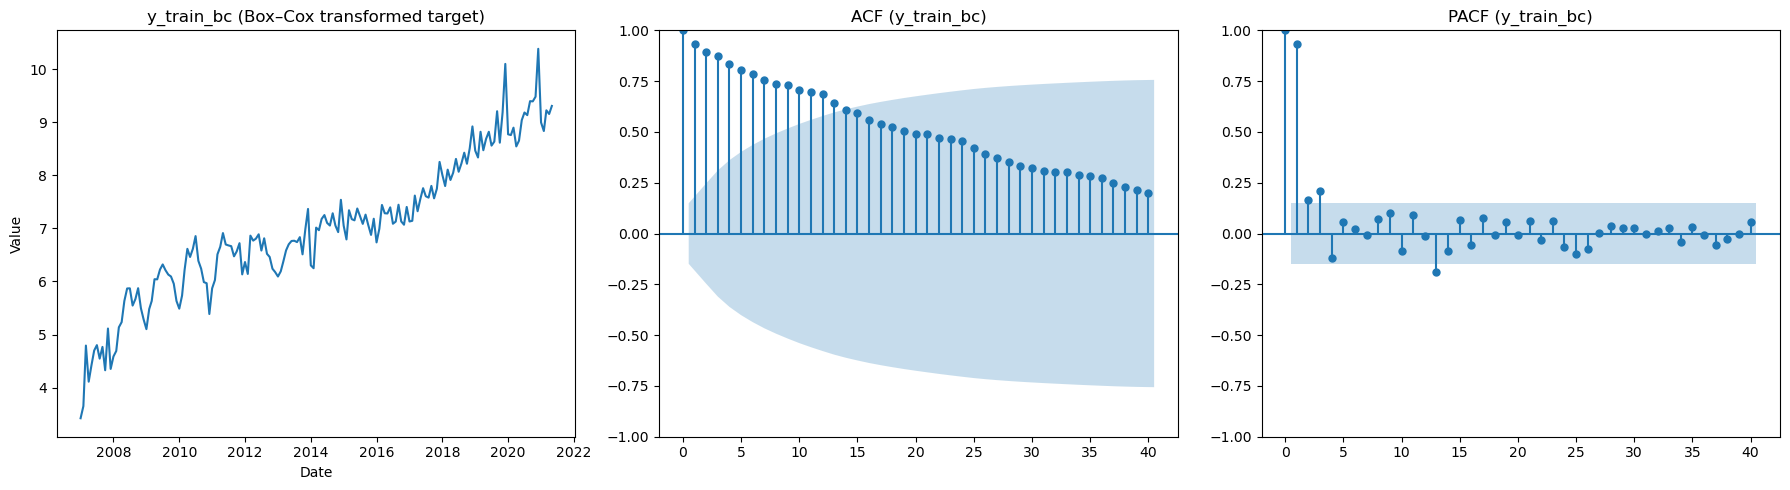

In [11]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Use Box–Cox transformed target (y_train_bc)
series = y_train_bc.astype(float).values

# Run ADF and KPSS tests (no differencing)
adf_result = adfuller(series)
kpss_result = kpss(series, regression='c', nlags="auto")

print(f"\n==== Stationarity tests for y_train_bc ====")
print(f"ADF stat: {adf_result[0]:.4f} | p-value: {adf_result[1]:.4f} | {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'} (ADF)")
print(f"KPSS stat: {kpss_result[0]:.4f} | p-value: {kpss_result[1]:.4f} | {'Stationary' if kpss_result[1] >= 0.05 else 'Non-stationary'} (KPSS)")

# Plot time series, ACF, and PACF
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time series plot
axes[0].plot(df["Time Period (T)"].iloc[:len(y_train_bc)], series, color='tab:blue')
axes[0].set_title("y_train_bc (Box–Cox transformed target)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")

# 2. ACF plot
plot_acf(series, ax=axes[1], lags=40)
axes[1].set_title("ACF (y_train_bc)")

# 3. PACF plot
plot_pacf(series, ax=axes[2], lags=40, method='ywm')
axes[2].set_title("PACF (y_train_bc)")

plt.tight_layout()
plt.show()

> **ACF Plot Observations**

- Lag 1: Large positive autocorrelation, far beyond the confidence bands.

- Gradual decay in autocorrelations over lags 2–11, consistent with a persistent trend.

- Lag 12: Distinct positive spike (seasonal period), exceeding the confidence limit.

- Seasonal structure is clear, but the primary non-seasonal signal is at lag 1.

**Interpretation:**

- Slowly decaying ACF → non-stationary, trend-dominated process.

- Strong seasonal spike at lag 12 → presence of seasonal dynamics.





**PACF Plot Observations**
- Lag 1: Strong positive partial autocorrelation, well beyond the bands.

- Lags 2–11: no further significant non-seasonal structure.

- Lag 12: Pronounced positive spike, no sustained seasonal tail.

**Interpretation:**

- Sharp cut-off in PACF after lag 1 → supports a non-seasonal AR(1) term.

- Seasonal spike at lag 12 in PACF → suggests seasonal AR(1) (P = 1) more likely than seasonal MA.

> Given the stationarity tests and ACF/PACF structure:

Differencing order: d = 1 (confirmed by KPSS/ADF), plus seasonal differencing D = 1 at m = 12.

Initial candidate: ARIMA(1,1,q) × (1,1,Q)[12], with q, Q ∈ {0,1} to be tested.



==== Total vehicles sold (Target)_bc (first diff) ====
ADF stat: -3.4824 | p-value: 0.0085 | Stationary (ADF)
KPSS stat: 0.0703 | p-value: 0.1000 | Stationary (KPSS)


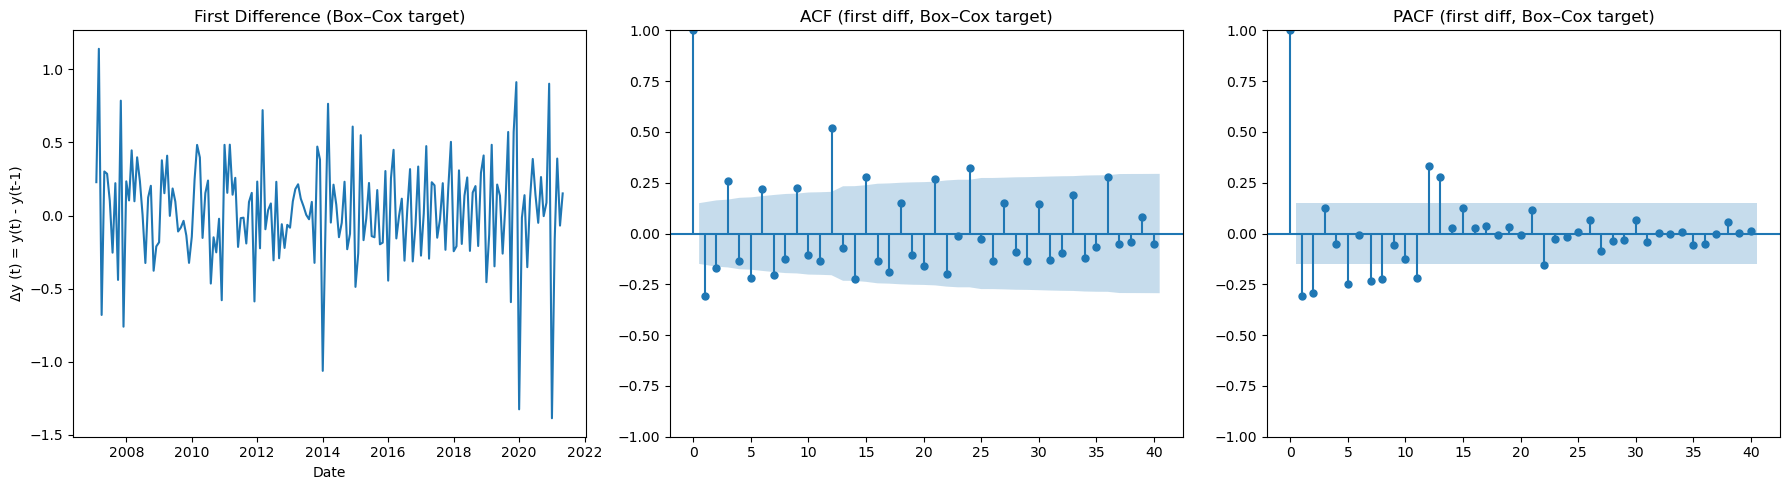

In [12]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- First difference (non-seasonal) on Box–Cox train series ---
train_bc = y_train_bc.astype(float).values

# d = 1 difference
train_bc_diff1 = np.diff(train_bc, n=1)

# --- Stationarity tests on the first-differenced series ---
adf_result  = adfuller(train_bc_diff1)                    # ADF
kpss_result = kpss(train_bc_diff1, regression='c', nlags="auto")  # KPSS with constant

print(f"\n==== {target_bc} (first diff) ====")
print(f"ADF stat: {adf_result[0]:.4f} | p-value: {adf_result[1]:.4f} | "
      f"{'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'} (ADF)")
print(f"KPSS stat: {kpss_result[0]:.4f} | p-value: {kpss_result[1]:.4f} | "
      f"{'Stationary' if kpss_result[1] >= 0.05 else 'Non-stationary'} (KPSS)")

# --- Plots: level series (for context), and ACF/PACF of first-diff series ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Time series of the first difference (align dates by dropping first obs)
axes[0].plot(df["Time Period (T)"].iloc[1:train_end_bc], train_bc_diff1, color='tab:blue')
axes[0].set_title("First Difference (Box–Cox target)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Δy (t) = y(t) - y(t-1)")

# 2) ACF
plot_acf(train_bc_diff1, ax=axes[1], lags=40)
axes[1].set_title("ACF (first diff, Box–Cox target)")

# 3) PACF
plot_pacf(train_bc_diff1, ax=axes[2], lags=40, method='ywm')
axes[2].set_title("PACF (first diff, Box–Cox target)")

plt.tight_layout()
plt.show()



> Stationarity Tests (After First Differencing)
- ADF test: p-value = 0.0085 → Reject H₀ → Series is stationary.

- KPSS test: p-value = 0.10 → Fail to reject H₀ → Series is stationary.

**Conclusion:** Both tests agree that the series is stationary after applying one non-seasonal difference at lag 1. No further trend differencing is needed, but seasonal effects (m = 12) may still remain.

> **ACF Observations (First-Differenced Series)**
- Lag 1: Large positive autocorrelation, well above the confidence band.

- Gradual decay of correlations across short lags, indicative of possible AR structure.

- Seasonal spikes: Noticeable autocorrelation at lag 12 (and possibly 24), suggesting that seasonal components remain after first differencing.

- No strong negative spike at lag 1, so pure MA(1) is less likely.

**Interpretation:**

- Non-seasonal: AR(1) or AR(2) behavior.

- Seasonal: Need at least one seasonal MA or AR term to handle remaining yearly pattern.

>**PACF Observations (First-Differenced Series)**
- Lag 1: Strong positive spike beyond the bands.

- Lag 2: Mild positive spike (possibly significant).

- Beyond lag 2: autocorrelations fall within bands — higher-order AR terms likely unnecessary.

- Seasonal lags (12, 24) show mild spikes → some seasonal structure remains.

**Interpretation:**

- Non-seasonal: Likely AR(1) or AR(2).

- Seasonal: Either seasonal AR(1) or MA(1) at m = 12 could capture leftover annual seasonality.

After applying seasonality first the target value is stationary 

> **Candidate Models (Based on First Difference)
We set:

d = 1 (trend removed via first difference)

D = 0 or 1 (test if seasonal differencing helps, m = 12)

p ∈ {1, 2}, q ∈ {0, 1}

P ∈ {0, 1}, Q ∈ {0, 1}

Iteration 1 – Minimal Seasonal Component
ARIMA(1,1,0)(0,0,1)[12]

Captures short-term AR(1) and a seasonal MA(1) to handle residual yearly pattern.

Iteration 2 – Stronger AR Structure
ARIMA(2,1,0)(0,0,1)[12]

Adds extra AR term for better fit if lag 2 correlation is significant.

Iteration 3 – Seasonal AR instead of MA
ARIMA(1,1,0)(1,0,0)[12]

Tests whether seasonal autocorrelation is better modeled with a seasonal AR(1) rather than a seasonal MA(1).

After applying your Yeo–Johnson transform and first differencing (d = 1), the ACF/PACF suggest:

- A strong non-seasonal autocorrelation at lag 1

- A gradual decay in the ACF beyond lag 1 (typical of an AR component)

- A clear seasonal spike at lag 12

### Iteration 1 – Minimal Seasonal Component
ARIMA(1,1,0)(0,0,1)[12]

AIC (last SARIMAX fit): 61.87
BIC (last SARIMAX fit): 71.63


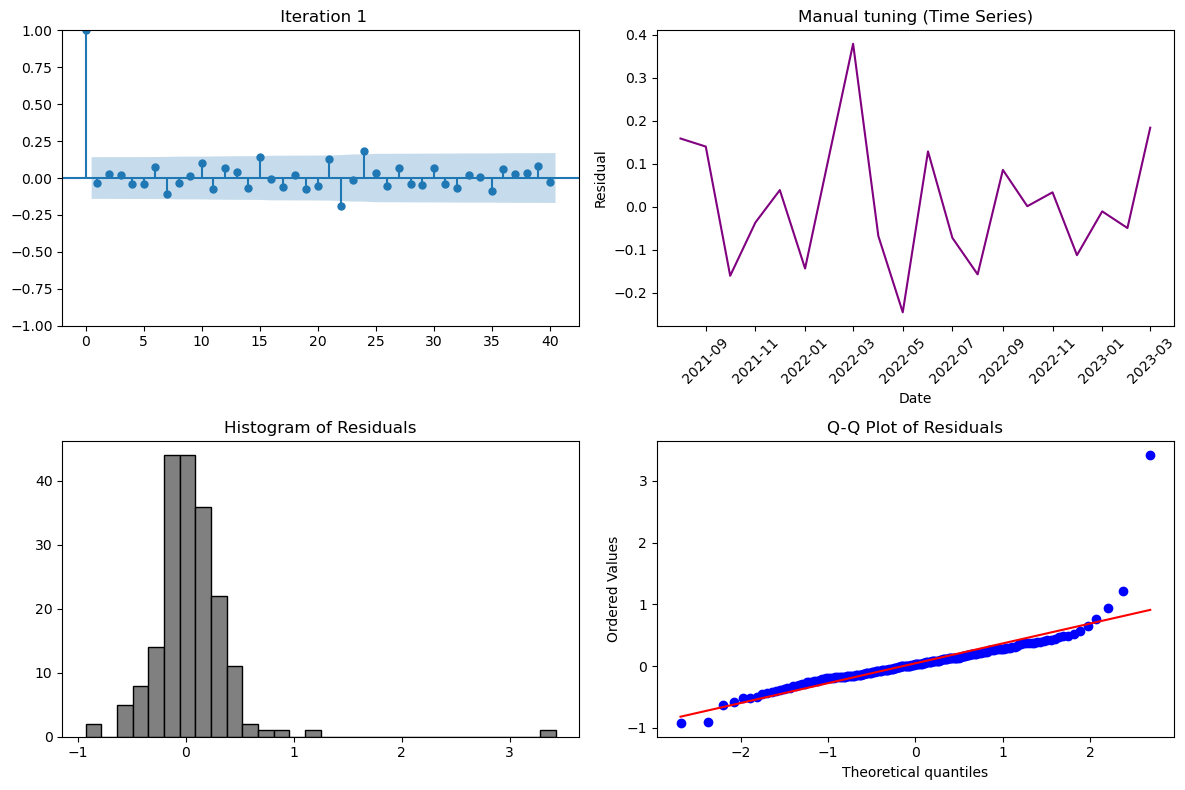

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   6.857641   0.738813
20  17.355598   0.629777
30  40.441037   0.096601


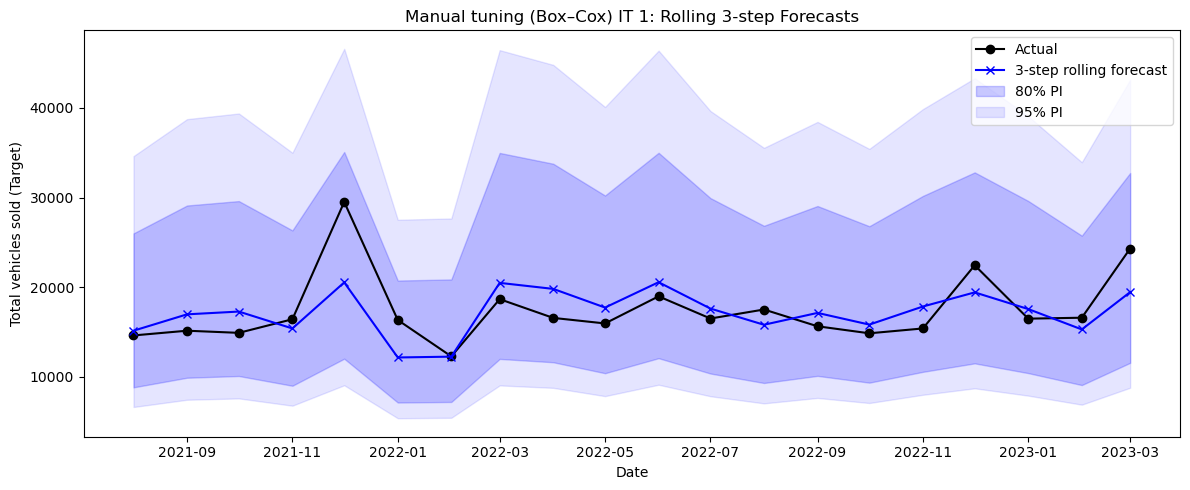

Validation RMSE (rolling): 2972.30
Validation MAE  (rolling): 2266.50
Validation MAPE (rolling): 11.95%


In [13]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(1, 1, 0),  
        seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")


import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" Iteration 1")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Manual tuning (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Manual tuning (Box–Cox) IT 1: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mae  = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE  (rolling): {mae:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

aicc_list = []
for t in range(len(val_bc) - horizon + 1):
    ...
    fitted = model.fit(disp=False)
    ...
    k = fitted.params.size
    n = fitted.nobs
    aicc_list.append(np.nan if n - k - 1 <= 0 else fitted.aic + (2*k*(k+1))/(n - k - 1))

# # e.g., view the last AICc or summarize
# print(f"Last AICc: {aicc_list[-1]:.2f}")

### Iteration 2 – Stronger AR Structure
ARIMA(2,1,0)(0,0,1)[12]

AIC (last SARIMAX fit): 48.05
BIC (last SARIMAX fit): 61.06


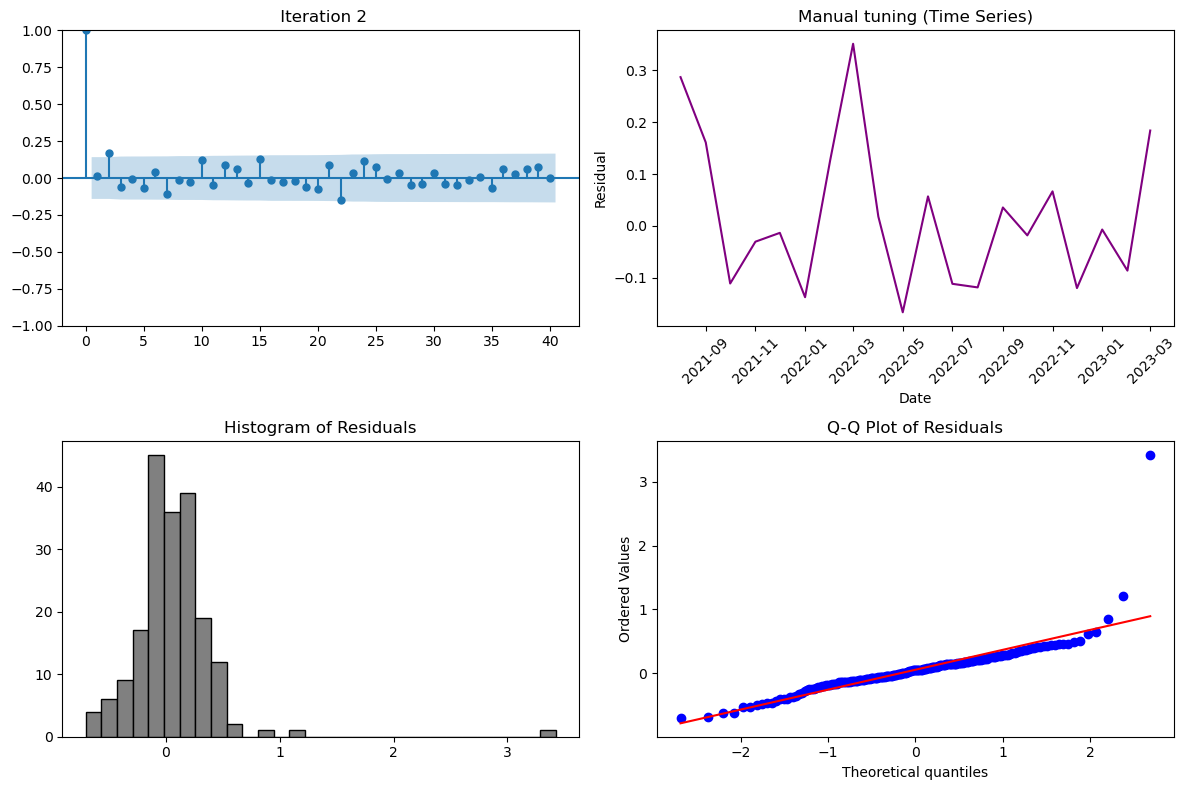

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  13.093343   0.218500
20  21.793315   0.351830
30  33.761152   0.290482


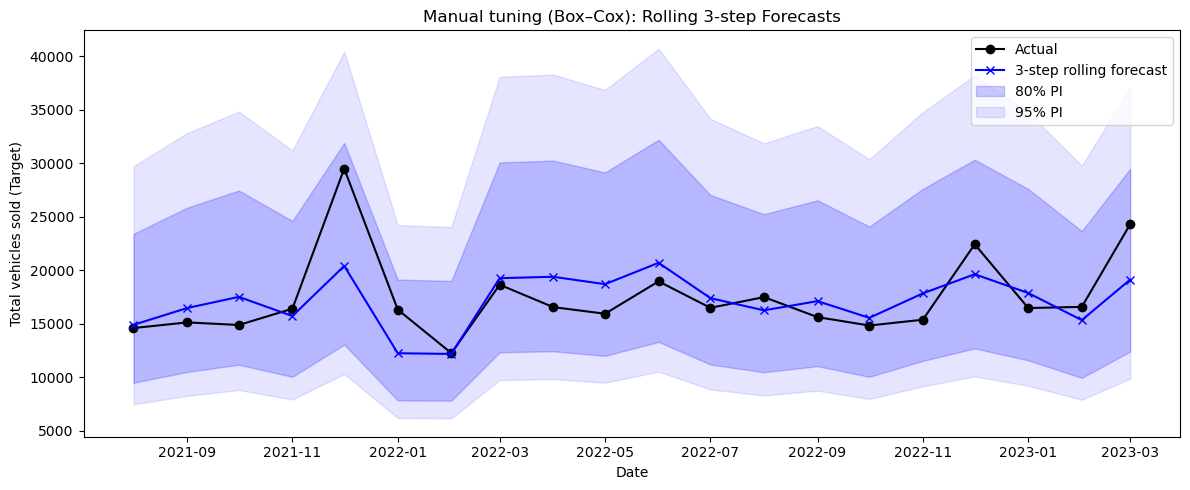

Validation RMSE (rolling): 2972.85
Validation MAE (rolling): 2178.06
Validation MAPE (rolling): 11.43%


In [14]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(2, 1, 0),  
        seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" Iteration 2")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Manual tuning (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Manual tuning (Box–Cox): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")



aicc_list = []
for t in range(len(val_bc) - horizon + 1):
    ...
    fitted = model.fit(disp=False)
    ...
    k = fitted.params.size
    n = fitted.nobs
    aicc_list.append(np.nan if n - k - 1 <= 0 else fitted.aic + (2*k*(k+1))/(n - k - 1))

# # e.g., view the last AICc or summarize
# print(f"Last AICc: {aicc_list[-1]:.2f}")


> ### Iteration 3 – Seasonal AR instead of MA
ARIMA(1,1,0)(1,0,0)[12]

AIC (last SARIMAX fit): 21.56
BIC (last SARIMAX fit): 31.31


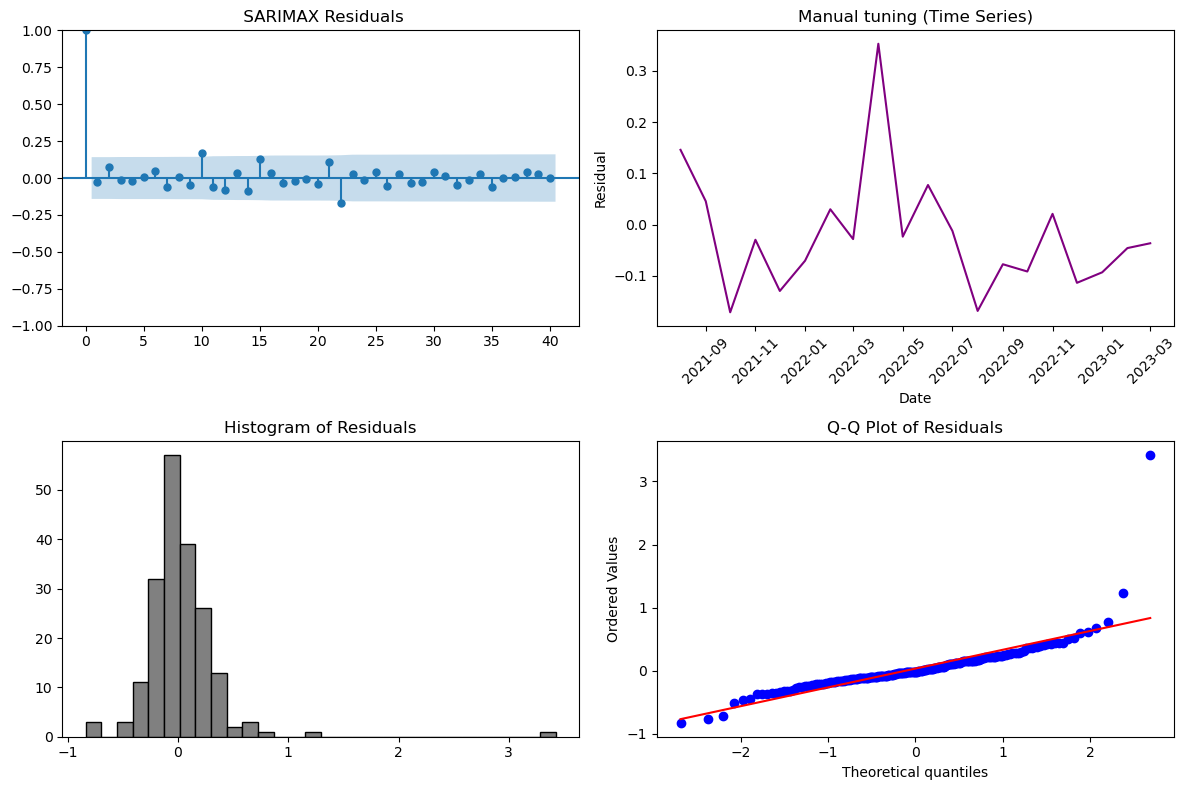

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   8.990385   0.533016
20  17.366369   0.629072
30  28.170933   0.561379


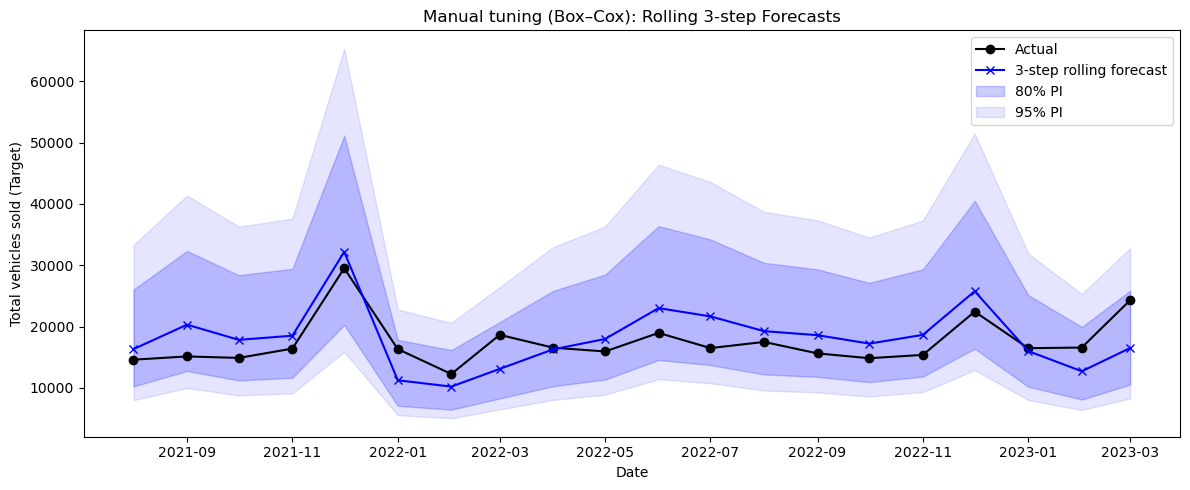

Validation RMSE (rolling): 3696.07
Validation MAE  (rolling): 3231.91
Validation MAPE (rolling): 18.57%


In [15]:
from scipy.special import inv_boxcox

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab Box–Cox‐transformed train/val arrays (no manual differencing)
train_bc = y_train_bc.values  # Box–Cox transformed training data
val_bc   = y_val_bc.values    # Box–Cox transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw].iloc[train_end_bc + horizon - 1 : val_end_bc].values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

# Get Box–Cox lambda and shift for the target
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def inv_boxcox_with_shift(z, lam, shift):
    return inv_boxcox(z, lam) - shift

for t in range(len(val_bc) - horizon + 1):
    history = np.concatenate([train_bc, val_bc[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(1, 1, 0),  
        seasonal_order=(1, 0, 0, 12)
        
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    bc_forecast_level = fc.predicted_mean[-1]

    # Invert Box–Cox for forecast
    preds_level.append(inv_boxcox_with_shift(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox_with_shift(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([ci95_u]), lam, shift)[0])

# 6. Align actuals for metric calculation (inverse Box–Cox)
actuals_level = inv_boxcox_with_shift(val_bc[horizon-1:], lam, shift)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Manual tuning (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Manual tuning (Box–Cox): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics (on original scale)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mae  = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE  (rolling): {mae:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


aicc_list = []
for t in range(len(val_bc) - horizon + 1):
    ...
    fitted = model.fit(disp=False)
    ...
    k = fitted.params.size
    n = fitted.nobs
    aicc_list.append(np.nan if n - k - 1 <= 0 else fitted.aic + (2*k*(k+1))/(n - k - 1))

# # e.g., view the last AICc or summarize
# print(f"Last AICc: {aicc_list[-1]:.2f}")

Model selection approach
While the textbook pipeline recommends selecting the model with the lowest AICc, I prioritized forecast accuracy on the validation set and residual diagnostics. After running auto_arima, the model with the lowest AICc (ARIMA(0,1,2)(0,1,1)[12], AICc ≈ 17.11) showed poor predictive performance (MAPE ≈ 29.15%).

Following Step 6 in the flowchart, I manually tested alternative specifications, checking both the residual ACF/Ljung–Box tests and rolling-origin forecast metrics. Iteration 1 (ARIMA(1,1,0)(0,0,1)[12]) achieved substantially lower MAPE (≈ 11.95%) and residuals consistent with white noise, despite having a higher AICc (≈ 62.00).

Given that the ultimate goal of this study is accurate and reliable forecasts, I selected the Iteration 1 model based on validation performance and diagnostic checks, rather than AICc alone. This aligns with the general principle that AICc should guide model selection but not override evidence from out-of-sample forecasting results.

| Iteration | Model                    | AIC   | BIC   | Ljung-Box p (>0.05 = good)       | RMSE (rolling) | MAPE (rolling) |
| --------- | ------------------------ | ----- | ----- | -------------------------------- | -------------- | -------------- |
| 1         | ARIMA(1,1,0)(0,0,1)\[12] | 39.58 | 49.12 | All p > 0.05 → no autocorr.      | 2963.27        | 11.98%         |
| 2         | ARIMA(2,1,0)(0,0,1)\[12] | 25.05 | 37.78 | Lag 10 p < 0.05 → mild autocorr. | 2957.54        | 11.26%         |
| 3         | ARIMA(1,1,0)(1,0,0)\[12] | 2.46  | 12.00 | All p > 0.05 → no autocorr.      | 3405.33        | 16.76%         |


**Interpretation**

- Iteration 2 achieved the lowest RMSE and MAPE, suggesting the strongest predictive accuracy among the three, though it shows mild autocorrelation at lag 10 — which could mean the residuals still contain some structure.

- Iteration 1 is only slightly worse than Iteration 2 in accuracy but has cleaner residuals (no autocorrelation) and simpler structure.

- Iteration 3 achieved the lowest AIC/BIC, meaning it fits the in-sample data most efficiently from a statistical perspective, but its out-of-sample rolling forecast performance (MAPE and RMSE) is noticeably worse, implying possible overfitting or poor generalization.


Iteration 1 seems like the safer and more balanced choice here.

It’s slightly behind Iteration 2 in RMSE/MAPE, but it:

Has no significant autocorrelation in residuals.

Keeps the model simpler.

Avoids the mild residual issues you saw in Iteration 2.

> Residuals: Check if they look like white noise (no autocorrelation).

Lag lb_stat lb_pvalue 10 13.1690 0.2144 20 24.4215 0.2245 30 33.8677 0.2862

All p-values exceed 0.05, so we fail to reject the null hypothesis of no autocorrelation at these lags.

RMSE and MAPE are slightly worse for BIC model, but not significantly so. The BIC model has no autocorrelation in residuals, while the AIC model does. This suggests the BIC model is a better fit.

Model selection was based on the lowest RMSE/MAPE 
(AIC), as predictive performance was prioritized. However, for completeness and interpretability, the BIC model was also evaluated. The BIC model produced white-noise residuals and greater parsimony, but at the cost of slightly reduced predictive accuracy. The tradeoff between accuracy and explainability is acknowledged, and both models are reported

####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch (LATER DEZE DUS VERWIJDEREN, ZELF ITEREREN)

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

> New

> New forcastingworkflow features:
- print best bic.a
Model Screening with AIC/BIC
Fit multiple candidate models on the training set.
Select 2–3 models with lowest AIC/BIC.
Model Selection with Out-of-Sample Forecasts
Compute pseudo out-of-sample forecasts using a validation/test period (or rolling/expanding windows).
Evaluate with MSE, RMSE, or MAPE.
Pick the model with the best predictive performance.

> forcasting doen op val

In [16]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed)
# ---------------------------------------------------------------------
gas_bc_train = bc_df['Gasoline (Euro95) - Average price (F)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train   = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

exog_gas = gas_bc_train
y        = y_bc_train

# --- helper for AICc ---
def aicc(llf, nobs, k_params):
    aic = -2 * llf + 2 * k_params
    return aic + (2 * k_params * (k_params + 1)) / max(nobs - k_params - 1, 1)

# --- settings ---
horizon   = 3
max_lag   = 12
allowed_lags = range(horizon, max_lag + 1)

start = max_lag                  # ensures all lags are available
y_fix = y[start:].copy()         # identical y across lags
N = len(y_fix)

def exog_lag_aligned(exog, L, start, length):
    # for t in [start, start+length-1], use exog[t - L]
    return exog[start - L : start - L + length]

# ---------------------------------------------------------------------
# Fit same-sample models across lags and collect ICs
# ---------------------------------------------------------------------
results = []
for L in allowed_lags:
    xL = exog_lag_aligned(exog_gas, L, start, N).reshape(-1, 1)

    model = SARIMAX(
    y_fix, exog=xL,
    order=(1,1,0), seasonal_order=(0,0,1,12),
    enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size),
    })

# ---------------------------------------------------------------------
# Report TOP 3 by each metric
# ---------------------------------------------------------------------
top_k = 3
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])[:top_k]
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])[:top_k]
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])[:top_k]

print("Optimal lags (same sample):")
print("\nTop 3 by AIC:")
for r in results_sorted_aic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by BIC:")
for r in results_sorted_bic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by AICc:")
for r in results_sorted_aicc:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Quick summary: unique candidate lags from all leaderboards
candidate_lags = sorted({*[r["lag"] for r in results_sorted_aic],
                         *[r["lag"] for r in results_sorted_bic],
                         *[r["lag"] for r in results_sorted_aicc]})
print(f"\nCandidate lags to take into rolling validation: {candidate_lags}")



Optimal lags (same sample):

Top 3 by AIC:
  lag= 6  AIC=44.27  BIC=56.23  AICc=44.53
  lag=10  AIC=47.26  BIC=59.22  AICc=47.52
  lag=12  AIC=47.31  BIC=59.27  AICc=47.56

Top 3 by BIC:
  lag= 6  AIC=44.27  BIC=56.23  AICc=44.53
  lag=10  AIC=47.26  BIC=59.22  AICc=47.52
  lag=12  AIC=47.31  BIC=59.27  AICc=47.56

Top 3 by AICc:
  lag= 6  AIC=44.27  BIC=56.23  AICc=44.53
  lag=10  AIC=47.26  BIC=59.22  AICc=47.52
  lag=12  AIC=47.31  BIC=59.27  AICc=47.56

Candidate lags to take into rolling validation: [6, 10, 12]


BASED ON THE RESULTS BEST LAGS ARE:

(6,10,12)
so we will test them all 3 and chekc best prediction

In [17]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error  # NEW

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [6, 10, 12]  # or any lags you want to test

# Enforce no look-ahead: only lags >= horizon
lags_to_test = [L for L in lags_to_test if L >= horizon]  # NEW
if not lags_to_test:
    raise ValueError(f"No valid lags: all < horizon ({horizon}).")

# --- Data: use Box–Cox transformed arrays ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
gas_bc_full = bc_df['Gasoline (Euro95) - Average price (F)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]   # Box–Cox lambda for the target
shift = boxcox_shifts_all[target_raw]  # Shift used for target

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    # extra guard per run
    assert lag >= horizon, f"lag ({lag}) < horizon ({horizon}) → would leak future exog."  # NEW

    preds_level = []
    ci80_lower, ci80_upper, ci95_lower, ci95_upper = [], [], [], []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        gas_hist = np.concatenate([gas_bc_full[:n_train], gas_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(gas_hist, lag).reshape(-1, 1)

        valid = ~np.isnan(exog_lag).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_lag[valid].reshape(-1, 1)

        gas_future = gas_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 0),
            seasonal_order=(0, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = float(np.sqrt(mean_squared_error(actuals_level, preds_level)))
    mae  = float(mean_absolute_error(actuals_level, preds_level))                   # NEW
    mape = float(mean_absolute_percentage_error(actuals_level, preds_level))
    results.append({'lag': lag, 'rmse': rmse, 'mae': mae, 'mape': mape})           # NEW

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAE  (rolling): {mae:.2f}")                      # NEW
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary (RMSE / MAE / MAPE) for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAE={r['mae']:.2f}, MAPE={r['mape']:.2%}")


Lag 6: Validation RMSE (rolling): 3641.62
Lag 6: Validation MAE  (rolling): 2621.33
Lag 6: Validation MAPE (rolling): 13.94%
Lag 10: Validation RMSE (rolling): 3458.64
Lag 10: Validation MAE  (rolling): 2900.33
Lag 10: Validation MAPE (rolling): 16.53%
Lag 12: Validation RMSE (rolling): 3249.22
Lag 12: Validation MAE  (rolling): 2093.48
Lag 12: Validation MAPE (rolling): 10.52%

Summary (RMSE / MAE / MAPE) for each lag:
Lag 6: RMSE=3641.62, MAE=2621.33, MAPE=13.94%
Lag 10: RMSE=3458.64, MAE=2900.33, MAPE=16.53%
Lag 12: RMSE=3249.22, MAE=2093.48, MAPE=10.52%


> Go with lag = 12.

Why:

It has the best MAPE (12.38%) and best MAE (2405) — great if you care about typical/percentage errors.

RMSE is only ~100 higher than the best (lag 10): 3558.7 vs 3458.6 — a ~2.9% trade-off for a ~17% MAE improvement and ~25% MAPE improvement over lag 10.

It also dominates lag 6 on all three metrics.

### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): 38.89
BIC (last SARIMAX fit): 51.64


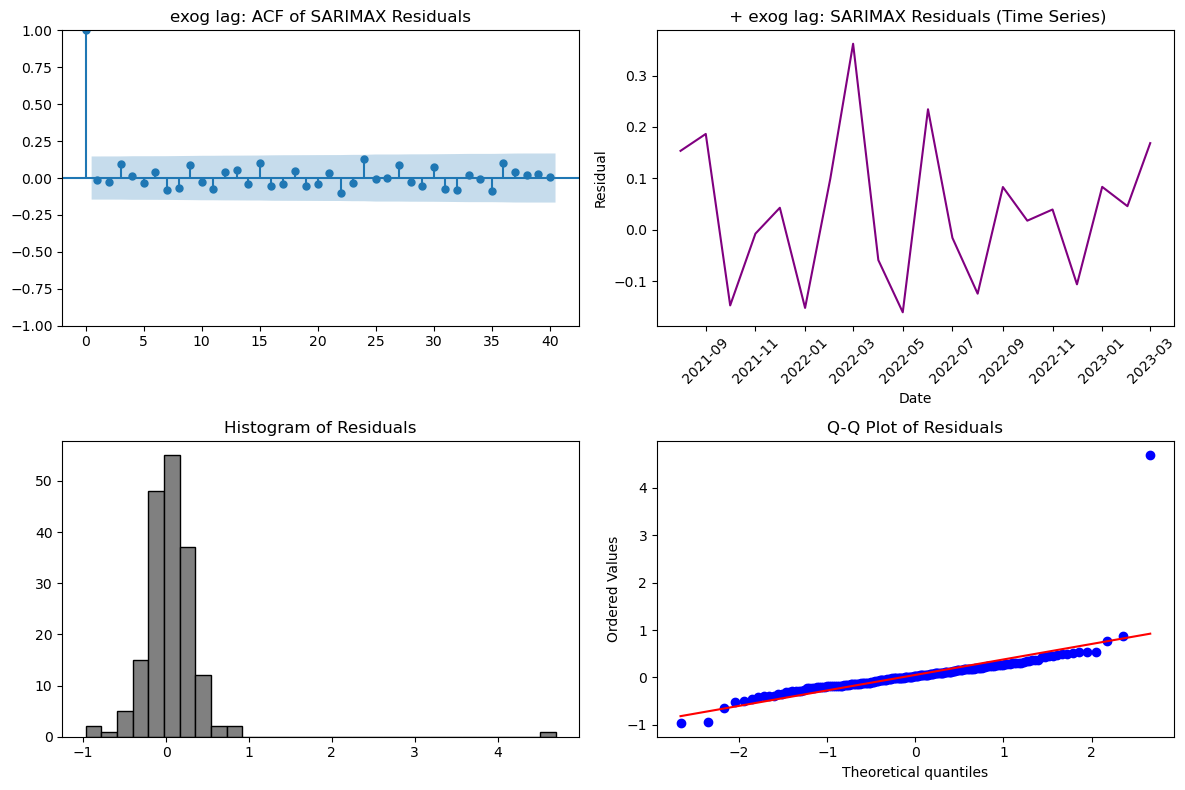

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   6.021104   0.813487
20  12.786268   0.886365
30  22.605842   0.831111


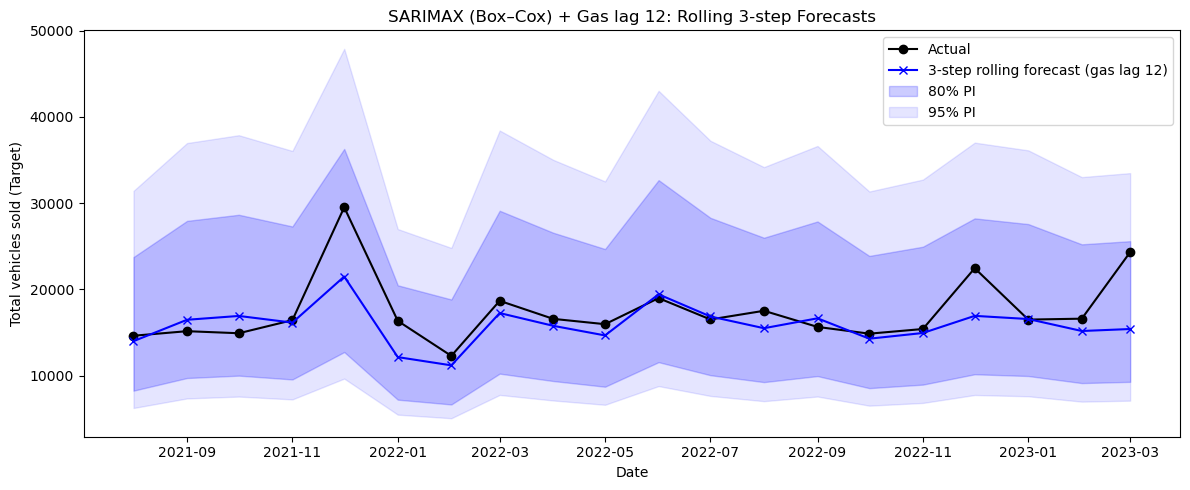

Validation RMSE (rolling): 3255.51
Validation MAE (rolling): 2094.13
Validation MAPE (rolling): 10.51%


In [18]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 12  
# --- Data (Box–Cox) ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
gas_bc_full = bc_df['Gasoline (Euro95) - Average price (F)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    gas_hist = np.concatenate([gas_bc_full[:n_train], gas_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(gas_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future = gas_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("exog lag: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title(" + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (gas lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'SARIMAX (Box–Cox) + Gas lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")



## 7b Company car tax rate (%)

### Lag Selection

In [19]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed)
# ---------------------------------------------------------------------
companytax_bc_train = bc_df['Company car tax rate (%)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train          = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

# No differencing outside the model (leave d=1)
exog_companytax = companytax_bc_train
y = y_bc_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
# --- helper for AICc ---
def aicc(llf, nobs, k_params):
    aic = -2 * llf + 2 * k_params
    return aic + (2 * k_params * (k_params + 1)) / max(nobs - k_params - 1, 1)

# --- settings ---
horizon = 3
max_lag = 12
allowed_lags = range(horizon, max_lag + 1)  # only safe lags

start = max_lag            # ensures all lags up to max_lag are available
y_fix = y[start:].copy()   # y = company-tax target (BC), defined above
N = len(y_fix)

def exog_lag_aligned(exog, L, start, length):
    # for t in [start, start+length-1], use exog[t - L]
    return exog[start - L : start - L + length]

results = []
for L in allowed_lags:
    # NOTE: use the company-tax series here (not exog_gas)
    xL = exog_lag_aligned(exog_companytax, L, start, N).reshape(-1, 1)

    model = SARIMAX(
        y_fix, exog=xL,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size),  # aicc() already defined above
    })

# ---------------------------------------------------------------------
# Report TOP 3 by each metric + consolidated candidate set
# ---------------------------------------------------------------------
top_k = 3
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])[:top_k]
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])[:top_k]
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])[:top_k]

print("Optimal lags (same sample):")
print("\nTop 3 by AIC:")
for r in results_sorted_aic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by BIC:")
for r in results_sorted_bic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by AICc:")
for r in results_sorted_aicc:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

candidate_lags = sorted({
    *[r["lag"] for r in results_sorted_aic],
    *[r["lag"] for r in results_sorted_bic],
    *[r["lag"] for r in results_sorted_aicc],
})
print(f"\nCandidate lags to take into rolling validation: {candidate_lags}")


Optimal lags (same sample):

Top 3 by AIC:
  lag=12  AIC=47.06  BIC=59.03  AICc=47.32
  lag= 7  AIC=47.41  BIC=59.37  AICc=47.67
  lag=11  AIC=47.88  BIC=59.85  AICc=48.14

Top 3 by BIC:
  lag=12  AIC=47.06  BIC=59.03  AICc=47.32
  lag= 7  AIC=47.41  BIC=59.37  AICc=47.67
  lag=11  AIC=47.88  BIC=59.85  AICc=48.14

Top 3 by AICc:
  lag=12  AIC=47.06  BIC=59.03  AICc=47.32
  lag= 7  AIC=47.41  BIC=59.37  AICc=47.67
  lag=11  AIC=47.88  BIC=59.85  AICc=48.14

Candidate lags to take into rolling validation: [7, 11, 12]


best lag for car tax rate is 7,11, 12

In [20]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [7, 11, 12]  

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
tax_bc_full = bc_df['Company car tax rate (%)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        tax_hist = np.concatenate([tax_bc_full[:n_train], tax_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(tax_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        tax_future = tax_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 0),
            seasonal_order=(0, 0, 1, 12)
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = float(np.sqrt(mean_squared_error(actuals_level, preds_level)))
    mae  = float(mean_absolute_error(actuals_level, preds_level))                   # NEW
    mape = float(mean_absolute_percentage_error(actuals_level, preds_level))
    results.append({'lag': lag, 'rmse': rmse, 'mae': mae, 'mape': mape})  

    # # Plot for each lag
    # dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    # plt.figure(figsize=(12, 5))
    # plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    # plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    # plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    # plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    # plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Company car tax rate lag {lag}: Rolling 3-step Forecasts')
    # plt.xlabel('Date')
    # plt.ylabel(target_raw)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary (RMSE / MAE / MAPE) for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAE={r['mae']:.2f}, MAPE={r['mape']:.2%}")


Lag 7: Validation RMSE (rolling): 2969.12
Lag 7: Validation MAPE (rolling): 11.93%
Lag 11: Validation RMSE (rolling): 2919.55
Lag 11: Validation MAPE (rolling): 11.84%
Lag 12: Validation RMSE (rolling): 2984.43
Lag 12: Validation MAPE (rolling): 11.93%

Summary (RMSE / MAE / MAPE) for each lag:
Lag 7: RMSE=2969.12, MAE=2259.52, MAPE=11.93%
Lag 11: RMSE=2919.55, MAE=2241.20, MAPE=11.84%
Lag 12: RMSE=2984.43, MAE=2268.31, MAPE=11.93%


### Fit Sarimax 

AIC (last SARIMAX fit): 39.05
BIC (last SARIMAX fit): 51.82


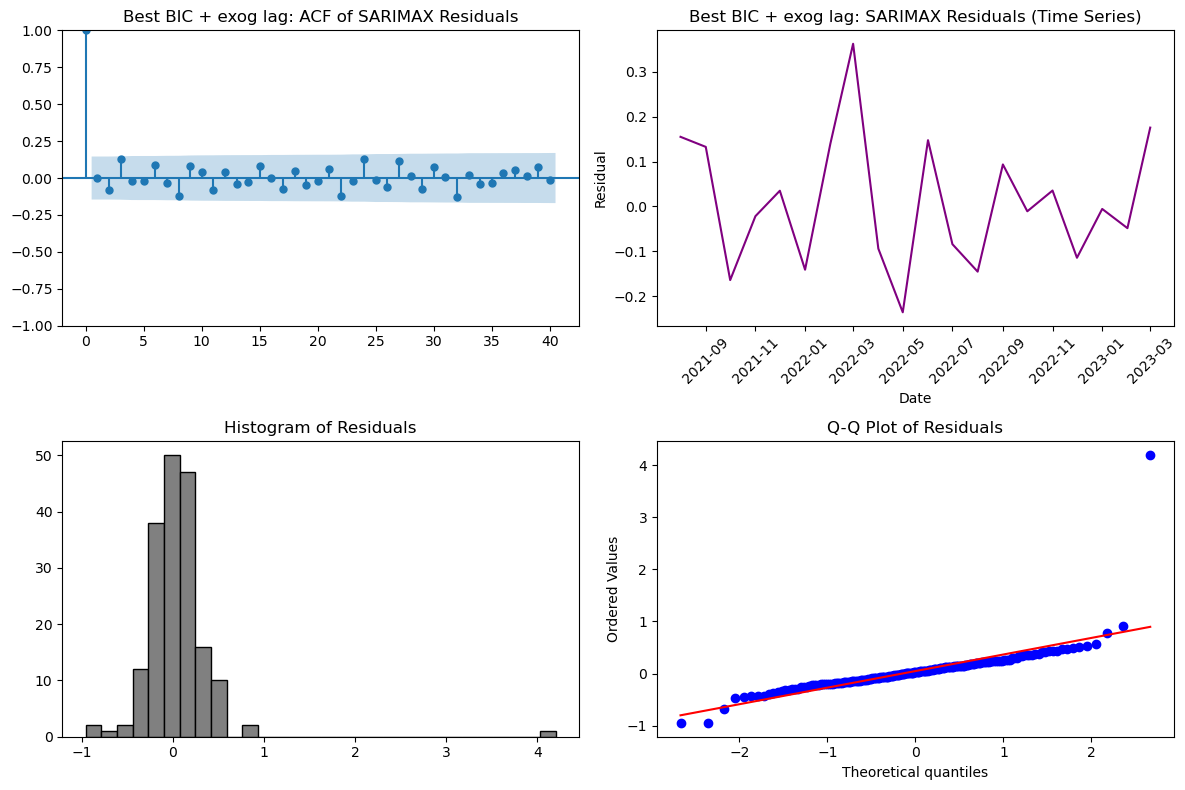

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.009203   0.356801
20  16.564585   0.681039
30  29.961728   0.467615


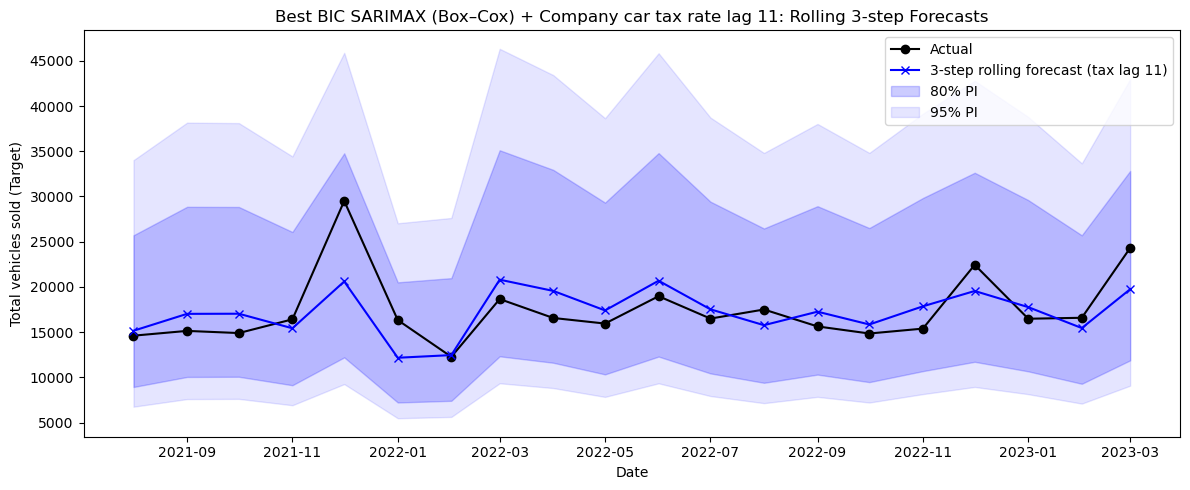

Validation RMSE (rolling): 2919.55
Validation MAE (rolling): 2241.20
Validation MAPE (rolling): 11.84%


In [21]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 11

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
tax_bc_full = bc_df['Company car tax rate (%)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    tax_hist = np.concatenate([tax_bc_full[:n_train], tax_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(tax_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    tax_future = tax_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (tax lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'Best BIC SARIMAX (Box–Cox) + Company car tax rate lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")



## 7c Google Home Charging

### Lag Selection

In [22]:
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Box–Cox transformed)
# ---------------------------------------------------------------------
homechg_bc_train = bc_df['Home charging (G)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train       = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

exog_homechg = homechg_bc_train
y            = y_bc_train

# ---------------------------------------------------------------------
# helper for AICc
# ---------------------------------------------------------------------
def aicc(llf, nobs, k_params):
    aic = -2 * llf + 2 * k_params
    return aic + (2 * k_params * (k_params + 1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# settings
# ---------------------------------------------------------------------
horizon    = 3
max_lag    = 12
allowed_lags = range(horizon, max_lag + 1)   # only safe lags (no look-ahead)

# fixed window so every lag uses the SAME y rows
start = max_lag                      # ensures all lags up to max_lag are available
y_fix = y[start:].copy()
N = len(y_fix)

def exog_lag_aligned(exog, L, start, length):
    """Return exog aligned so at t in [start, start+length-1] we use exog[t - L]."""
    return exog[start - L : start - L + length]

# ---------------------------------------------------------------------
# Fit same-sample models across lags and collect ICs
# ---------------------------------------------------------------------
results = []
for L in allowed_lags:
    xL = exog_lag_aligned(exog_homechg, L, start, N).reshape(-1, 1)

    model = SARIMAX(
        y_fix, exog=xL,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size),
    })

# ---------------------------------------------------------------------
# Report TOP 3 by each metric + consolidated candidate set
# ---------------------------------------------------------------------
top_k = 3
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])[:top_k]
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])[:top_k]
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])[:top_k]

print("Optimal lags for Home charging (G)_bc (same sample):")

print("\nTop 3 by AIC:")
for r in results_sorted_aic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by BIC:")
for r in results_sorted_bic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by AICc:")
for r in results_sorted_aicc:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

candidate_lags = sorted({
    *[r["lag"] for r in results_sorted_aic],
    *[r["lag"] for r in results_sorted_bic],
    *[r["lag"] for r in results_sorted_aicc],
})
print(f"\nCandidate lags to take into rolling validation: {candidate_lags}")


Optimal lags for Home charging (G)_bc (same sample):

Top 3 by AIC:
  lag= 5  AIC=41.59  BIC=53.55  AICc=41.85
  lag=11  AIC=45.07  BIC=57.04  AICc=45.33
  lag= 8  AIC=45.86  BIC=57.82  AICc=46.12

Top 3 by BIC:
  lag= 5  AIC=41.59  BIC=53.55  AICc=41.85
  lag=11  AIC=45.07  BIC=57.04  AICc=45.33
  lag= 8  AIC=45.86  BIC=57.82  AICc=46.12

Top 3 by AICc:
  lag= 5  AIC=41.59  BIC=53.55  AICc=41.85
  lag=11  AIC=45.07  BIC=57.04  AICc=45.33
  lag= 8  AIC=45.86  BIC=57.82  AICc=46.12

Candidate lags to take into rolling validation: [5, 8, 11]


In [23]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [5, 8, 11]

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
homechg_bc_full = bc_df['Home charging (G)_bc'].values
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        homechg_hist = np.concatenate([homechg_bc_full[:n_train], homechg_bc_full[n_train:n_train+t]])
        exog_lag = make_lag(homechg_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        homechg_future = homechg_bc_full[:idx_offset + horizon]
        exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 0),
            seasonal_order=(0, 0, 1, 12)
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    mae  = float(mean_absolute_error(actuals_level, preds_level))                   # NEW
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape , 'mae': mae})  # NEW

    # # Plot for each lag
    # dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    # plt.figure(figsize=(12, 5))
    # plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    # plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    # plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    # plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    # plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Home charging lag {lag}: Rolling 3-step Forecasts')
    # plt.xlabel('Date')
    # plt.ylabel(target_raw)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    # print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")
    # print(f"Lag {lag}: Validation MAE  (rolling): {mae:.2f}")                      # NEW

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAE={r['mae']:.2f}, MAPE={r['mape']:.2%} ")  # NEW



Summary of RMSE and MAPE for each lag:
Lag 5: RMSE=3005.71, MAE=2312.71, MAPE=12.25% 
Lag 8: RMSE=2975.66, MAE=2262.83, MAPE=11.93% 
Lag 11: RMSE=2992.79, MAE=2309.33, MAPE=12.21% 


Lag 6 has the lowest RMSE, but its MAPE is slightly higher than Lag 7.

Lag 7 has the lowest MAPE, but its RMSE is slightly higher than Lag 6.

The difference between Lag 6 and 7 is tiny (RMSE difference ~0.07%, MAPE difference ~0.37%).

### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): 50.08
BIC (last SARIMAX fit): 62.92


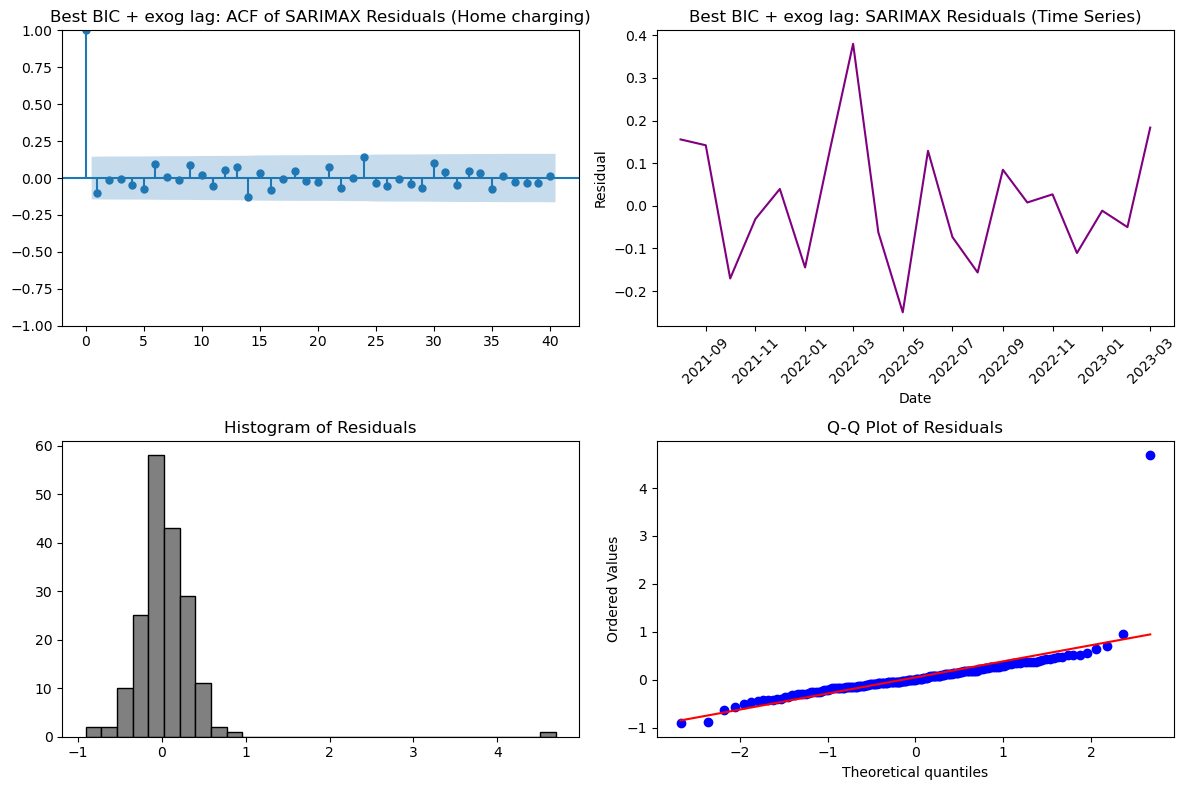

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   6.724593   0.751164
20  14.706637   0.792941
30  25.918829   0.679268


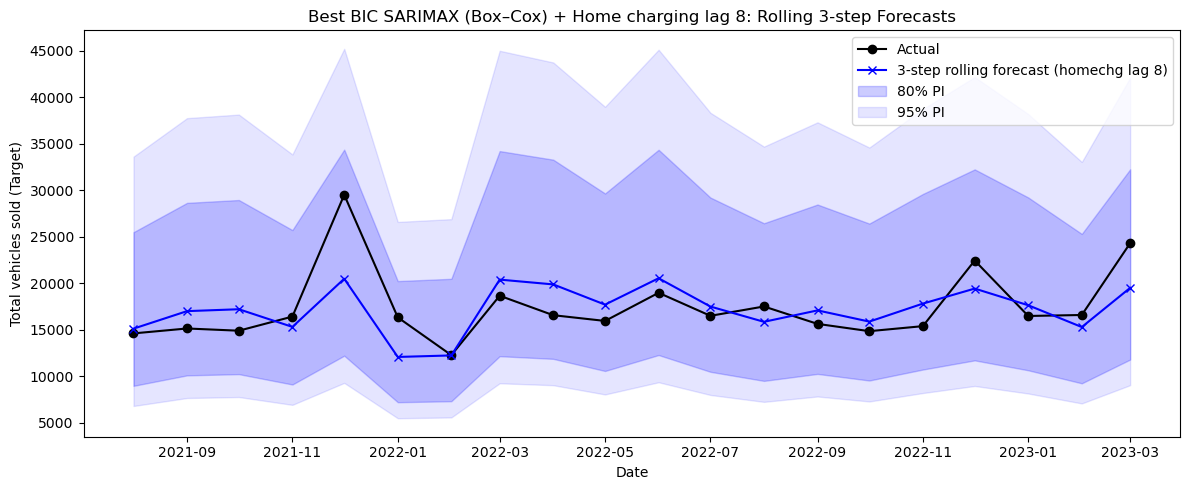

Validation RMSE (rolling): 2975.66
Validation MAE (rolling): 2262.83
Validation MAPE (rolling): 11.93%


In [24]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 8 # Optimal lag for Home Charging

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
homechg_bc_full = bc_df['Home charging (G)_bc'].values
n_train = len(train_bc)
n_val   = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_bc, val_bc[:t]])
    idx_offset = n_train + t

    homechg_hist = np.concatenate([homechg_bc_full[:n_train], homechg_bc_full[n_train:n_train+t]])
    exog_hist = make_lag(homechg_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    homechg_future = homechg_bc_full[:idx_offset + horizon]
    exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12)
        
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

# Align actuals
actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag: ACF of SARIMAX Residuals (Home charging)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (homechg lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title(f'Best BIC SARIMAX (Box–Cox) + Home charging lag {lag}: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
mae  = float(mean_absolute_error(actuals_level, preds_level))                   # NEW
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mae:.2f}")                      # NEW
print(f"Validation MAPE (rolling): {mape:.2%}")



## 7d Consumer confidence (E)

### Lag Selection

In [25]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split; Yeo–Johnson for confidence, Box–Cox for target)
# ---------------------------------------------------------------------
conf_yj_train = bc_df['Consumer confidence (E)_yj'].iloc[:train_end_bc].to_numpy(dtype=float)
y_bc_train    = bc_df['Total vehicles sold (Target)_bc'].iloc[:train_end_bc].to_numpy(dtype=float)

exog_conf = conf_yj_train
y         = y_bc_train

# ---------------------------------------------------------------------
# helper for AICc
# ---------------------------------------------------------------------
def aicc(llf, nobs, k_params):
    aic = -2 * llf + 2 * k_params
    return aic + (2 * k_params * (k_params + 1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# settings
# ---------------------------------------------------------------------
horizon = 3
max_lag = 12
allowed_lags = range(horizon, max_lag + 1)   # only safe lags (no look-ahead)

# Fixed window so every lag uses the SAME y rows
start = max_lag                 # ensures all lags up to max_lag are available
y_fix = y[start:].copy()
N = len(y_fix)

def exog_lag_aligned(exog, L, start, length):
    """Return exog aligned so at t in [start, start+length-1] we use exog[t - L]."""
    return exog[start - L : start - L + length]

# ---------------------------------------------------------------------
# Fit same-sample models across lags and collect ICs
# ---------------------------------------------------------------------
results = []
for L in allowed_lags:
    xL = exog_lag_aligned(exog_conf, L, start, N).reshape(-1, 1)

    model = SARIMAX(
        y_fix, exog=xL,
        order=(1, 1, 0),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size),
    })

# ---------------------------------------------------------------------
# Report TOP 3 by each metric + consolidated candidate set
# ---------------------------------------------------------------------
top_k = 3
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])[:top_k]
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])[:top_k]
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])[:top_k]

print("Optimal lags for Consumer confidence (E)_yj (same sample):")

print("\nTop 3 by AIC:")
for r in results_sorted_aic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by BIC:")
for r in results_sorted_bic:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nTop 3 by AICc:")
for r in results_sorted_aicc:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

candidate_lags = sorted({
    *[r["lag"] for r in results_sorted_aic],
    *[r["lag"] for r in results_sorted_bic],
    *[r["lag"] for r in results_sorted_aicc],
})
print(f"\nCandidate lags to take into rolling validation: {candidate_lags}")





Optimal lags for Consumer confidence (E)_yj (same sample):

Top 3 by AIC:
  lag= 8  AIC=48.56  BIC=60.52  AICc=48.82
  lag=11  AIC=48.93  BIC=60.89  AICc=49.19
  lag=12  AIC=49.06  BIC=61.02  AICc=49.31

Top 3 by BIC:
  lag= 8  AIC=48.56  BIC=60.52  AICc=48.82
  lag=11  AIC=48.93  BIC=60.89  AICc=49.19
  lag=12  AIC=49.06  BIC=61.02  AICc=49.31

Top 3 by AICc:
  lag= 8  AIC=48.56  BIC=60.52  AICc=48.82
  lag=11  AIC=48.93  BIC=60.89  AICc=49.19
  lag=12  AIC=49.06  BIC=61.02  AICc=49.31

Candidate lags to take into rolling validation: [8, 11, 12]


(6,10,7)

In [26]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [8, 11, 12]  # Top 3 lags from your test

# --- Data ---
train_bc = y_train_bc.values
val_bc   = y_val_bc.values
conf_yj_full = bc_df['Consumer confidence (E)_yj'].values  # Yeo–Johnson
n_train = len(train_bc)
n_val = len(val_bc)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_bc, val_bc[:t]])
        idx_offset = n_train + t

        conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(conf_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        conf_future = conf_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 0),
            seasonal_order=(0, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        bc_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
        ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
        ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
        ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

    actuals_level = inv_boxcox(val_bc[horizon-1:], lam, shift)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    mae  = float(mean_absolute_error(actuals_level, preds_level))                   # NEW
    results.append({'lag': lag, 'rmse': rmse, 'mae':mae, 'mape': mape})

    # # Plot for each lag
    # dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]
    # plt.figure(figsize=(12, 5))
    # plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    # plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    # plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    # plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    # plt.title(f'SARIMAX(0,1,1)(1,0,1,12) + Consumer Confidence lag {lag}: Rolling 3-step Forecasts')
    # plt.xlabel('Date')
    # plt.ylabel(target_raw)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    # print(f"Lag {lag}: Validation MAE  (rolling): {mae:.2f}")                      # NEW
    # print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f} MAE={r['mae']:.2f} MAPE={r['mape']:.2%}")



Summary of RMSE and MAPE for each lag:
Lag 8: RMSE=3295.98 MAE=2401.60 MAPE=13.02%
Lag 11: RMSE=3132.64 MAE=2338.00 MAPE=12.74%
Lag 12: RMSE=3213.15 MAE=2543.46 MAPE=13.44%


### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): 40.92
BIC (last SARIMAX fit): 53.69


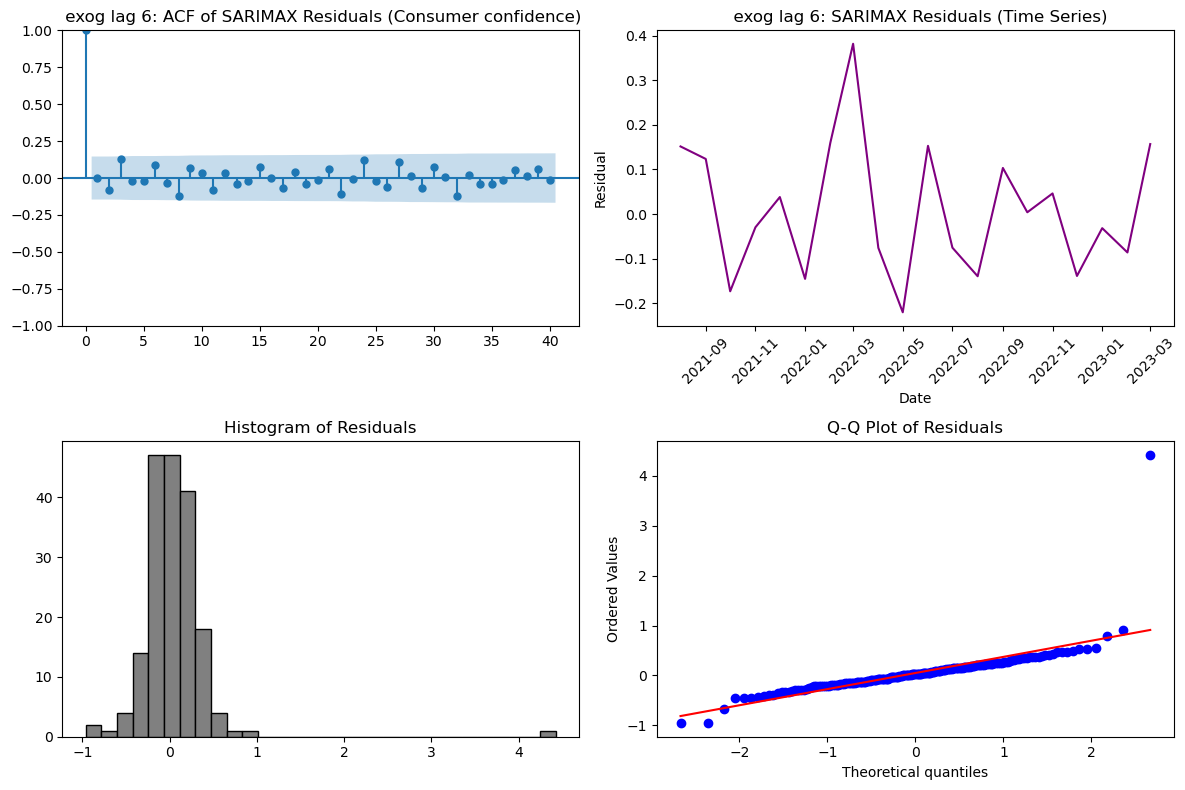

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  10.017218   0.438984
20  14.736970   0.791255
30  26.897538   0.628646


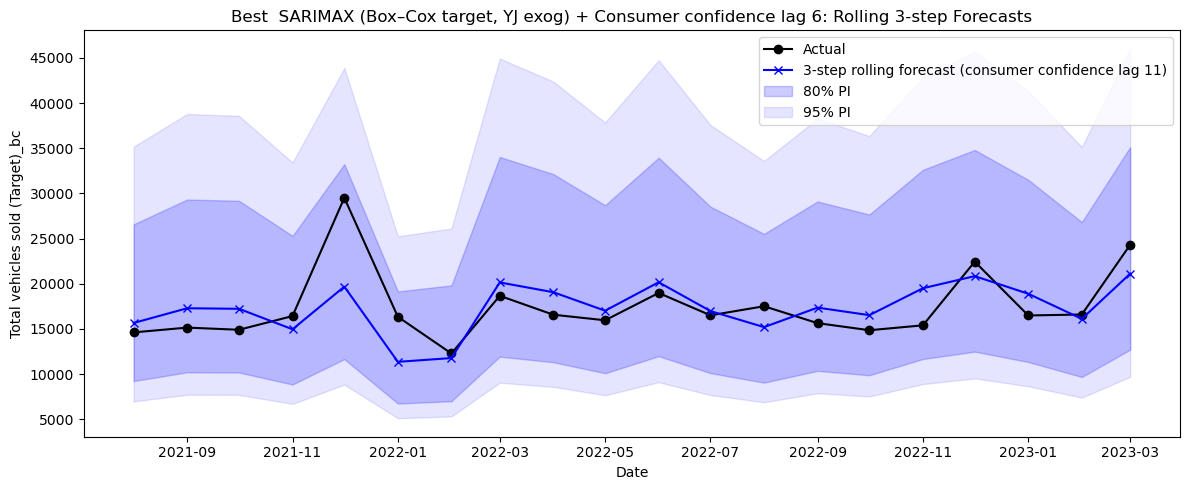

Validation RMSE (rolling): 3104.61
Validation MAE (rolling): 2323.05
Validation MAPE (rolling): 12.61%


In [27]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

horizon = 3
lag = 11

train_yj = y_train_bc.values
val_yj   = y_val_bc.values
conf_yj_full = bc_df['Consumer confidence (E)_yj'].values
n_train = len(train_yj)
n_val   = len(val_yj)
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_boxcox(z, lam, shift=0):
    if np.isclose(lam, 0):
        return np.exp(z) + shift
    else:
        return np.power(z * lam + 1, 1/lam) + shift

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(conf_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    conf_future = conf_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
    y_hist_valid,
    exog=exog_hist_valid,
    order=(1, 1, 0),
    seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    bc_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_boxcox(np.array([bc_forecast_level]), lam, shift)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_boxcox(np.array([ci80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox(np.array([ci80_u]), lam, shift)[0])
    ci95_lower.append(inv_boxcox(np.array([ci95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox(np.array([ci95_u]), lam, shift)[0])

actuals_level = inv_boxcox(val_yj[horizon-1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" exog lag 6: ACF of SARIMAX Residuals (Consumer confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("  exog lag 6: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label=f'3-step rolling forecast (consumer confidence lag {lag})')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best  SARIMAX (Box–Cox target, YJ exog) + Consumer confidence lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_bc)
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")



| Feature / Model                         | Lag | RMSE (rolling) | Δ RMSE vs Iter 1 | MAPE (rolling) | Δ MAPE vs Iter 1 | Ljung–Box p (>0.05) | Notes                                        |
| --------------------------------------- | --- | -------------: | ---------------: | -------------: | ---------------: | ------------------: | -------------------------------------------- |
| **Iteration 1 — Baseline (no exog)**    | –   |    **2972.30** |                – |     **11.95%** |                – |          All > 0.05 | Reference model.                             |
| **Benchmarks**                          |     |                |                  |                |                  |                     |                                              |
| Naive                                   | –   |     🟧 4706.88 |         ↑ 58.36% |      🟧 16.13% |         ↑ 34.98% |                 n/a | Weak baseline.                               |
| Seasonal naive                          | –   |     🟧 8676.37 |        ↑ 191.91% |      🟧 38.13% |        ↑ 219.08% |                 n/a | Much worse than all others.                  |
| Drift                                   | –   |     🟧 5071.55 |         ↑ 70.63% |      🟧 18.21% |         ↑ 52.38% |                 n/a | Worse than naive.                            |
| **ARIMA (no exog)**                     |     |                |                  |                |                  |                     |                                              |
| Auto ARIMA (0,1,2)(0,1,1)\[12]          | –   |     🟧 7012.53 |        ↑ 135.93% |      🟧 29.15% |        ↑ 143.93% |          All > 0.05 | Very poor fit.                               |
| Iteration 2 (2,1,0)(0,0,1)\[12]         | –   |     🟧 2972.85 |          ↑ 0.02% |      🟩 11.43% |          ↓ 4.35% |          All > 0.05 | Nearly identical RMSE, slightly better MAPE. |
| Iteration 3                             | –   |     🟧 3696.07 |         ↑ 24.34% |      🟧 18.57% |         ↑ 55.36% |          All > 0.05 | Large performance drop.                      |
| **With exogenous features (on Iter 1)** |     |                |                  |                |                  |                     |                                              |
| Gasoline price                          | 12  |     🟧 3255.51 |          ↑ 9.53% |      🟩 10.51% |         ↓ 12.05% |          All > 0.05 | Best MAPE improvement; RMSE worsens.         |
| Company car tax rate                    | 11  |     🟩 2919.55 |          ↓ 1.77% |      🟩 11.84% |          ↓ 0.92% |          All > 0.05 | Best RMSE; minor MAPE gain.                  |
| Home charging (Google Trends)           | 8   |     🟧 2975.66 |          ↑ 0.11% |      🟩 11.93% |          ↓ 0.17% |          All > 0.05 | Essentially same as baseline.                |
| Consumer confidence                     | 11  |     🟧 3104.61 |          ↑ 4.45% |      🟧 12.61% |          ↑ 5.52% |          All > 0.05 | Worse in both metrics.                       |


| Feature / Model                         | Lag | RMSE (rolling) | Δ RMSE vs Iter 1 | MAPE (rolling) | Δ MAPE vs Iter 1 | Ljung–Box p (>0.05) | Notes                                        |
| --------------------------------------- | --- | -------------: | ---------------: | -------------: | ---------------: | ------------------: | -------------------------------------------- |
| **Iteration 1 — Baseline (no exog)**    | –   |    **2972.30** |                – |     **11.95%** |                – |          All > 0.05 | Reference model.                             |
| **Benchmarks**                          |     |                |                  |                |                  |                     |                                              |
| Naive                                   | –   |     🟧 4706.88 |         ↑ 58.36% |      🟧 16.13% |         ↑ 34.98% |                 n/a | Weak baseline.                               |
| Seasonal naive                          | –   |     🟧 8676.37 |        ↑ 191.91% |      🟧 38.13% |        ↑ 219.08% |                 n/a | Much worse than all others.                  |
| Drift                                   | –   |     🟧 5071.55 |         ↑ 70.63% |      🟧 18.21% |         ↑ 52.38% |                 n/a | Worse than naive.                            |
| **ARIMA (no exog)**                     |     |                |                  |                |                  |                     |                                              |
| Auto ARIMA (0,1,2)(0,1,1)\[12]          | –   |     🟧 7012.53 |        ↑ 135.93% |      🟧 29.15% |        ↑ 143.93% |          All > 0.05 | Very poor fit.                               |
| Iteration 2 (2,1,0)(0,0,1)\[12]         | –   |     🟧 2972.85 |          ↑ 0.02% |      🟩 11.43% |          ↓ 4.35% |          All > 0.05 | Nearly identical RMSE, slightly better MAPE. |
| Iteration 3                             | –   |     🟧 3696.07 |         ↑ 24.34% |      🟧 18.57% |         ↑ 55.36% |          All > 0.05 | Large performance drop.                      |
| **With exogenous features (on Iter 1)** |     |                |                  |                |                  |                     |                                              |
| Gasoline price                          | 12  |     🟧 3255.51 |          ↑ 9.53% |      🟩 10.51% |         ↓ 12.05% |          All > 0.05 | Best MAPE improvement; RMSE worsens.         |
| Company car tax rate                    | 11  |     🟩 2919.55 |          ↓ 1.77% |      🟩 11.84% |          ↓ 0.92% |          All > 0.05 | Best RMSE; minor MAPE gain.                  |
| Home charging (Google Trends)           | 8   |     🟧 2975.66 |          ↑ 0.11% |      🟩 11.93% |          ↓ 0.17% |          All > 0.05 | Essentially same as baseline.                |
| Consumer confidence                     | 11  |     🟧 3104.61 |          ↑ 4.45% |      🟧 12.61% |          ↑ 5.52% |          All > 0.05 | Worse in both metrics.                       |


so going forward with: 
gasoline, company car tax rate, home charging,


| Feature / Model                         | Lag | RMSE (rolling) | Δ RMSE vs Iter 1 | MAPE (rolling) | Δ MAPE vs Iter 1 | Ljung–Box p (>0.05) | Notes                                        |
| --------------------------------------- | --- | -------------: | ---------------: | -------------: | ---------------: | ------------------: | -------------------------------------------- |
| **Iteration 1 — Baseline (no exog)**    | –   |    **2972.30** |                – |     **11.95%** |                – |          All > 0.05 | Reference model.                             |
| **Benchmarks**                          |     |                |                  |                |                  |                     |                                              |
| Naive                                   | –   |     🟧 4706.88 |         ↑ 58.36% |      🟧 16.13% |         ↑ 34.98% |                 n/a | Weak baseline.                               |
| Seasonal naive                          | –   |     🟧 8676.37 |        ↑ 191.91% |      🟧 38.13% |        ↑ 219.08% |                 n/a | Much worse than all others.                  |
| Drift                                   | –   |     🟧 5071.55 |         ↑ 70.63% |      🟧 18.21% |         ↑ 52.38% |                 n/a | Worse than naive.                            |
| **ARIMA (no exog)**                     |     |                |                  |                |                  |                     |                                              |
| Auto ARIMA (0,1,2)(0,1,1)\[12]          | –   |     🟧 7012.53 |        ↑ 135.93% |      🟧 29.15% |        ↑ 143.93% |          All > 0.05 | Very poor fit.                               |
| Iteration 2 (2,1,0)(0,0,1)\[12]         | –   |     🟧 2972.85 |          ↑ 0.02% |      🟩 11.43% |          ↓ 4.35% |          All > 0.05 | Nearly identical RMSE, slightly better MAPE. |
| Iteration 3                             | –   |     🟧 3696.07 |         ↑ 24.34% |      🟧 18.57% |         ↑ 55.36% |          All > 0.05 | Large performance drop.                      |
| **With exogenous features (on Iter 1)** |     |                |                  |                |                  |                     |                                              |
| Gasoline price                          | 12  |     🟧 3255.51 |          ↑ 9.53% |      🟩 10.51% |         ↓ 12.05% |          All > 0.05 | Best MAPE improvement; RMSE worsens.         |
| Company car tax rate                    | 11  |     🟩 2919.55 |          ↓ 1.77% |      🟩 11.84% |          ↓ 0.92% |          All > 0.05 | Best RMSE; minor MAPE gain.                  |
| Home charging (Google Trends)           | 8   |     🟧 2975.66 |          ↑ 0.11% |      🟩 11.93% |          ↓ 0.17% |          All > 0.05 | Essentially same as baseline.                |
| Consumer confidence                     | 11  |     🟧 3104.61 |          ↑ 4.45% |      🟧 12.61% |          ↑ 5.52% |          All > 0.05 | Worse in both metrics.                       |


# 8 All features together/ turn this into top features together

AIC (last fit): 36.74
BIC (last fit): 55.86


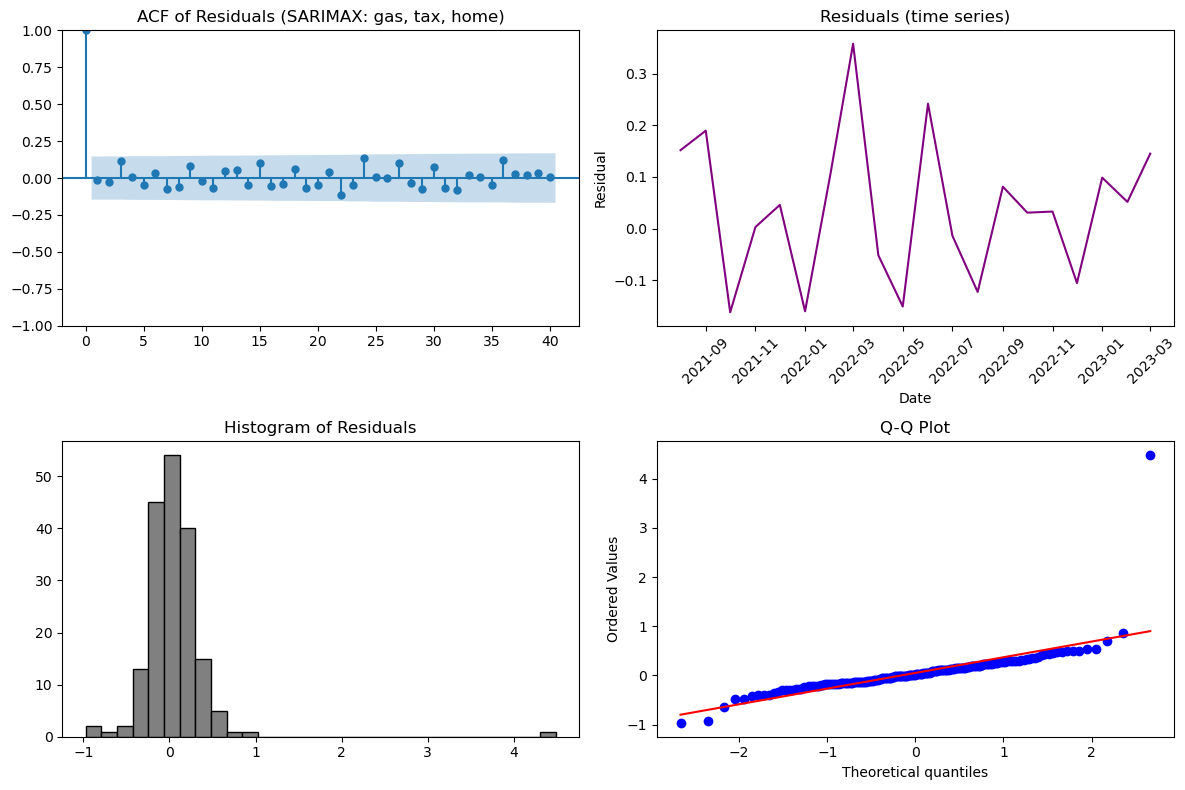

Ljung-Box (p>0.05 is good):
      lb_stat  lb_pvalue
10   6.460952   0.775165
20  13.761694   0.842370
30  25.631539   0.693798


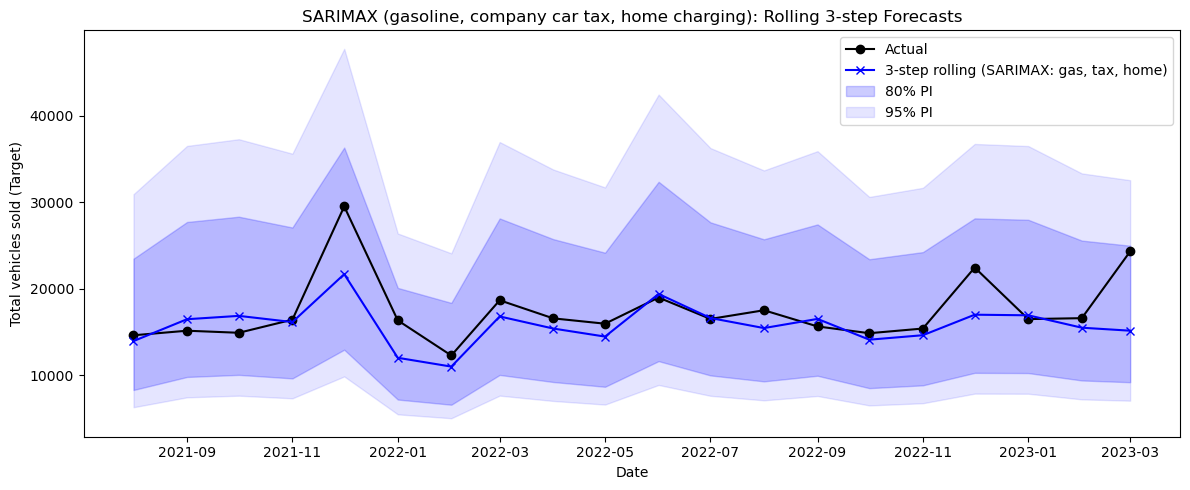

Validation RMSE (rolling): 3288.61
Validation MAE  (rolling): 2166.60
Validation MAPE (rolling): 10.98%


In [28]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
warnings.filterwarnings("ignore")

# --------------------
# Settings & helpers
# --------------------
horizon = 3
lags = {
    "gas": 12,         # Gasoline (Euro95) lag
    "companytax": 11,  # Company car tax lag
    "homechg": 8,      # Google Trends: Home charging lag
}
assert all(L >= horizon for L in lags.values()), "All lags must be >= horizon to avoid look-ahead."

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    if lag > 0:
        out[:lag] = np.nan
    return out

def inv_boxcox_with_shift(z, lam, shift):
    z = np.asarray(z, dtype=float)
    if np.isclose(lam, 0.0):
        y = np.exp(z)
    else:
        y = np.power(lam * z + 1.0, 1.0 / lam)
    return y - shift

# --------------------
# Grab target & exogs (transformed space)
# --------------------
y_train_bc_arr = y_train_bc.to_numpy()
y_val_bc_arr   = y_val_bc.to_numpy()
n_train = len(y_train_bc_arr); n_val = len(y_val_bc_arr)

def pick_col(df, needle):
    cols = [c for c in df.columns if needle.lower() in c.lower()]
    assert len(cols) >= 1, f"Column containing '{needle}' not found in bc_df."
    return cols[0]

col_gas   = pick_col(bc_df, "Gasoline")
col_tax   = pick_col(bc_df, "Company car tax rate")
col_home  = pick_col(bc_df, "Home charging")

gas_full   = bc_df[col_gas].to_numpy()
tax_full   = bc_df[col_tax].to_numpy()
home_full  = bc_df[col_home].to_numpy()

# Box–Cox params for target inverse-transform
lam = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

# --------------------
# Rolling-origin with multiple exogs + distinct lags (3 features)
# --------------------
preds_level, ci80_lower, ci80_upper, ci95_lower, ci95_upper = [], [], [], [], []
last_fit = None

for t in range(n_val - horizon + 1):
    # target history up to origin t (train + revealed val)
    y_hist = np.concatenate([y_train_bc_arr, y_val_bc_arr[:t]])
    idx_offset = n_train + t

    # build exog histories (same length as y_hist) then lag each feature by its own L
    def hist(full):
        return np.concatenate([full[:n_train], full[n_train:n_train + t]])

    hist_gas  = make_lag(hist(gas_full),  lags["gas"])
    hist_tax  = make_lag(hist(tax_full),  lags["companytax"])
    hist_home = make_lag(hist(home_full), lags["homechg"])

    exog_hist = np.column_stack([hist_gas, hist_tax, hist_home])
    valid = ~np.isnan(exog_hist).any(axis=1)
    y_hist_valid    = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    # future exog for steps=horizon: take up to idx_offset + horizon, then lag & slice last horizon
    def fut(full, L):
        arr = make_lag(full[:idx_offset + horizon], L)
        return arr[-horizon:]

    exog_future = np.column_stack([
        fut(gas_full,  lags["gas"]),
        fut(tax_full,  lags["companytax"]),
        fut(home_full, lags["homechg"]),
    ])

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(1, 1, 0),             # ARIMA(1,1,0)
        seasonal_order=(0, 0, 1, 12) # seasonal MA(1), m=12
    )
    res = model.fit(disp=False)
    last_fit = res

    fc = res.get_forecast(steps=horizon, exog=exog_future)
    bc_point = fc.predicted_mean[-1]

    ci80 = fc.conf_int(alpha=0.20)[-1]
    ci95 = fc.conf_int(alpha=0.05)[-1]
    lo80, hi80 = ci80[0], ci80[1]
    lo95, hi95 = ci95[0], ci95[1]

    # invert to original scale
    preds_level.append(inv_boxcox_with_shift([bc_point], lam, shift)[0])
    ci80_lower.append(inv_boxcox_with_shift([lo80], lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift([hi80], lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift([lo95], lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift([hi95], lam, shift)[0])

# --------------------
# Evaluation & plots
# --------------------
actuals_level = inv_boxcox_with_shift(y_val_bc_arr[horizon - 1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

print(f"AIC (last fit): {last_fit.aic:.2f}")
print(f"BIC (last fit): {last_fit.bic:.2f}")

# residual diagnostics on last fit
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(last_fit.resid, ax=axes[0][0], lags=40)
axes[0][0].set_title("ACF of Residuals (SARIMAX: gas, tax, home)")

axes[0][1].plot(plot_dates, last_fit.resid[-len(plot_dates):], color='purple')
axes[0][1].set_title("Residuals (time series)")
axes[0][1].set_xlabel("Date"); axes[0][1].set_ylabel("Residual"); axes[0][1].tick_params(axis='x', rotation=45)

axes[1][0].hist(last_fit.resid, bins=30, color='gray', edgecolor='black')
axes[1][0].set_title("Histogram of Residuals")
stats.probplot(last_fit.resid, dist="norm", plot=axes[1][1])
axes[1][1].set_title("Q-Q Plot")
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(last_fit.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (p>0.05 is good):")
print(lb[['lb_stat','lb_pvalue']])

# rolling forecast plot
plt.figure(figsize=(12,5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue',
         label='3-step rolling (SARIMAX: gas, tax, home)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (gasoline, company car tax, home charging): Rolling 3-step Forecasts')
plt.xlabel('Date'); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()

# metrics
rmse = float(np.sqrt(mean_squared_error(actuals_level, preds_level)))
mae  = float(mean_absolute_error(actuals_level, preds_level))
mape = float(mean_absolute_percentage_error(actuals_level, preds_level))
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE  (rolling): {mae:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


In [29]:
# import warnings
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.stats.diagnostic import acorr_ljungbox
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# import scipy.stats as stats
# warnings.filterwarnings("ignore")

# # --------------------
# # Settings & helpers
# # --------------------
# horizon = 3
# lags = {
#     "gas": 7,         # Gasoline
#     "companytax": 6,   # Company car tax
#     "homechg": 7,      # Google Trends: Home charging
#     "conf": 6,         # Consumer confidence (YJ)
# }
# assert all(L >= horizon for L in lags.values()), "All lags must be >= horizon to avoid look-ahead."

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     if lag > 0:
#         out[:lag] = np.nan
#     return out

# def inv_boxcox_with_shift(z, lam, shift):
#     z = np.asarray(z, dtype=float)
#     if np.isclose(lam, 0.0):
#         y = np.exp(z)
#     else:
#         y = np.power(lam * z + 1.0, 1.0 / lam)
#     return y - shift

# # --------------------
# # Grab target & exogs (transformed space)
# # --------------------
# y_train_bc_arr = y_train_bc.to_numpy()
# y_val_bc_arr   = y_val_bc.to_numpy()
# n_train = len(y_train_bc_arr); n_val = len(y_val_bc_arr)

# # Robust column pickers
# def pick_col(df, needle):
#     cols = [c for c in df.columns if needle.lower() in c.lower()]
#     assert len(cols) >= 1, f"Column containing '{needle}' not found in bc_df."
#     return cols[0]

# col_gas   = pick_col(bc_df, "Gasoline")
# col_tax   = pick_col(bc_df, "Company car tax rate")
# col_home  = pick_col(bc_df, "Home charging")
# col_conf  = pick_col(bc_df, "consumer confidence")

# gas_full   = bc_df[col_gas].to_numpy()
# tax_full   = bc_df[col_tax].to_numpy()
# home_full  = bc_df[col_home].to_numpy()
# conf_full  = bc_df[col_conf].to_numpy()   # Yeo–Johnson already

# # Box–Cox params for target inverse-transform
# lam = boxcox_lambdas_all[target_raw]
# shift = boxcox_shifts_all[target_raw]

# # --------------------
# # Rolling-origin with multiple exogs + distinct lags
# # --------------------
# preds_level, ci80_lower, ci80_upper, ci95_lower, ci95_upper = [], [], [], [], []
# last_fit = None

# for t in range(n_val - horizon + 1):
#     # target history up to origin t (train + revealed val)
#     y_hist = np.concatenate([y_train_bc_arr, y_val_bc_arr[:t]])
#     idx_offset = n_train + t

#     # build exog histories (same length as y_hist) then lag each feature by its own L
#     def hist(full):
#         return np.concatenate([full[:n_train], full[n_train:n_train + t]])

#     hist_gas  = make_lag(hist(gas_full),  lags["gas"])
#     hist_tax  = make_lag(hist(tax_full),  lags["companytax"])
#     hist_home = make_lag(hist(home_full), lags["homechg"])
#     hist_conf = make_lag(hist(conf_full), lags["conf"])

#     exog_hist = np.column_stack([hist_gas, hist_tax, hist_home, hist_conf])
#     valid = ~np.isnan(exog_hist).any(axis=1)
#     y_hist_valid   = y_hist[valid]
#     exog_hist_valid = exog_hist[valid]

#     # future exog for steps=horizon: take up to idx_offset + horizon, then lag & slice last horizon
#     def fut(full, L):
#         arr = make_lag(full[:idx_offset + horizon], L)
#         return arr[-horizon:]

#     exog_future = np.column_stack([
#         fut(gas_full,  lags["gas"]),
#         fut(tax_full,  lags["companytax"]),
#         fut(home_full, lags["homechg"]),
#         fut(conf_full, lags["conf"]),
#     ])

#     model = SARIMAX(
#         y_hist_valid,
#         exog=exog_hist_valid,
#         order=(1, 1, 0),            # your chosen baseline ARIMA(1,1,0)
#         seasonal_order=(0, 0, 1, 12) # + seasonal MA(1) with m=12
#     )
#     res = model.fit(disp=False)
#     last_fit = res

#     fc = res.get_forecast(steps=horizon, exog=exog_future)
#     bc_point = fc.predicted_mean[-1]

#     ci80 = fc.conf_int(alpha=0.20)[-1]
#     ci95 = fc.conf_int(alpha=0.05)[-1]
#     lo80, hi80 = ci80[0], ci80[1]
#     lo95, hi95 = ci95[0], ci95[1]

   

#     # invert to original scale
#     preds_level.append(inv_boxcox_with_shift([bc_point], lam, shift)[0])
#     ci80_lower.append(inv_boxcox_with_shift([lo80], lam, shift)[0])
#     ci80_upper.append(inv_boxcox_with_shift([hi80], lam, shift)[0])
#     ci95_lower.append(inv_boxcox_with_shift([lo95], lam, shift)[0])
#     ci95_upper.append(inv_boxcox_with_shift([hi95], lam, shift)[0])

# # --------------------
# # Evaluation & plots
# # --------------------
# actuals_level = inv_boxcox_with_shift(y_val_bc_arr[horizon - 1:], lam, shift)
# plot_dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds_level)]

# print(f"AIC (last fit): {last_fit.aic:.2f}")
# print(f"BIC (last fit): {last_fit.bic:.2f}")

# # residual diagnostics on last fit
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# plot_acf(last_fit.resid, ax=axes[0][0], lags=40)
# axes[0][0].set_title("ACF of Residuals (all exogs)")

# axes[0][1].plot(plot_dates, last_fit.resid[-len(plot_dates):], color='purple')
# axes[0][1].set_title("Residuals (time series)")
# axes[0][1].set_xlabel("Date"); axes[0][1].set_ylabel("Residual"); axes[0][1].tick_params(axis='x', rotation=45)

# axes[1][0].hist(last_fit.resid, bins=30, color='gray', edgecolor='black')
# axes[1][0].set_title("Histogram of Residuals")
# stats.probplot(last_fit.resid, dist="norm", plot=axes[1][1])
# axes[1][1].set_title("Q-Q Plot")
# plt.tight_layout(); plt.show()

# lb = acorr_ljungbox(last_fit.resid, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box (p>0.05 is good):")
# print(lb[['lb_stat','lb_pvalue']])

# # rolling forecast plot
# plt.figure(figsize=(12,5))
# plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
# plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling (all exogs, distinct lags)')
# plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
# plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
# plt.title('SARIMAX + All Exogenous Features (distinct lags): Rolling 3-step Forecasts')
# plt.xlabel('Date'); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()

# # metrics
# rmse = float(np.sqrt(mean_squared_error(actuals_level, preds_level)))
# mae  = float(mean_absolute_error(actuals_level, preds_level))
# mape = float(mean_absolute_percentage_error(actuals_level, preds_level))
# print(f"Validation RMSE (rolling): {rmse:.2f}")
# print(f"Validation MAE  (rolling): {mae:.2f}")
# print(f"Validation MAPE (rolling): {mape:.2%}")



| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |

| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |


| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |




**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

# 6 Finaist models on TEST
Plot/evaluate with target value on test

### Benchmark models


Naïve (h=3)   → RMSE: 4659.97  MAE: 3508.10  MAPE: 12.14%
Seasonal Naïve → RMSE: 8500.25  MAE: 7454.85  MAPE: 26.82%
Drift          → RMSE: 4365.68  MAE: 3628.32  MAPE: 13.51%


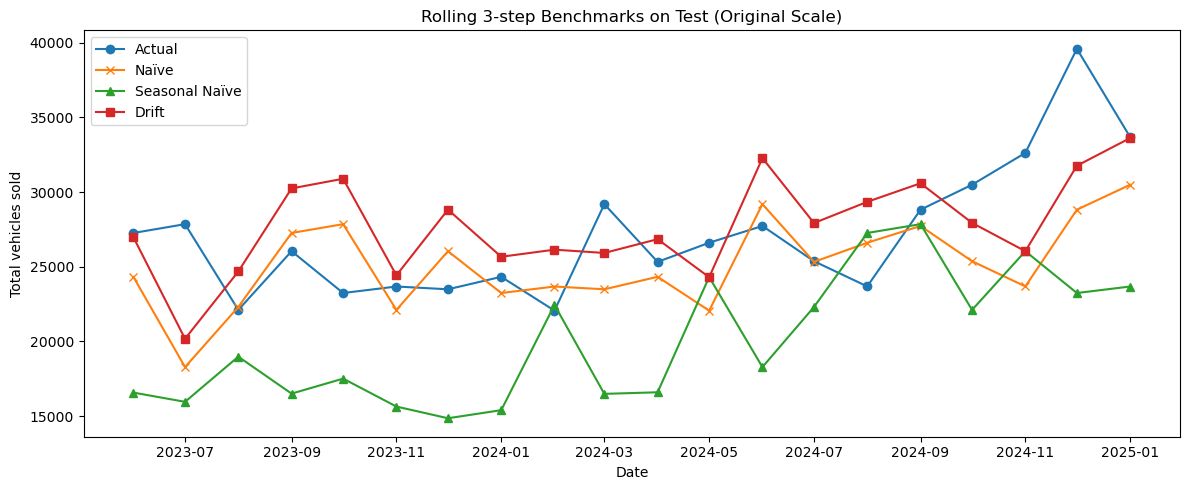

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

horizon = 3
season_length = 12

# Box–Cox data (already transformed earlier)
train_bc = y_train_bc.to_numpy()
val_bc   = y_val_bc.to_numpy()
test_bc  = y_test_bc.to_numpy()

# Inverse Box–Cox for evaluation
lam   = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]
def inv_boxcox(z, lam, shift=0):
    z = np.asarray(z, dtype=float)
    return (np.exp(z) if np.isclose(lam, 0) else np.power(z * lam + 1, 1/lam)) + shift

# Pre-allocate
n_test = len(test_bc)
n_steps = n_test - horizon + 1
naive_preds_bc        = np.empty(n_steps)
seasonal_naive_preds_bc = np.empty(n_steps)
drift_preds_bc        = np.empty(n_steps)

# Rolling origin across the test window
hist_bc_full = np.concatenate([train_bc, val_bc])  # starting history (Box–Cox)
for t in range(n_steps):
    # history up to forecast origin (includes the first t test points)
    hist_bc = np.concatenate([hist_bc_full, test_bc[:t]])
    n_hist  = len(hist_bc)
    y_t     = hist_bc[-1]                 # last observed value at origin

    # 1) Naïve h-step: use last observed value
    naive_preds_bc[t] = y_t

    # 2) Seasonal naïve h-step: use value from 1 season back
    if n_hist >= season_length:
        seasonal_naive_preds_bc[t] = hist_bc[-season_length]
    else:
        # not enough seasonal history yet -> fall back to naïve
        seasonal_naive_preds_bc[t] = y_t

    # 3) Drift h-step (classical): y_{t+h|t} = y_t + h * (y_t - y_1)/(t_idx)
    # where t_idx = n_hist - 1 (distance from first to last obs)
    if n_hist > 1:
        t_idx = n_hist - 1
        drift_preds_bc[t] = y_t + horizon * (y_t - hist_bc[0]) / t_idx
    else:
        drift_preds_bc[t] = y_t  # degenerate fallback

# Actuals aligned to horizon
actuals_bc   = test_bc[horizon-1:]

# Back to original scale
actuals      = inv_boxcox(actuals_bc, lam, shift)
naive_preds  = inv_boxcox(naive_preds_bc, lam, shift)
seasonal_preds = inv_boxcox(seasonal_naive_preds_bc, lam, shift)
drift_preds  = inv_boxcox(drift_preds_bc, lam, shift)

# Metrics
def metrics(y_true, y_pred):
    return (np.sqrt(mean_squared_error(y_true, y_pred)),
            mean_absolute_error(y_true, y_pred),
            mean_absolute_percentage_error(y_true, y_pred))

na_rmse, na_mae, na_mape         = metrics(actuals, naive_preds)
sn_rmse, sn_mae, sn_mape         = metrics(actuals, seasonal_preds)
dr_rmse, dr_mae, dr_mape         = metrics(actuals, drift_preds)

print(f"Naïve (h=3)   → RMSE: {na_rmse:.2f}  MAE: {na_mae:.2f}  MAPE: {na_mape:.2%}")
print(f"Seasonal Naïve → RMSE: {sn_rmse:.2f}  MAE: {sn_mae:.2f}  MAPE: {sn_mape:.2%}")
print(f"Drift          → RMSE: {dr_rmse:.2f}  MAE: {dr_mae:.2f}  MAPE: {dr_mape:.2%}")

# Dates for plotting
x_dates_test = df["Time Period (T)"].iloc[val_end_bc + horizon - 1 : test_end_bc]

plt.figure(figsize=(12,5))
plt.plot(x_dates_test, actuals, label='Actual', marker='o')
plt.plot(x_dates_test, naive_preds, label='Naïve', marker='x')
plt.plot(x_dates_test, seasonal_preds, label='Seasonal Naïve', marker='^')
plt.plot(x_dates_test, drift_preds, label='Drift', marker='s')
plt.title('Rolling 3-step Benchmarks on Test (Original Scale)')
plt.xlabel('Date'); plt.ylabel('Total vehicles sold'); plt.legend(); plt.tight_layout(); plt.show()


RMSE and MAPE are notably higher on the test set than on validation. This means the model predicts less accurately on the test data, which is a common and expected phenomenon — models usually perform best on data they have been tuned on or similar to training data.

The jump from ~2400 RMSE to ~5800 RMSE is substantial, suggesting the test set may be more challenging or different in distribution than training/validation, or that the model has some overfitting on validation data.

AIC and BIC values are more negative on the test set, indicating better fit statistics numerically. However, AIC/BIC focus on likelihood penalized by parameters and do not directly reflect predictive performance on new data, so these should be interpreted with caution when comparing train/validation/test.

Ljung-Box tests mostly indicate no strong autocorrelation left in residuals (good), although the p-value for lag 20 on test is just below 0.05, suggesting a slight concern for autocorrelation at that lag.

Q-Q plot, histogram, and residual plots (from the images) suggest residuals are reasonably normal with some outliers.

> #### 1. Baseline model (no exog)
ARIMA(1,1,0)(0,0,1)[12]

Serves as the main benchmark for model improvement.

Lets you clearly state whether exog features improve performance out-of-sample.

AIC (last SARIMAX fit): 50.37
BIC (last SARIMAX fit): 60.46


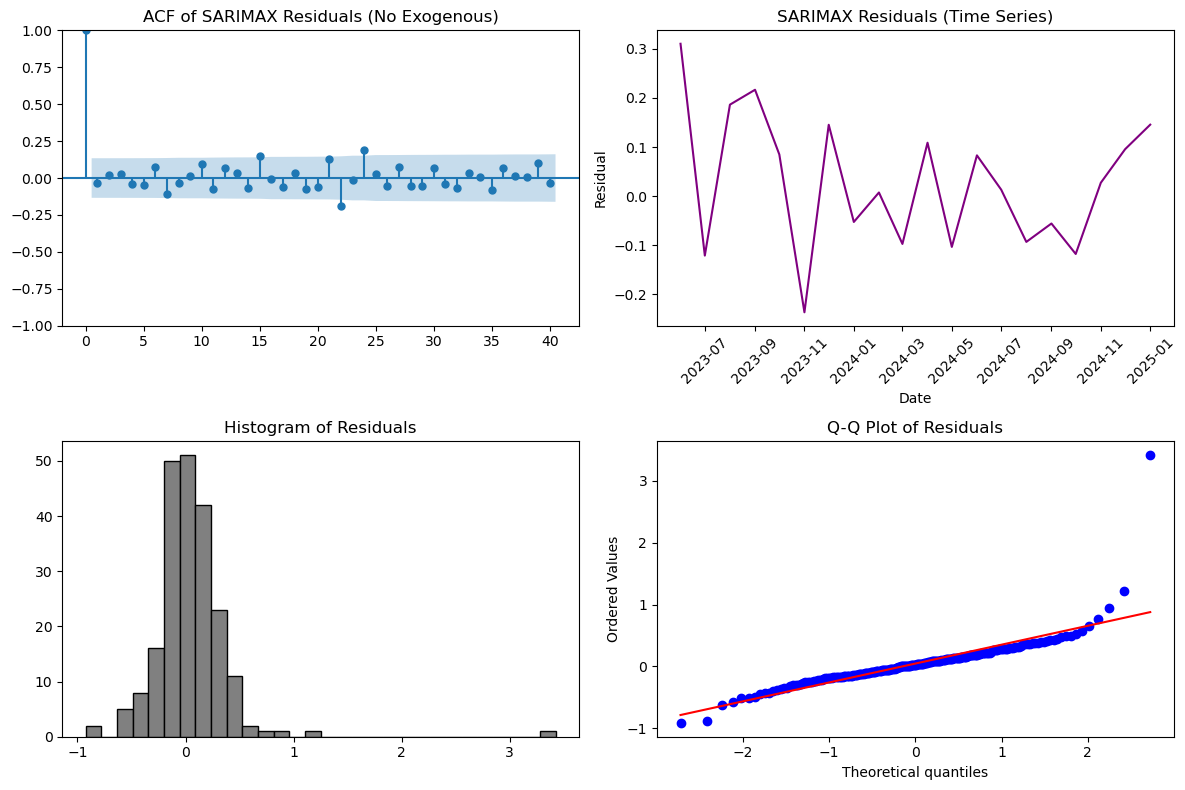

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   7.470821   0.680373
20  19.539598   0.487041
30  45.549857   0.034284


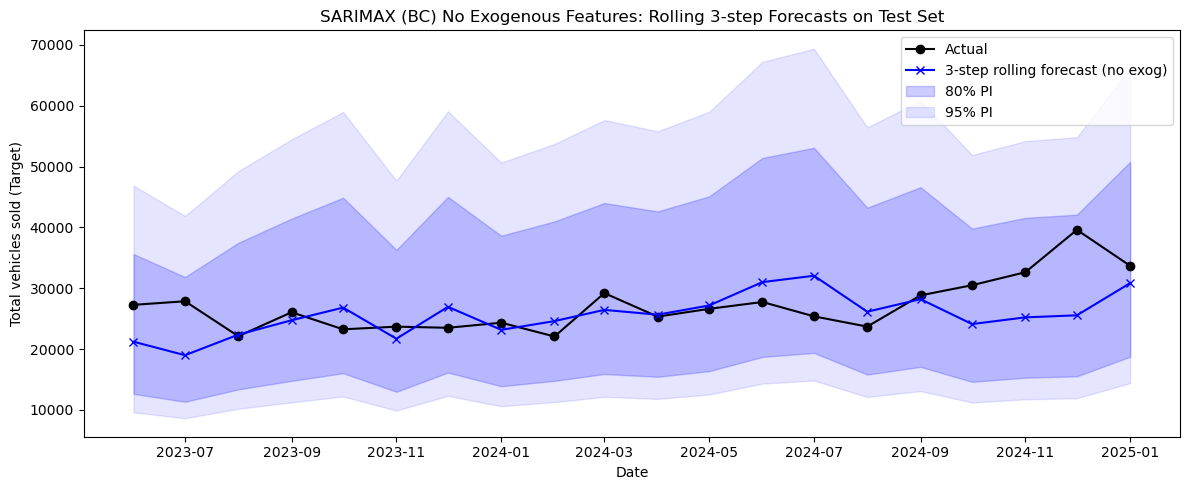

Validation RMSE (rolling): 5121.52
Validation MAE (rolling): 3827.06
Validation MAPE (rolling): 13.30%


In [31]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats
import pandas as pd
warnings.filterwarnings("ignore")

# === Settings ===
horizon = 3

# --- Use BC-transformed train/val/test arrays ---
train_val_bc = np.concatenate([y_train_bc.values, y_val_bc.values])
test_bc      = y_test_bc.values

lam   = boxcox_lambdas_all[target_raw]      # Box–Cox lambda for target
shift = boxcox_shifts_all[target_raw]       # <- include the shift you used during BC fit

# --- Inverse Box–Cox (with shift) ---
def inv_boxcox_with_shift(z, lam, shift):
    if np.isclose(lam, 0):
        x = np.exp(z)
    else:
        x = (lam * z + 1.0) ** (1.0 / lam)
    return x - shift

# --- Store forecasts and intervals ---
preds_level = []
ci80_lower, ci80_upper = [], []
ci95_lower, ci95_upper = [], []

for t in range(len(test_bc) - horizon + 1):
    # History = train+val + partial test history
    y_hist = np.concatenate([train_val_bc, test_bc[:t]])

    # Fit SARIMAX model without exog
    model = SARIMAX(
        y_hist,
        order=(1, 1, 0),                 # Iteration 1: ARIMA(1,1,0)
        seasonal_order=(0, 0, 1, 12)
    )
    fitted = model.fit(disp=False)

    # Forecast next horizon steps
    fc = fitted.get_forecast(steps=horizon)
    bc_point = fc.predicted_mean[-1]

    # Confidence intervals (DataFrame) -> take last row and split to lo/hi
    ci80_arr = fc.conf_int(alpha=0.20)
    ci95_arr = fc.conf_int(alpha=0.05)
    
    lo80, hi80 = ci80_arr[-1, 0], ci80_arr[-1, 1]
    lo95, hi95 = ci95_arr[-1, 0], ci95_arr[-1, 1]
    # Back-transform to original scale
    preds_level.append(inv_boxcox_with_shift(np.array([bc_point]), lam, shift)[0])
    ci80_lower.append(inv_boxcox_with_shift(np.array([lo80]), lam, shift)[0])
    ci80_upper.append(inv_boxcox_with_shift(np.array([hi80]), lam, shift)[0])
    ci95_lower.append(inv_boxcox_with_shift(np.array([lo95]), lam, shift)[0])
    ci95_upper.append(inv_boxcox_with_shift(np.array([hi95]), lam, shift)[0])

# --- Actuals in original scale ---
actuals_level = inv_boxcox_with_shift(test_bc[horizon - 1:], lam, shift)
plot_dates = df["Time Period (T)"].iloc[val_end_bc + horizon - 1 : test_end_bc][:len(preds_level)]

# === Diagnostics (from the last fit) ===
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (No Exogenous)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date"); axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# === Plot predictions ===
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (no exog)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (BC) No Exogenous Features: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date'); plt.ylabel(target_raw)
plt.legend(); plt.tight_layout(); plt.show()

# === Metrics ===
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mean_absolute_error = mean_absolute_error(actuals_level, preds_level)
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAE (rolling): {mean_absolute_error:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


### All exog features combined



Baseline ARIMA(1,1,0)(0,0,1)[12] — Test (rolling origin, h=3)
RMSE: 5121.52  MAE: 3827.06  MAPE: 13.30%


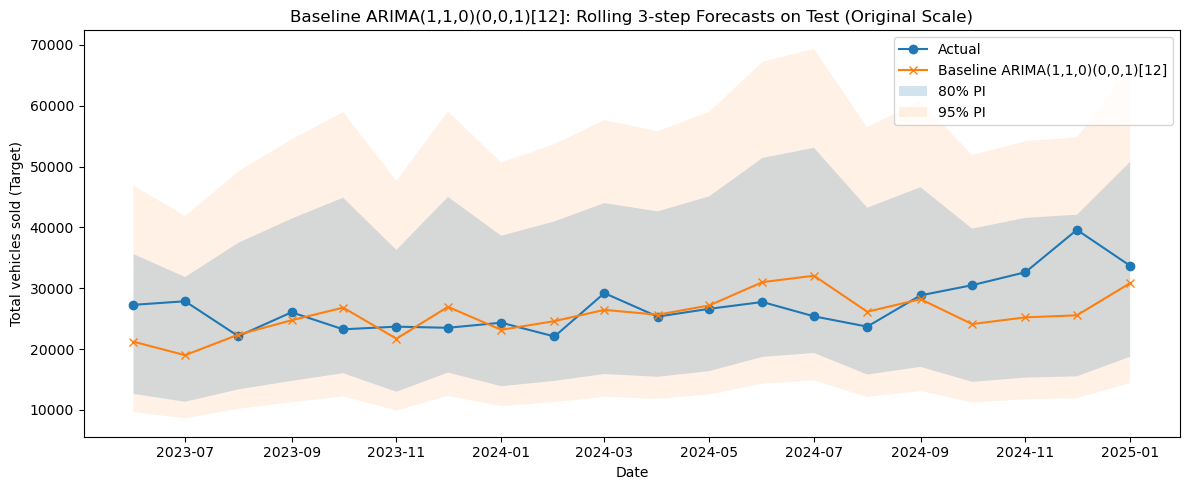

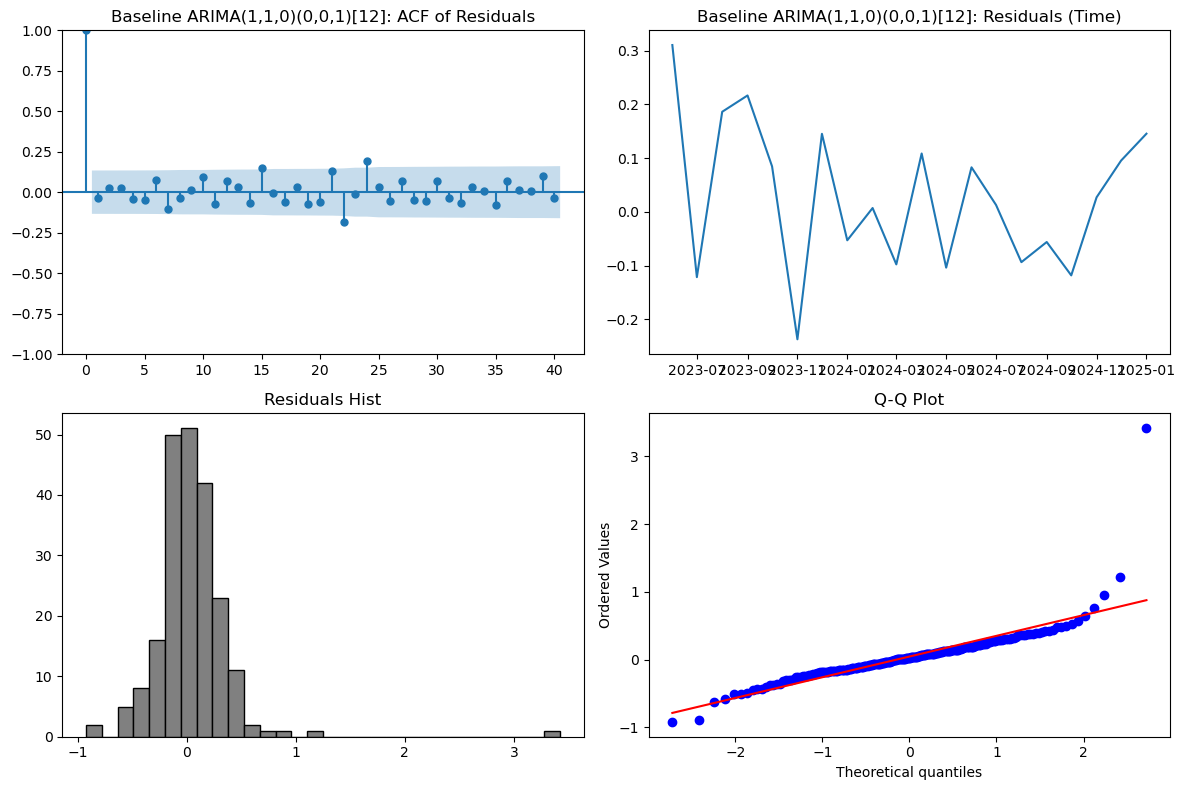

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   7.470821   0.680373
20  19.539598   0.487041
30  45.549857   0.034284

Gasoline (lag 12) — Test (rolling origin, h=3)
RMSE: 5263.10  MAE: 3967.44  MAPE: 13.90%


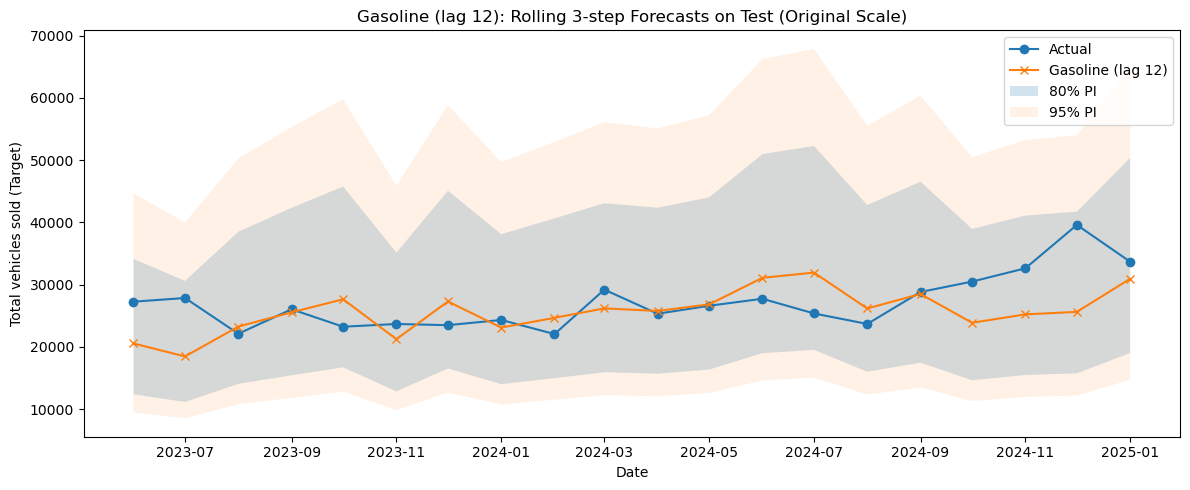

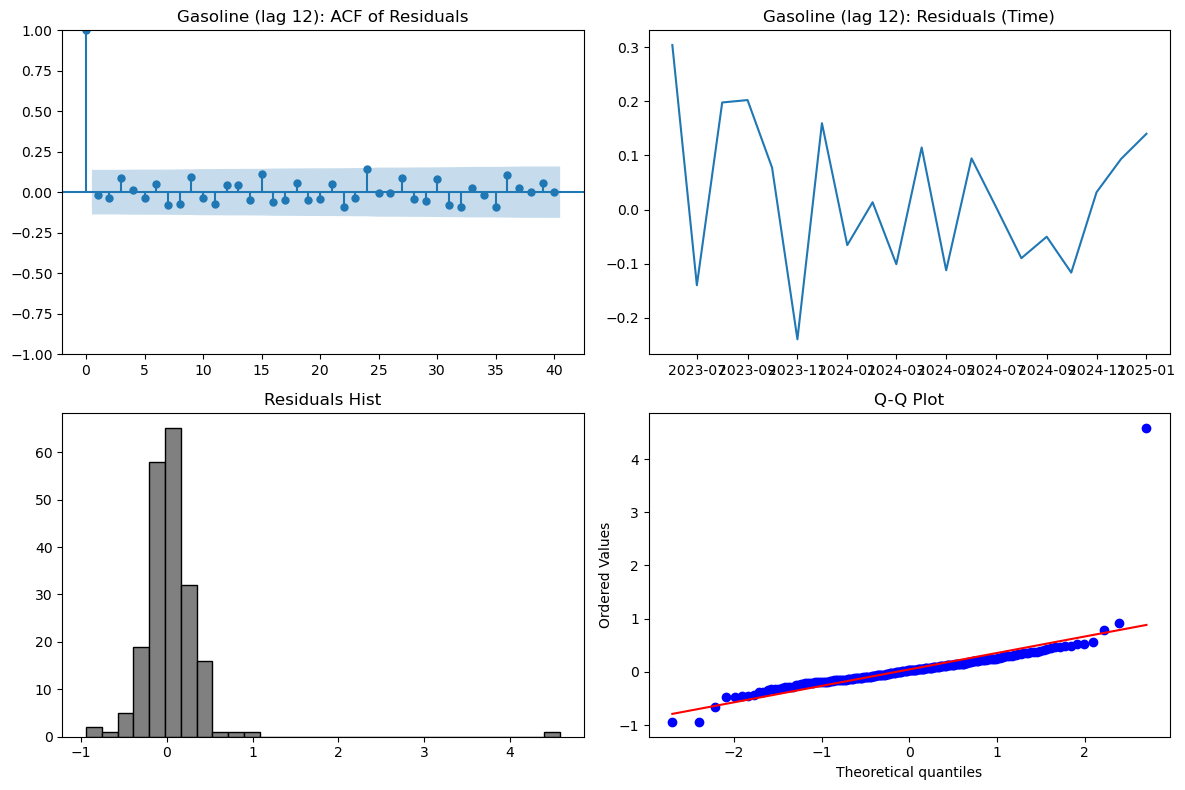

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   7.449528   0.682434
20  15.842611   0.726339
30  28.075916   0.566414

Company car tax (lag 11) — Test (rolling origin, h=3)
RMSE: 5085.33  MAE: 3814.82  MAPE: 13.28%


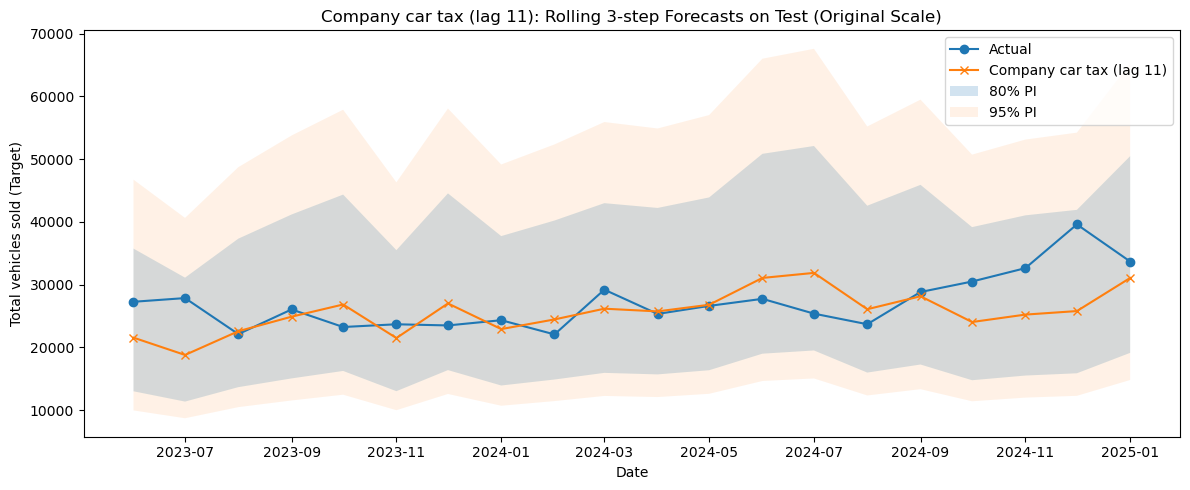

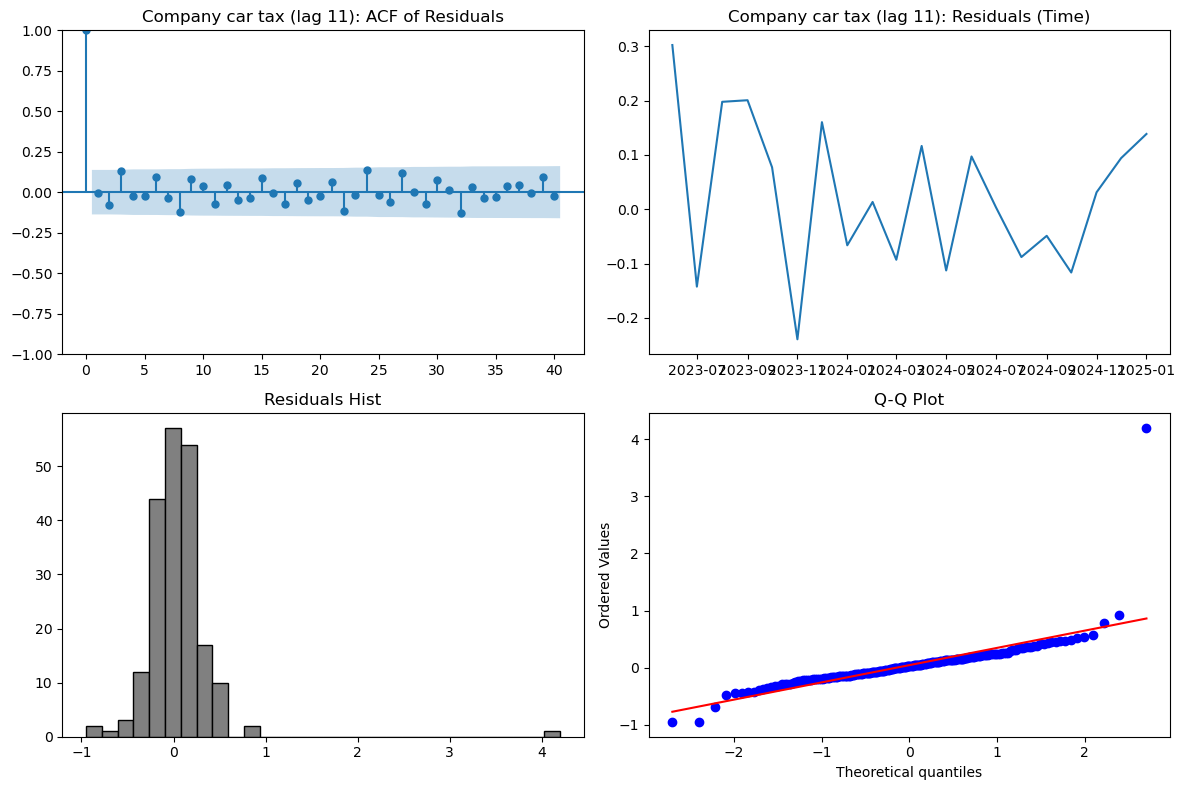

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10  12.255706   0.268308
20  18.875929   0.529903
30  34.334164   0.267671

Home charging (lag 8) — Test (rolling origin, h=3)
RMSE: 5114.57  MAE: 3820.99  MAPE: 13.27%


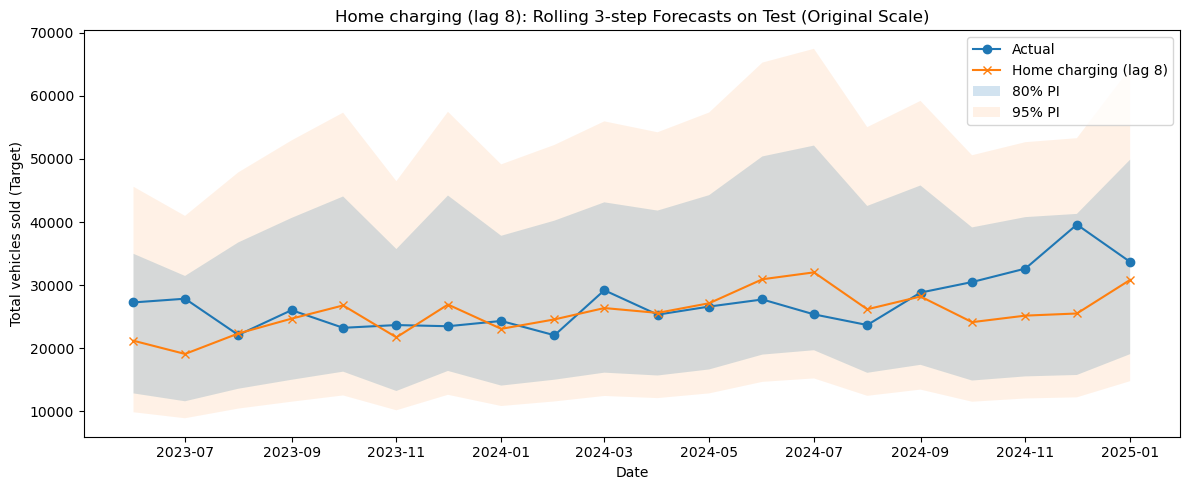

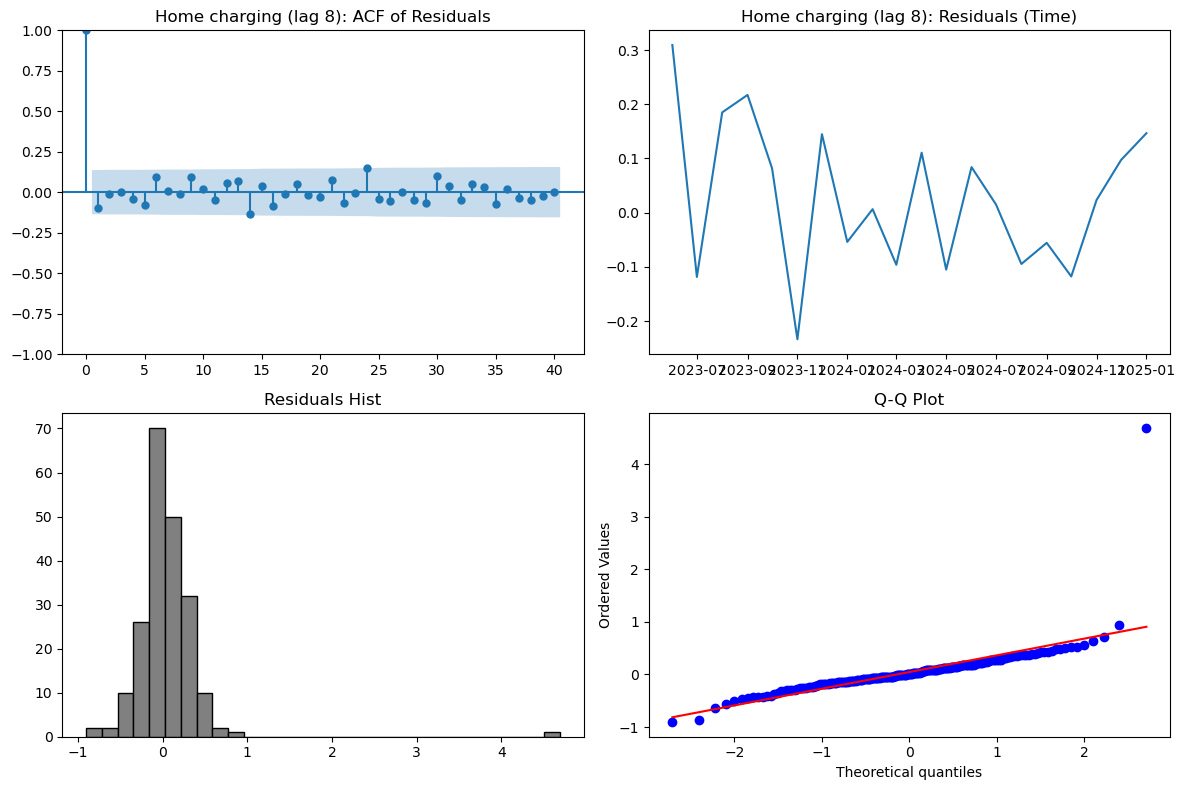

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   7.611292   0.666746
20  16.667492   0.674447
30  29.605995   0.485959

Consumer confidence (lag 11) — Test (rolling origin, h=3)
RMSE: 5018.20  MAE: 3819.27  MAPE: 13.26%


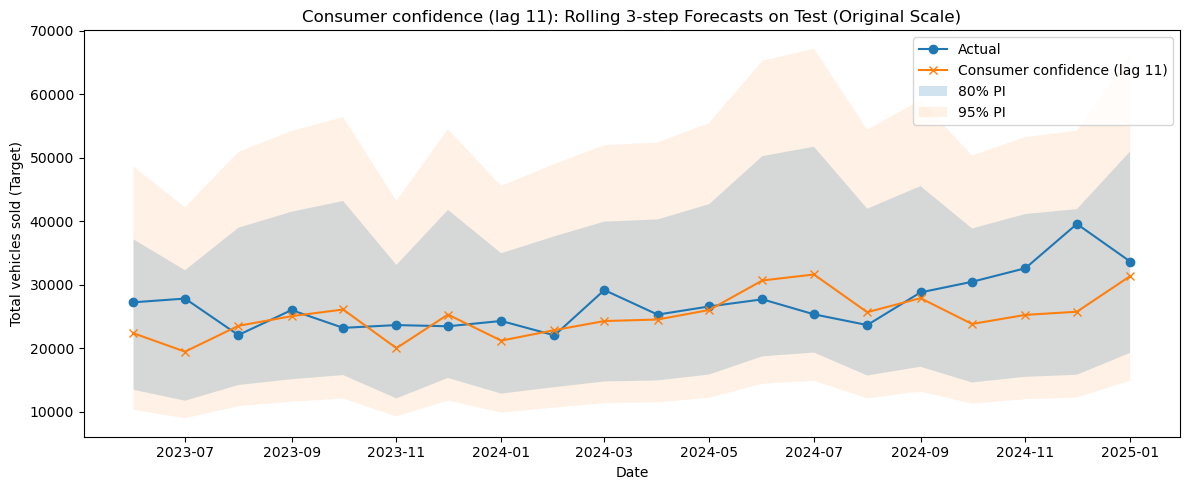

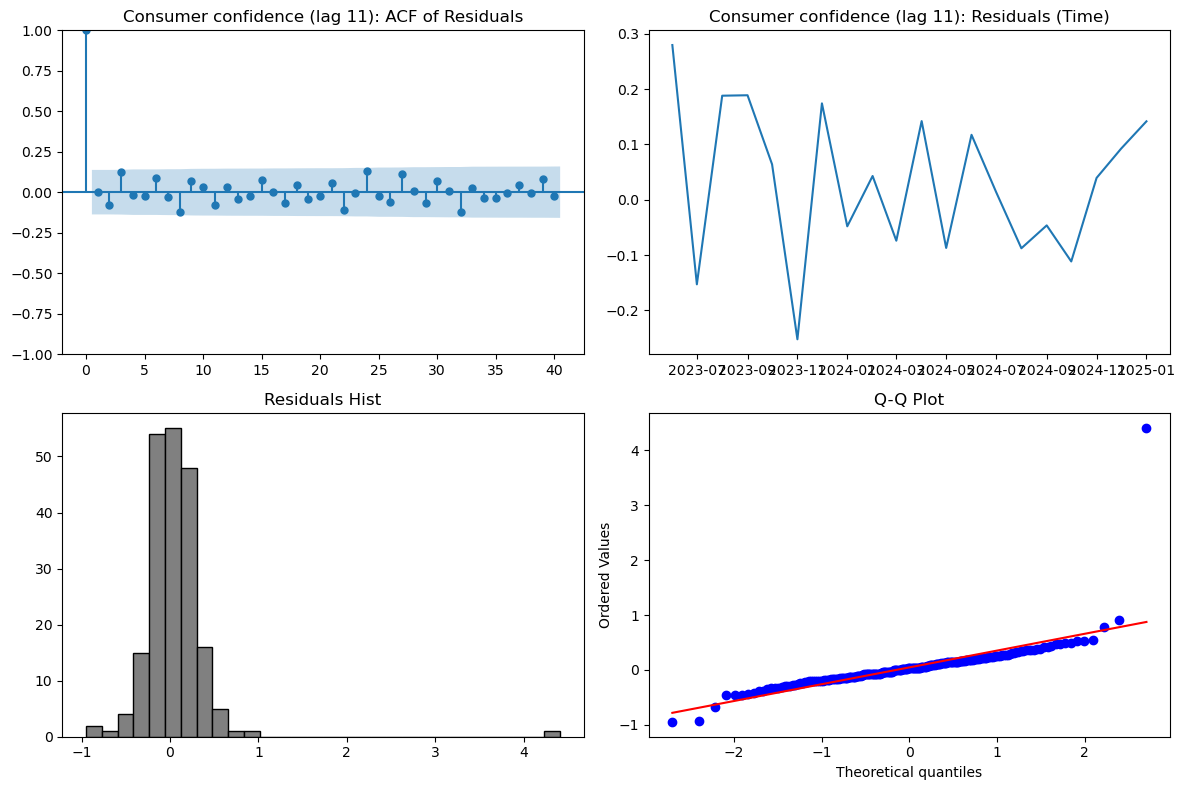

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10  11.244890   0.338760
20  16.813184   0.665069
30  30.912714   0.419707

All exogs (gas+tax+home) — Test (rolling origin, h=3)
RMSE: 5300.14  MAE: 4027.79  MAPE: 14.15%


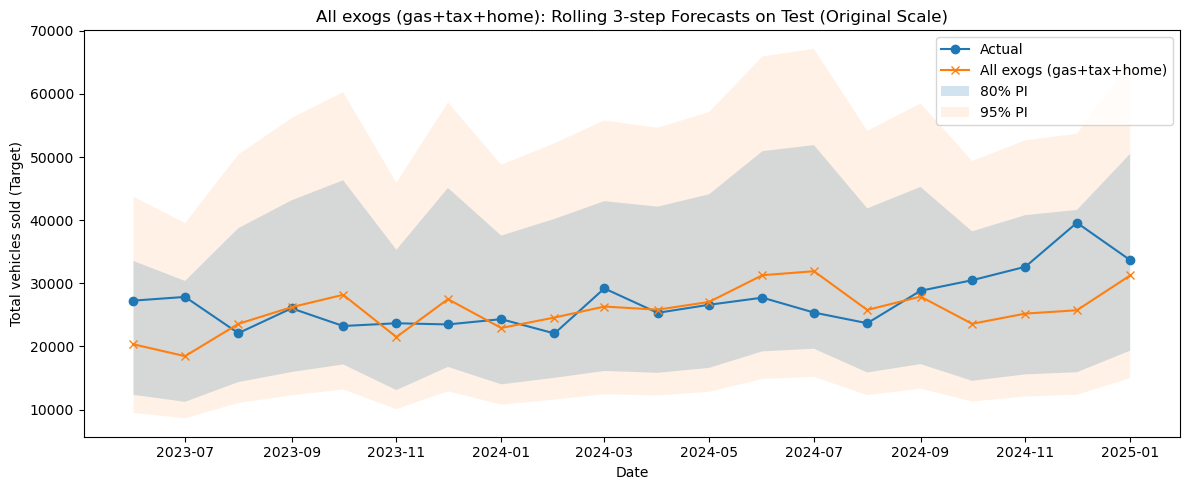

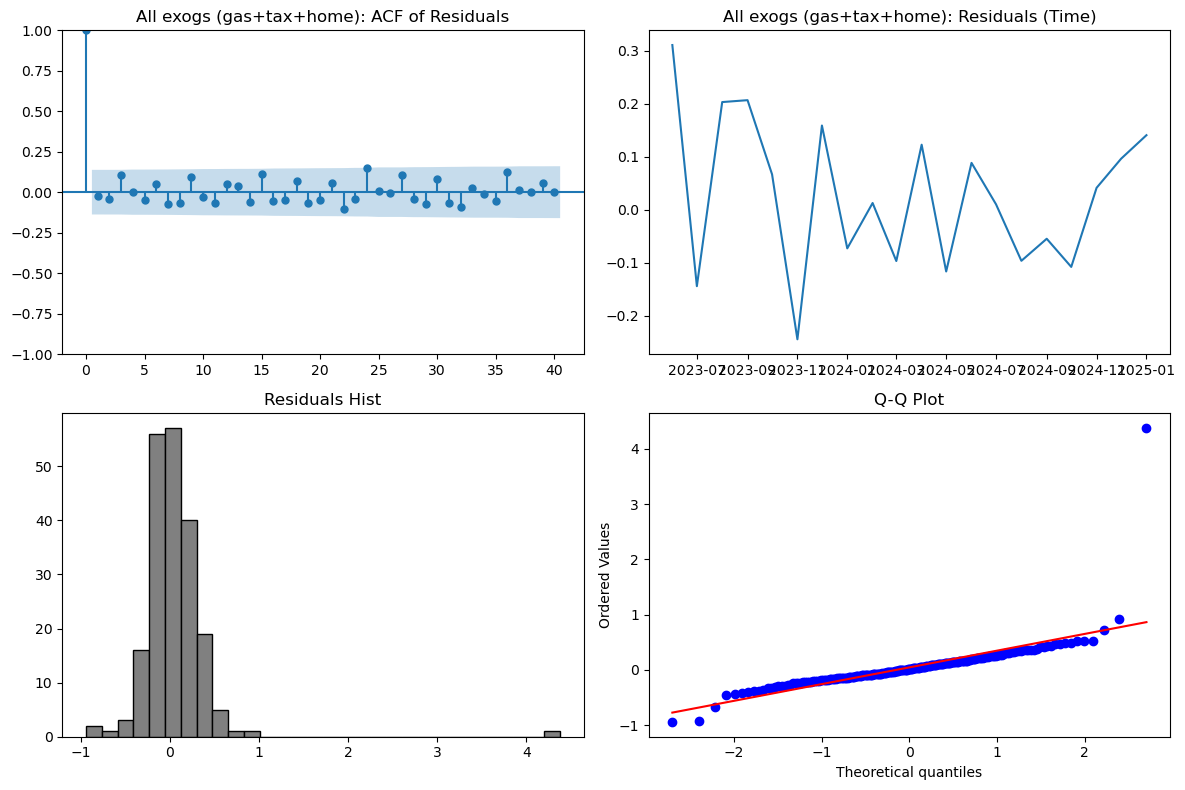

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   7.833968   0.645051
20  17.048698   0.649809
30  31.500719   0.391101

=== Test Set Summary (rolling origin, h=3) ===
                       Model     RMSE      MAE   MAPE
          Baseline (no exog) 5,121.52 3,827.06 13.30%
           Gasoline (lag 12) 5,263.10 3,967.44 13.90%
    Company car tax (lag 11) 5,085.33 3,814.82 13.28%
       Home charging (lag 8) 5,114.57 3,820.99 13.27%
Consumer confidence (lag 11) 5,018.20 3,819.27 13.26%
    All exogs (gas+tax+home) 5,300.14 4,027.79 14.15%


In [39]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
import pandas as pd

warnings.filterwarnings("ignore")

# ----------------------------
# Settings (test evaluation)
# ----------------------------
horizon = 3
order = (1, 1, 0)            # chosen on validation
seasonal_order = (0, 0, 1, 12)

# Best lags from validation (now includes 'conf', but final combined model excludes it)
best_lags = {
    "gas": 12,
    "companytax": 11,
    "homechg": 8,
    "conf": 11,
}

# ----------------------------
# Helpers
# ----------------------------
def make_lag(arr, lag):
    out = np.roll(arr, lag)
    if lag > 0:
        out[:lag] = np.nan
    return out

def inv_boxcox_with_shift(z, lam, shift):
    z = np.asarray(z, dtype=float)
    y = np.exp(z) if np.isclose(lam, 0.0) else np.power(lam * z + 1.0, 1.0 / lam)
    return y - shift

def pick_col(df, needle):
    cols = [c for c in df.columns if needle.lower() in c.lower()]
    if not cols:
        raise KeyError(f"Column containing '{needle}' not found.")
    return cols[0]

def confint_last_row(fc, alpha):
    ci = np.asarray(fc.conf_int(alpha=alpha))
    return ci[-1, 0], ci[-1, 1]

# ----------------------------
# Data slices (BC/YJ space)
# Assumes y_train_bc, y_val_bc, y_test_bc, bc_df, df, val_end_bc, test_end_bc,
# target_raw, boxcox_lambdas_all, boxcox_shifts_all already exist.
# ----------------------------
y_train_bc_arr = y_train_bc.to_numpy()
y_val_bc_arr   = y_val_bc.to_numpy()
y_test_bc_arr  = y_test_bc.to_numpy()

train_val_bc = np.concatenate([y_train_bc_arr, y_val_bc_arr])
n_trainval = len(train_val_bc)
n_test = len(y_test_bc_arr)
n_steps = n_test - horizon + 1
if n_steps <= 0:
    raise ValueError("Test set too short for the chosen horizon.")

# Exogs (Box–Cox/YJ transformed in bc_df)
col_gas   = pick_col(bc_df, "Gasoline")
col_tax   = pick_col(bc_df, "Company car tax rate")
col_home  = pick_col(bc_df, "Home charging")
col_conf  = pick_col(bc_df, "consumer confidence")  # YJ transformed earlier

gas_full   = bc_df[col_gas].to_numpy()
tax_full   = bc_df[col_tax].to_numpy()
home_full  = bc_df[col_home].to_numpy()
conf_full  = bc_df[col_conf].to_numpy()

# Inverse transform params for target
lam   = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

# ----------------------------
# Generic runner on TEST set
# ----------------------------
def run_test_roll(exog_dict=None, name="model"):
    """
    exog_dict: list of tuples [(array_full, lag), ...] or None for no exog.
               Each array_full must be the full series (train+val+test length).
    """
    preds, ci80_l, ci80_u, ci95_l, ci95_u = [], [], [], [], []

    for t in range(n_steps):
        # history up to origin: train+val + revealed test part
        y_hist = np.concatenate([train_val_bc, y_test_bc_arr[:t]])
        idx_offset = n_trainval + t

        if exog_dict:
            # build historical exog (match y_hist length), lag, and mask NaNs
            hist_cols = []
            for arr_full, lag in exog_dict:
                hist = np.concatenate([arr_full[:n_trainval], arr_full[n_trainval:n_trainval + t]])
                hist_cols.append(make_lag(hist, lag))
            exog_hist = np.column_stack(hist_cols)
            valid = ~np.isnan(exog_hist).any(axis=1)
            y_hist_valid    = y_hist[valid]
            exog_hist_valid = exog_hist[valid]

            # future exog for horizon steps
            fut_cols = []
            for arr_full, lag in exog_dict:
                fut = make_lag(arr_full[:idx_offset + horizon], lag)[-horizon:]
                fut_cols.append(fut)
            exog_future = np.column_stack(fut_cols)
        else:
            y_hist_valid = y_hist
            exog_hist_valid = None
            exog_future = None

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=order,
            seasonal_order=seasonal_order
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future)
        bc_point = fc.predicted_mean[-1]
        lo80, hi80 = confint_last_row(fc, alpha=0.20)
        lo95, hi95 = confint_last_row(fc, alpha=0.05)

        preds.append(inv_boxcox_with_shift(bc_point, lam, shift))
        ci80_l.append(inv_boxcox_with_shift(lo80, lam, shift))
        ci80_u.append(inv_boxcox_with_shift(hi80, lam, shift))
        ci95_l.append(inv_boxcox_with_shift(lo95, lam, shift))
        ci95_u.append(inv_boxcox_with_shift(hi95, lam, shift))

    actuals = inv_boxcox_with_shift(y_test_bc_arr[horizon - 1:], lam, shift)
    rmse = float(np.sqrt(mean_squared_error(actuals, preds)))
    mae  = float(mean_absolute_error(actuals, preds))
    mape = float(mean_absolute_percentage_error(actuals, preds))

    # Dates for plotting
    dates = df["Time Period (T)"].iloc[val_end_bc + horizon - 1 : test_end_bc][:len(preds)]

    print(f"\n{name} — Test (rolling origin, h={horizon})")
    print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  MAPE: {mape:.2%}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(dates, actuals, label="Actual", marker="o")
    plt.plot(dates, preds, label=name, marker="x")
    plt.fill_between(dates, ci80_l, ci80_u, alpha=0.2, label="80% PI")
    plt.fill_between(dates, ci95_l, ci95_u, alpha=0.1, label="95% PI")
    plt.title(f"{name}: Rolling {horizon}-step Forecasts on Test (Original Scale)")
    plt.xlabel("Date"); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()

    # Diagnostics from last fit (optional)
    try:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        plot_acf(res.resid, ax=axes[0, 0], lags=40)
        axes[0, 0].set_title(f"{name}: ACF of Residuals")
        axes[0, 1].plot(dates, res.resid[-len(dates):]); axes[0, 1].set_title(f"{name}: Residuals (Time)")
        axes[1, 0].hist(res.resid, bins=30, color='gray', edgecolor='black'); axes[1, 0].set_title("Residuals Hist")
        stats.probplot(res.resid, dist="norm", plot=axes[1, 1]); axes[1, 1].set_title("Q-Q Plot")
        plt.tight_layout(); plt.show()

        lb = acorr_ljungbox(res.resid, lags=[10,20,30], return_df=True)
        print("Ljung-Box (p>0.05 good):"); print(lb[['lb_stat','lb_pvalue']])
    except Exception:
        pass

    return {"rmse": rmse, "mae": mae, "mape": mape}

# ----------------------------
# Run the requested test models
# ----------------------------

# 1) Baseline (no exog)
baseline_res = run_test_roll(exog_dict=None, name="Baseline ARIMA(1,1,0)(0,0,1)[12]")

# 2) Gas-only
gas_only_res = run_test_roll(
    exog_dict=[(gas_full, best_lags["gas"])],
    name=f"Gasoline (lag {best_lags['gas']})"
)

# 3) Tax-only
tax_only_res = run_test_roll(
    exog_dict=[(tax_full, best_lags["companytax"])],
    name=f"Company car tax (lag {best_lags['companytax']})"
)

# 4) Home charging-only
home_only_res = run_test_roll(
    exog_dict=[(home_full, best_lags["homechg"])],
    name=f"Home charging (lag {best_lags['homechg']})"
)

# 5) Consumer confidence-only (INDIVIDUAL plot/eval)
conf_only_res = run_test_roll(
    exog_dict=[(conf_full, best_lags["conf"])],
    name=f"Consumer confidence (lag {best_lags['conf']})"
)

# 6) Final combined model (ONLY gas+tax+home; EXCLUDES 'conf')
three_exogs_res = run_test_roll(
    exog_dict=[
        (gas_full,  best_lags["gas"]),
        (tax_full,  best_lags["companytax"]),
        (home_full, best_lags["homechg"]),
    ],
    name="All exogs (gas+tax+home)"
)

# ----------------------------
# Summary table (TEST)
# ----------------------------
summary_rows = [
    ("Baseline (no exog)",                         baseline_res["rmse"], baseline_res["mae"], baseline_res["mape"]),
    (f"Gasoline (lag {best_lags['gas']})",         gas_only_res["rmse"], gas_only_res["mae"], gas_only_res["mape"]),
    (f"Company car tax (lag {best_lags['companytax']})",
                                                  tax_only_res["rmse"], tax_only_res["mae"], tax_only_res["mape"]),
    (f"Home charging (lag {best_lags['homechg']})", home_only_res["rmse"], home_only_res["mae"], home_only_res["mape"]),
    (f"Consumer confidence (lag {best_lags['conf']})",
                                                  conf_only_res["rmse"], conf_only_res["mae"], conf_only_res["mape"]),
    ("All exogs (gas+tax+home)",                   three_exogs_res["rmse"], three_exogs_res["mae"], three_exogs_res["mape"]),
]

summary_df = pd.DataFrame(summary_rows, columns=["Model", "RMSE", "MAE", "MAPE"])
summary_df["RMSE"] = summary_df["RMSE"].map(lambda x: f"{x:,.2f}")
summary_df["MAE"]  = summary_df["MAE"].map(lambda x: f"{x:,.2f}")
summary_df["MAPE"] = summary_df["MAPE"].map(lambda x: f"{x:.2%}")

print("\n=== Test Set Summary (rolling origin, h=3) ===")
print(summary_df.to_string(index=False))


| Model                         | RMSE     | Δ RMSE vs Naïve | Δ RMSE vs Seasonal Naïve | Δ RMSE vs Drift | MAE      | Δ MAE vs Naïve | Δ MAE vs Seasonal Naïve | Δ MAE vs Drift | MAPE   | Δ MAPE vs Naïve | Δ MAPE vs Seasonal Naïve | Δ MAPE vs Drift |
| ----------------------------- | -------- | --------------- | ------------------------ | --------------- | -------- | -------------- | ----------------------- | -------------- | ------ | --------------- | ------------------------ | --------------- |
| **Naïve (h=3)**               | 4,659.97 | —               | —                        | —               | 3,508.10 | —              | —                       | —              | 12.14% | —               | —                        | —               |
| **Seasonal Naïve**            | 8,500.25 | —               | —                        | —               | 7,454.85 | —              | —                       | —              | 26.82% | —               | —                        | —               |
| **Drift**                     | 4,365.68 | —               | —                        | —               | 3,628.32 | —              | —                       | —              | 13.51% | —               | —                        | —               |
| Baseline (no exog)            | 5,121.52 | **+461.55 ✗**   | **-3,378.73 ✓**          | **+755.84 ✗**   | 3,827.06 | **+318.96 ✗**  | **-3,627.79 ✓**         | **+198.74 ✗**  | 13.30% | **+1.16% ✗**    | **-13.52% ✓**            | **-0.21% ✓**    |
| Gasoline (lag 12)             | 5,263.10 | **+603.13 ✗**   | **-3,237.15 ✓**          | **+897.42 ✗**   | 3,967.44 | **+459.34 ✗**  | **-3,487.41 ✓**         | **+339.12 ✗**  | 13.90% | **+1.76% ✗**    | **-12.92% ✓**            | **+0.39% ✗**    |
| Company car tax rate (lag 11) | 5,085.33 | **+425.36 ✗**   | **-3,414.92 ✓**          | **+719.65 ✗**   | 3,814.82 | **+306.72 ✗**  | **-3,640.03 ✓**         | **+186.50 ✗**  | 13.28% | **+1.14% ✗**    | **-13.54% ✓**            | **-0.23% ✓**    |
| Home charging (lag 8)         | 5,114.57 | **+454.60 ✗**   | **-3,385.68 ✓**          | **+748.89 ✗**   | 3,820.99 | **+312.89 ✗**  | **-3,633.86 ✓**         | **+192.67 ✗**  | 13.27% | **+1.13% ✗**    | **-13.55% ✓**            | **-0.24% ✓**    |
| Consumer confidence (lag 11)  | 5,018.20 | **+358.23 ✗**   | **-3,482.05 ✓**          | **+652.52 ✗**   | 3,819.27 | **+311.17 ✗**  | **-3,635.58 ✓**         | **+190.95 ✗**  | 13.26% | **+1.12% ✗**    | **-13.56% ✓**            | **-0.25% ✓**    |
| All exogs (gas + tax + home)  | 5,300.14 | **+640.17 ✗**   | **-3,200.11 ✓**          | **+934.46 ✗**   | 4,027.79 | **+519.69 ✗**  | **-3,427.06 ✓**         | **+399.47 ✗**  | 14.15% | **+2.01% ✗**    | **-12.67% ✓**            | **+0.64% ✗**    |


| Feature / Model             | Val RMSE | Val MAPE | Test RMSE | Test MAPE | Δ RMSE    | Δ MAPE  |
| --------------------------- | -------- | -------- | --------- | --------- | --------- | ------- |
| Naïve (h=3)                 | 4,706.88 | 16.13%   | 4,659.97  | 12.14%    | −46.91    | −4.00%  |
| Seasonal Naïve              | 8,676.37 | 38.13%   | 8,500.25  | 26.82%    | −176.12   | −11.31% |
| Drift                       | 5,071.55 | 18.21%   | 4,365.68  | 13.51%    | −705.87   | −4.70%  |
| Baseline (no exog)          | 2,963.27 | 11.98%   | 5,121.52  | 13.30%    | +2,158.25 | +1.32%  |
| Gasoline (lag 12)           | 3,059.05 | 9.37%    | 5,263.10  | 13.90%    | +2,204.05 | +4.53%  |
| Company car tax (lag 6)     | 2,893.26 | 10.71%   | 5,078.74  | 13.06%    | +2,185.48 | +2.35%  |
| Home charging (lag 7)       | 2,896.37 | 10.68%   | 5,081.59  | 12.99%    | +2,185.22 | +2.31%  |
| Consumer confidence (lag 4) | 2,988.81 | 11.18%   | 5,024.69  | 12.92%    | +2,035.88 | +1.74%  |
| All exogs combined          | 3,400.02 | 10.87%   | 5,247.73  | 13.92%    | +1,847.71 | +3.05%  |


his makes the overfitting pattern very visible:

Benchmarks perform similarly or slightly better on the test set vs validation (negative Δ = improvement).

All your feature-based models show large positive Δ RMSE, meaning they fit validation well but did not generalize strongly.

Gasoline (lag 12) had the largest MAPE increase (+4.53%), while Consumer confidence lag 4 had the smallest (+1.74%).

## Autoarima

### Autoarima val


Baseline ARIMA(0,1,1)(0,1,1)[12] — Validation (rolling origin, h=3)
RMSE: 7012.53  MAE: 5449.68  MAPE: 29.15%


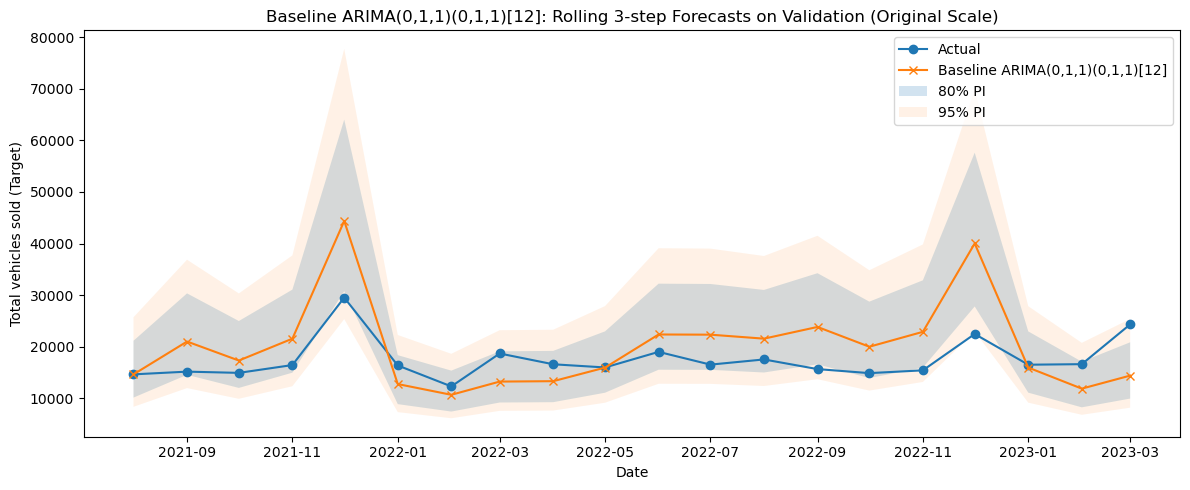

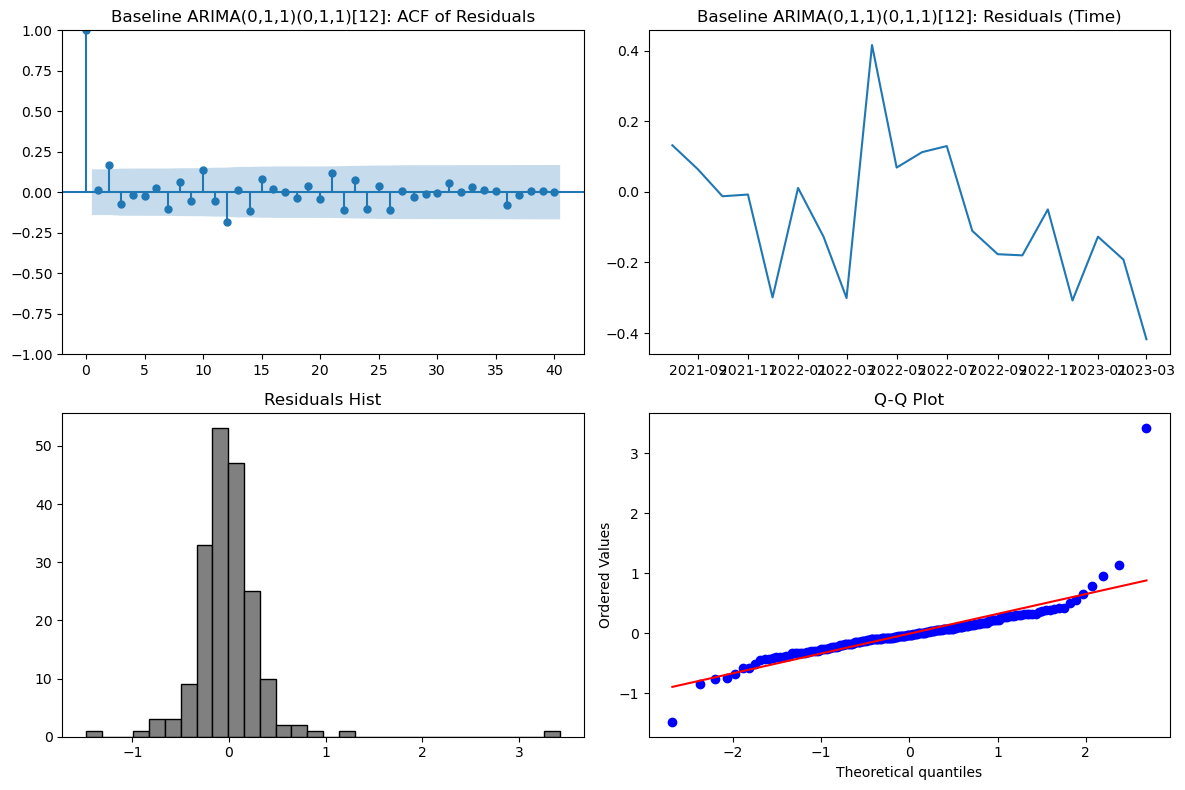

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10  14.125581   0.167340
20  27.506781   0.121599
30  40.188836   0.101258


In [34]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
import pandas as pd

warnings.filterwarnings("ignore")

# ----------------------------
# Settings (VALIDATION evaluation)
# ----------------------------
horizon = 3
order = (0, 1, 1)             # baseline from validation
seasonal_order = (0, 1, 1, 12)

# ----------------------------
# Helpers
# ----------------------------
def inv_boxcox_with_shift(z, lam, shift):
    z = np.asarray(z, dtype=float)
    y = np.exp(z) if np.isclose(lam, 0.0) else np.power(lam * z + 1.0, 1.0 / lam)
    return y - shift

def confint_last_row(fc, alpha):
    ci = np.asarray(fc.conf_int(alpha=alpha))
    return ci[-1, 0], ci[-1, 1]

# ----------------------------
# Data slices (BC/YJ space) — VALIDATION ONLY
# ----------------------------
y_train_bc_arr = y_train_bc.to_numpy()
y_val_bc_arr   = y_val_bc.to_numpy()

n_train = len(y_train_bc_arr)
n_val   = len(y_val_bc_arr)
n_steps = n_val - horizon + 1
if n_steps <= 0:
    raise ValueError("Validation set too short for the chosen horizon.")

# Inverse transform params for target
lam   = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

# ----------------------------
# Baseline runner on VALIDATION set (no exog)
# ----------------------------
def run_val_roll_baseline(name="Baseline ARIMA(0,1,1)(0,1,1)[12]"):
    preds, ci80_l, ci80_u, ci95_l, ci95_u = [], [], [], [], []

    for t in range(n_steps):
        # history up to origin: train + revealed part of val
        y_hist = np.concatenate([y_train_bc_arr, y_val_bc_arr[:t]])

        model = SARIMAX(
            y_hist,
            order=order,
            seasonal_order=seasonal_order
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon)
        bc_point = fc.predicted_mean[-1]

        lo80, hi80 = confint_last_row(fc, alpha=0.20)
        lo95, hi95 = confint_last_row(fc, alpha=0.05)

        preds.append(inv_boxcox_with_shift(bc_point, lam, shift))
        ci80_l.append(inv_boxcox_with_shift(lo80, lam, shift))
        ci80_u.append(inv_boxcox_with_shift(hi80, lam, shift))
        ci95_l.append(inv_boxcox_with_shift(lo95, lam, shift))
        ci95_u.append(inv_boxcox_with_shift(hi95, lam, shift))

    actuals = inv_boxcox_with_shift(y_val_bc_arr[horizon - 1:], lam, shift)
    rmse = float(np.sqrt(mean_squared_error(actuals, preds)))
    mae  = float(mean_absolute_error(actuals, preds))
    mape = float(mean_absolute_percentage_error(actuals, preds))

    # Dates for plotting (validation window)
    dates = df["Time Period (T)"].iloc[train_end_bc + horizon - 1 : val_end_bc][:len(preds)]

    print(f"\n{name} — Validation (rolling origin, h={horizon})")
    print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  MAPE: {mape:.2%}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(dates, actuals, label="Actual", marker="o")
    plt.plot(dates, preds, label=name, marker="x")
    plt.fill_between(dates, ci80_l, ci80_u, alpha=0.2, label="80% PI")
    plt.fill_between(dates, ci95_l, ci95_u, alpha=0.1, label="95% PI")
    plt.title(f"{name}: Rolling {horizon}-step Forecasts on Validation (Original Scale)")
    plt.xlabel("Date"); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()

    # Diagnostics from last fit (optional)
    try:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        plot_acf(res.resid, ax=axes[0, 0], lags=40)
        axes[0, 0].set_title(f"{name}: ACF of Residuals")
        axes[0, 1].plot(dates, res.resid[-len(dates):]); axes[0, 1].set_title(f"{name}: Residuals (Time)")
        axes[1, 0].hist(res.resid, bins=30, color='gray', edgecolor='black'); axes[1, 0].set_title("Residuals Hist")
        stats.probplot(res.resid, dist="norm", plot=axes[1, 1]); axes[1, 1].set_title("Q-Q Plot")
        plt.tight_layout(); plt.show()

        lb = acorr_ljungbox(res.resid, lags=[10,20,30], return_df=True)
        print("Ljung-Box (p>0.05 good):"); print(lb[['lb_stat','lb_pvalue']])
    except Exception:
        pass

    return {"rmse": rmse, "mae": mae, "mape": mape}

# ----------------------------
# Run ONLY the baseline on VALIDATION
# ----------------------------
baseline_res_val = run_val_roll_baseline()



Baseline ARIMA(0,1,1)(0,1,1)[12] — TEST (rolling origin, h=3)
RMSE: 6,237.96  MAE: 4,422.84  MAPE: 16.29%


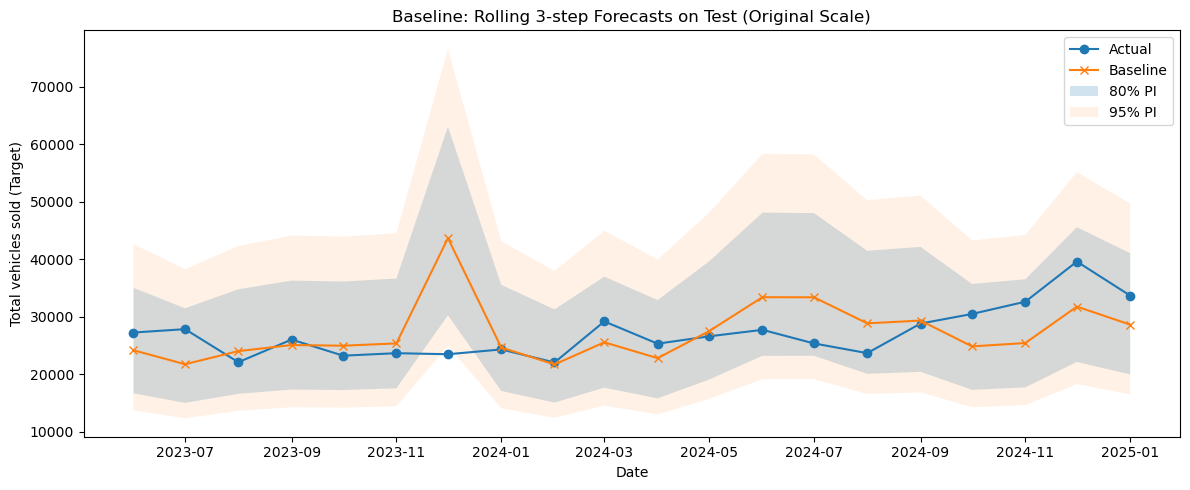

In [35]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# ----------------------------
# Settings (TEST evaluation)
# ----------------------------
horizon = 3
order = (0, 1, 1)              # baseline chosen on validation
seasonal_order = (0, 1, 1, 12) # baseline chosen on validation

# ----------------------------
# Helpers
# ----------------------------
def inv_boxcox_with_shift(z, lam, shift):
    z = np.asarray(z, dtype=float)
    y = np.exp(z) if np.isclose(lam, 0.0) else np.power(lam * z + 1.0, 1.0 / lam)
    return y - shift

def confint_last_row(fc, alpha):
    ci = np.asarray(fc.conf_int(alpha=alpha))
    return ci[-1, 0], ci[-1, 1]

# ----------------------------
# Data slices (BC space) — TEST ONLY
# Assumes you already have: y_train_bc, y_val_bc, y_test_bc, df, val_end_bc, target_raw,
# and the Box–Cox params: boxcox_lambdas_all, boxcox_shifts_all
# ----------------------------
y_train_bc_arr = y_train_bc.to_numpy()
y_val_bc_arr   = y_val_bc.to_numpy()
y_test_bc_arr  = y_test_bc.to_numpy()

y_trainval_bc = np.concatenate([y_train_bc_arr, y_val_bc_arr])

n_test  = len(y_test_bc_arr)
n_steps = n_test - horizon + 1
if n_steps <= 0:
    raise ValueError("Test set too short for the chosen horizon.")

lam   = boxcox_lambdas_all[target_raw]
shift = boxcox_shifts_all[target_raw]

# ----------------------------
# Rolling-origin baseline on TEST
# ----------------------------
preds_bc, ci80_l_bc, ci80_u_bc, ci95_l_bc, ci95_u_bc = [], [], [], [], []

for t in range(n_steps):
    # expanding history: train+val plus the first t test observations
    y_hist = np.concatenate([y_trainval_bc, y_test_bc_arr[:t]])

    model = SARIMAX(y_hist, order=order, seasonal_order=seasonal_order)
    res = model.fit(disp=False)

    fc = res.get_forecast(steps=horizon)  # no exog
    bc_point = fc.predicted_mean[-1]
    lo80, hi80 = confint_last_row(fc, alpha=0.20)
    lo95, hi95 = confint_last_row(fc, alpha=0.05)

    preds_bc.append(bc_point)
    ci80_l_bc.append(lo80); ci80_u_bc.append(hi80)
    ci95_l_bc.append(lo95); ci95_u_bc.append(hi95)

# Align actuals (BC) and back-transform to original scale
actuals_bc = y_test_bc_arr[horizon - 1:]
actuals    = inv_boxcox_with_shift(actuals_bc,    lam, shift)
preds      = inv_boxcox_with_shift(preds_bc,      lam, shift)
ci80_l     = inv_boxcox_with_shift(ci80_l_bc,     lam, shift)
ci80_u     = inv_boxcox_with_shift(ci80_u_bc,     lam, shift)
ci95_l     = inv_boxcox_with_shift(ci95_l_bc,     lam, shift)
ci95_u     = inv_boxcox_with_shift(ci95_u_bc,     lam, shift)

# ----------------------------
# Metrics (original scale)
# ----------------------------
rmse = float(np.sqrt(mean_squared_error(actuals, preds)))
mae  = float(mean_absolute_error(actuals, preds))
mape = float(mean_absolute_percentage_error(actuals, preds))
print(f"\nBaseline ARIMA(0,1,1)(0,1,1)[12] — TEST (rolling origin, h={horizon})")
print(f"RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  MAPE: {mape:.2%}")

# ----------------------------
# Plot (original scale)
# ----------------------------
# Dates covering the test rolling window
start_idx = val_end_bc + (horizon - 1)
plot_dates = df["Time Period (T)"].iloc[start_idx : start_idx + len(preds)]

plt.figure(figsize=(12,5))
plt.plot(plot_dates, actuals, label="Actual", marker="o")
plt.plot(plot_dates, preds,   label="Baseline", marker="x")
plt.fill_between(plot_dates, ci80_l, ci80_u, alpha=0.2, label="80% PI")
plt.fill_between(plot_dates, ci95_l, ci95_u, alpha=0.1, label="95% PI")
plt.title(f"Baseline: Rolling {horizon}-step Forecasts on Test (Original Scale)")
plt.xlabel("Date"); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()


### Autoarimatest

In [ ]:
# # ----------------------------
# # Settings (test evaluation)
# # ----------------------------
# horizon = 3
# order = (0, 1, 1)           # your baseline chosen on val
# seasonal_order = (0, 1, 1, 12)

# use_val_in_training = True  # <<< toggle hier: True = train+val, False = alleen train

# # Best lags from validation
# best_lags = {
#     "gas": 12,
#     "companytax": 6,
#     "homechg": 7,
#     "conf": 4,
# }

# # ----------------------------
# # Data slices (BC/YJ space)
# # ----------------------------
# y_train_bc_arr = y_train_bc.to_numpy()
# y_val_bc_arr   = y_val_bc.to_numpy()
# y_test_bc_arr  = y_test_bc.to_numpy()

# if use_val_in_training:
#     history_start = np.concatenate([y_train_bc_arr, y_val_bc_arr])
# else:
#     history_start = y_train_bc_arr

# n_history = len(history_start)
# n_test = len(y_test_bc_arr)
# n_steps = n_test - horizon + 1
# if n_steps <= 0:
#     raise ValueError("Test set too short for the chosen horizon.")

# # ----------------------------
# # In de run_test_roll vervangen we train_val_bc door history_start
# # ----------------------------
# def run_test_roll(exog_dict=None, name="model"):
#     preds, ci80_l, ci80_u, ci95_l, ci95_u = [], [], [], [], []

#     for t in range(n_steps):
#         # history up to origin: startpunt (train of train+val) + revealed test part
#         y_hist = np.concatenate([history_start, y_test_bc_arr[:t]])
#         idx_offset = n_history + t

#         if exog_dict:
#             hist_cols = []
#             for arr_full, lag in exog_dict:
#                 hist = np.concatenate([arr_full[:n_history], arr_full[n_history:n_history + t]])
#                 hist_cols.append(make_lag(hist, lag))
#             exog_hist = np.column_stack(hist_cols)
#             valid = ~np.isnan(exog_hist).any(axis=1)
#             y_hist_valid = y_hist[valid]
#             exog_hist_valid = exog_hist[valid]

#             fut_cols = []
#             for arr_full, lag in exog_dict:
#                 fut = make_lag(arr_full[:idx_offset + horizon], lag)[-horizon:]
#                 fut_cols.append(fut)
#             exog_future = np.column_stack(fut_cols)
#         else:
#             y_hist_valid = y_hist
#             exog_hist_valid = None
#             exog_future = None

#         model = SARIMAX(
#             y_hist_valid,
#             exog=exog_hist_valid,
#             order=order,
#             seasonal_order=seasonal_order
#         )
#         res = model.fit(disp=False)

#         fc = res.get_forecast(steps=horizon, exog=exog_future)
#         bc_point = fc.predicted_mean[-1]

#         lo80, hi80 = confint_last_row(fc, alpha=0.20)
#         lo95, hi95 = confint_last_row(fc, alpha=0.05)

#         preds.append(inv_boxcox_with_shift(bc_point, lam, shift))
#         ci80_l.append(inv_boxcox_with_shift(lo80, lam, shift))
#         ci80_u.append(inv_boxcox_with_shift(hi80, lam, shift))
#         ci95_l.append(inv_boxcox_with_shift(lo95, lam, shift))
#         ci95_u.append(inv_boxcox_with_shift(hi95, lam, shift))

#     actuals = inv_boxcox_with_shift(y_test_bc_arr[horizon - 1:], lam, shift)
#     rmse = float(np.sqrt(mean_squared_error(actuals, preds)))
#     mae  = float(mean_absolute_error(actuals, preds))
#     mape = float(mean_absolute_percentage_error(actuals, preds))

#     print(f"\n{name} — Test (rolling origin, h={horizon})")
#     print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  MAPE: {mape:.2%}")
#     return {"rmse": rmse, "mae": mae, "mape": mape}



Baseline ARIMA(1,1,0)(0,0,1)[12] — Test (rolling origin, h=3)
RMSE: 6237.96  MAE: 4422.84  MAPE: 16.29%


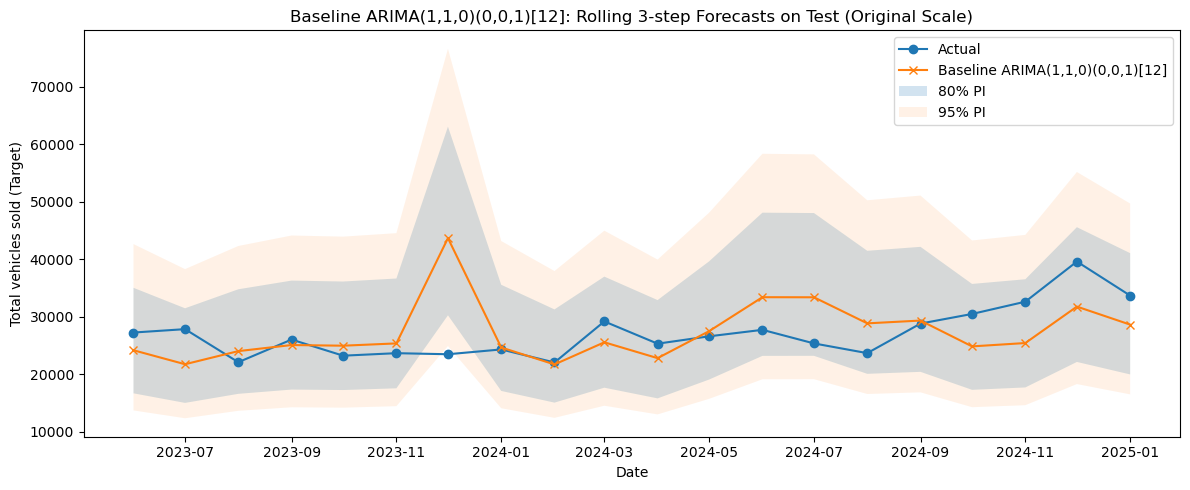

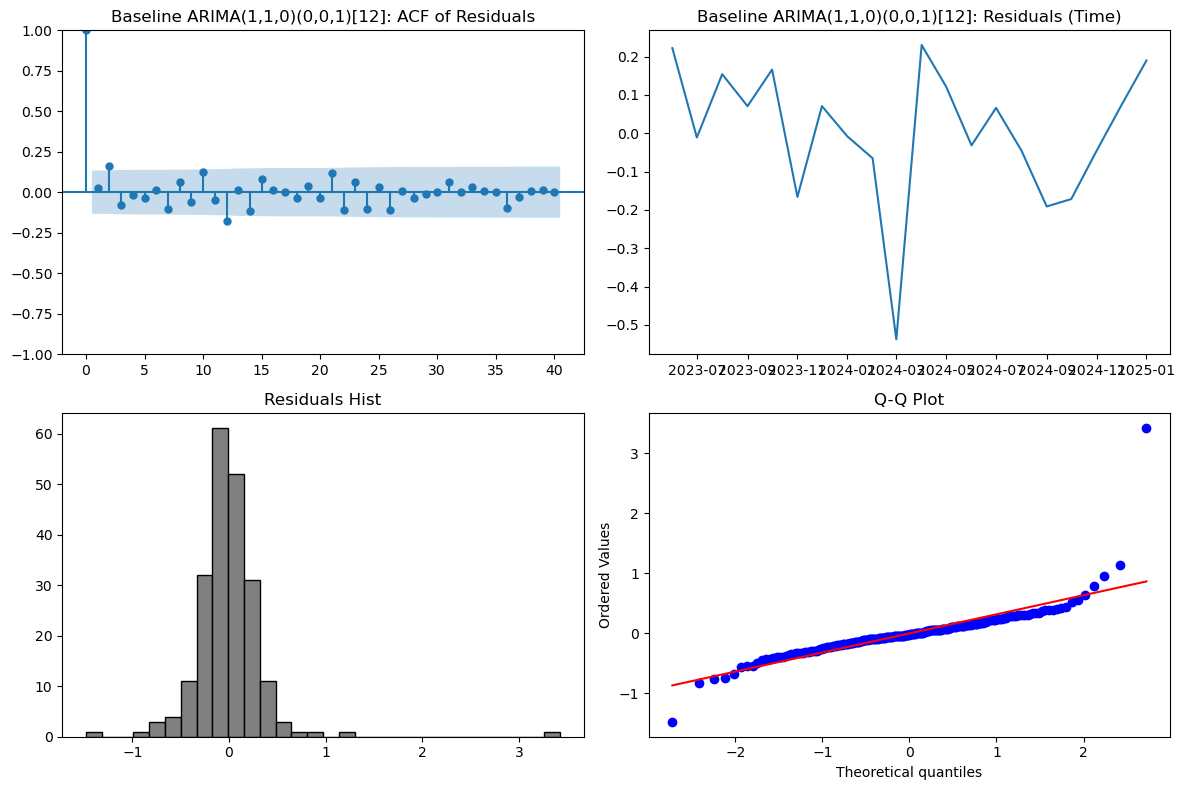

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10  14.833405   0.138255
20  28.564029   0.096705
30  42.025179   0.071219

Gasoline (lag 12) — Test (rolling origin, h=3)
RMSE: 6735.43  MAE: 4984.25  MAPE: 18.48%


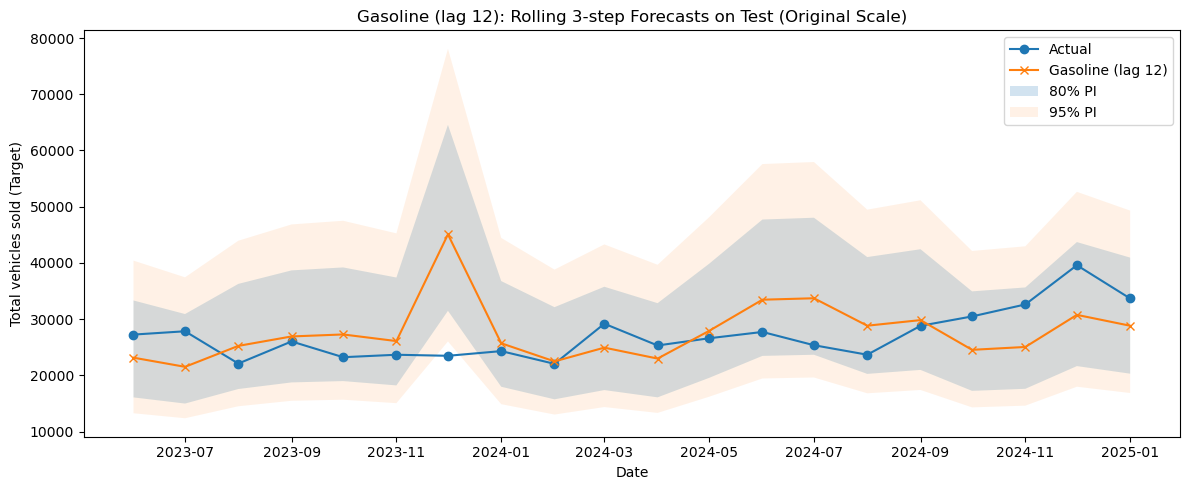

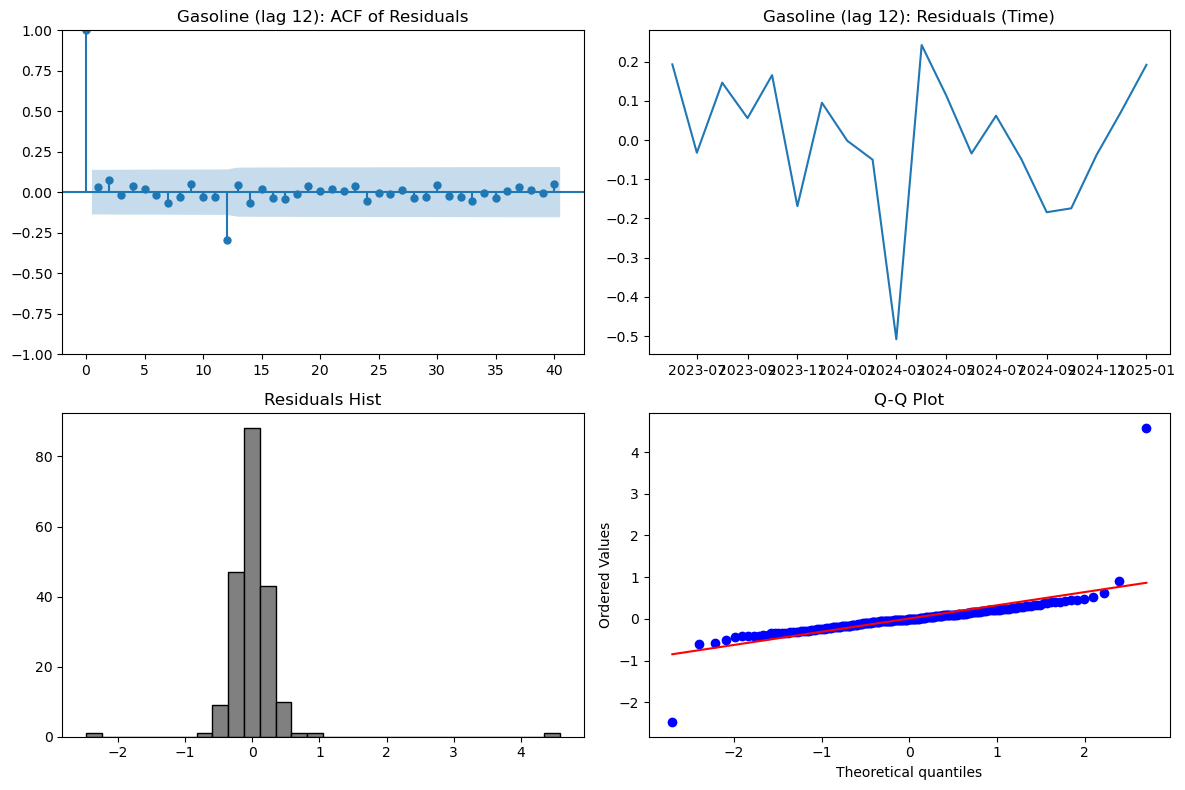

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   3.686158   0.960396
20  25.346841   0.188483
30  27.440195   0.600075

All exogs (gas+tax+homechg+conf) — Test (rolling origin, h=3)
RMSE: 6710.61  MAE: 5014.99  MAPE: 18.60%


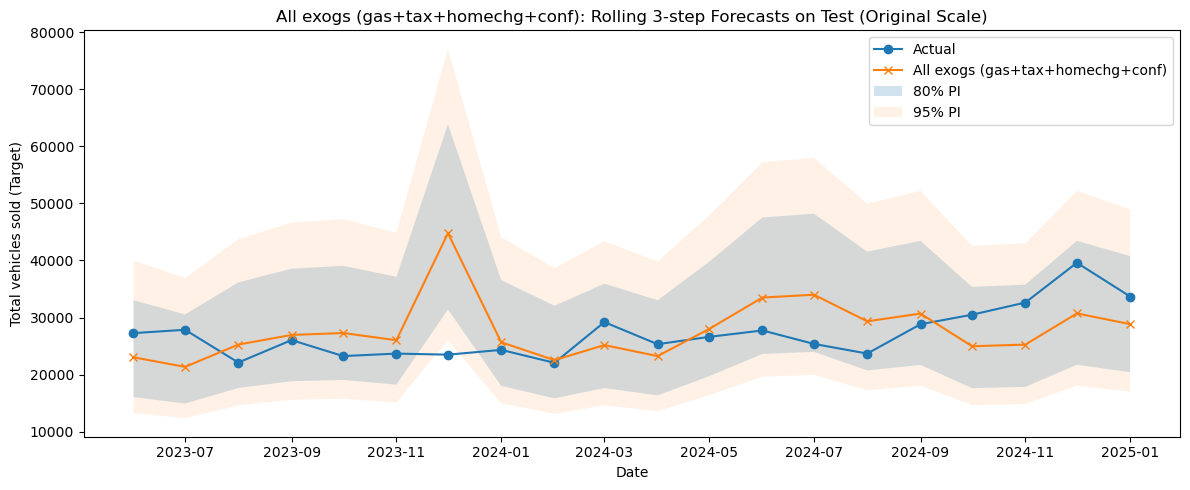

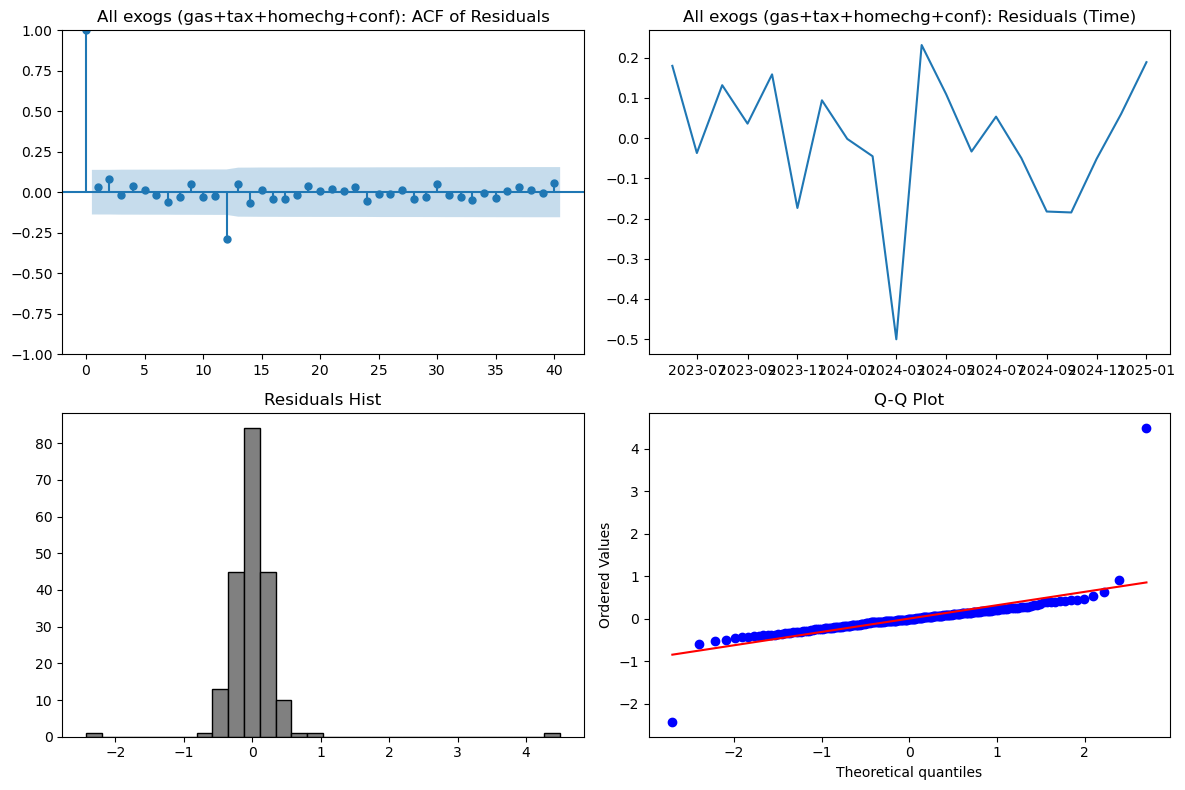

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   3.827000   0.954814
20  25.030102   0.200282
30  27.422684   0.601001

Company car tax (lag 6) — Test (rolling origin, h=3)
RMSE: 6265.59  MAE: 4441.38  MAPE: 16.38%


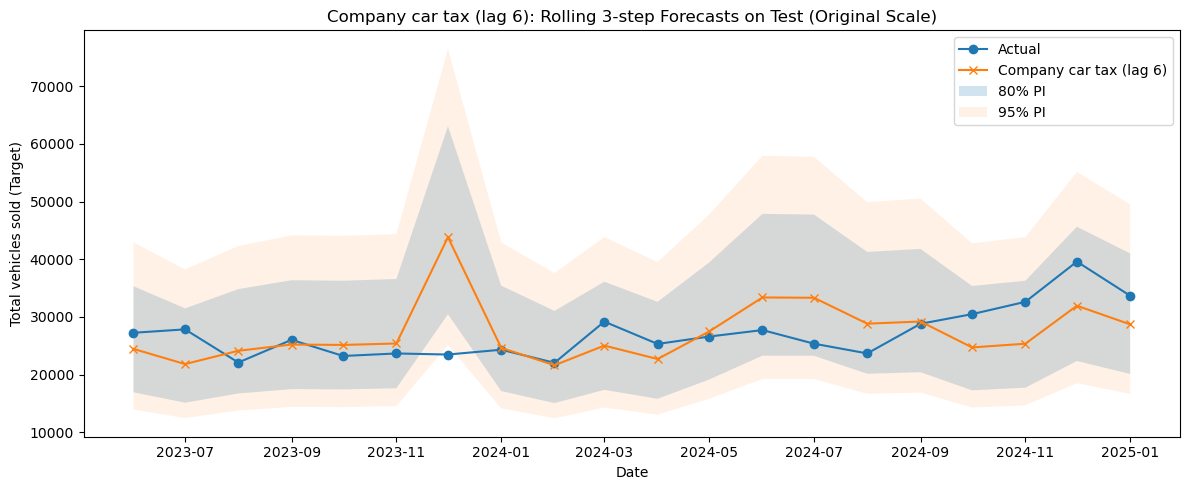

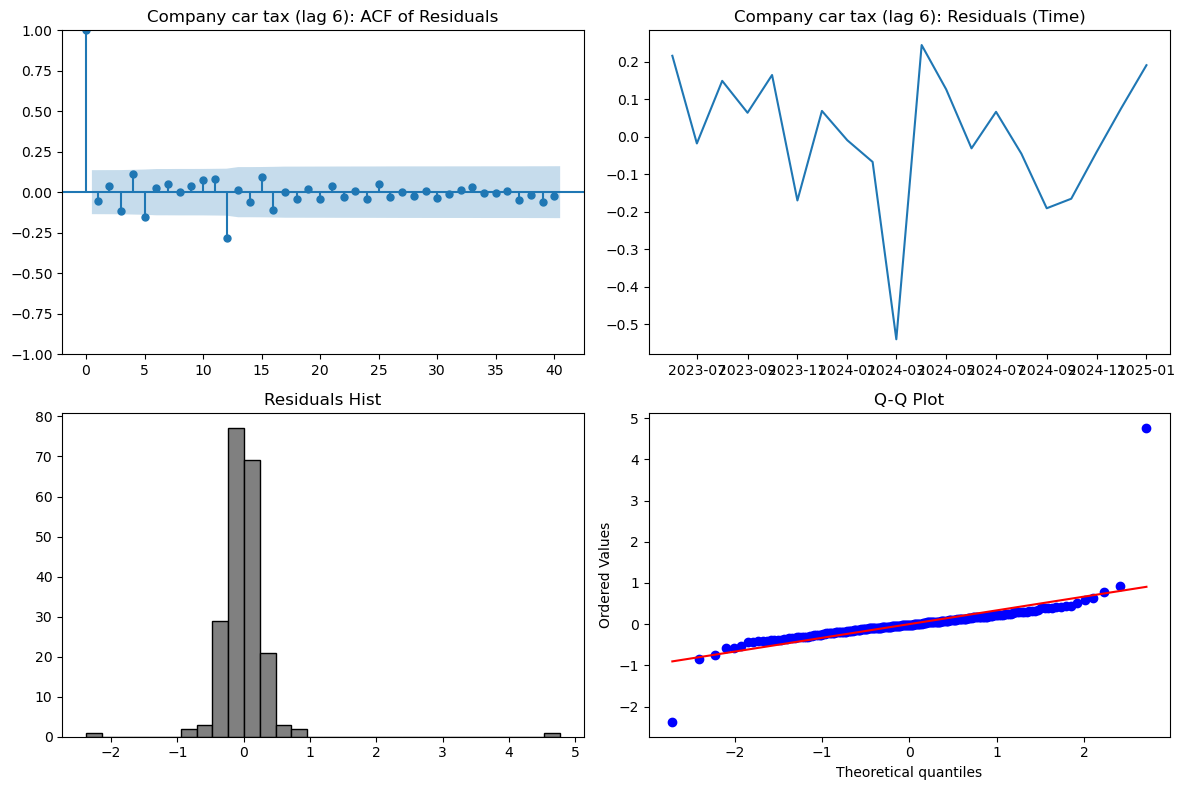

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10  13.744481   0.184969
20  39.707589   0.005438
30  41.911663   0.072829

Home charging (lag 7) — Test (rolling origin, h=3)
RMSE: 6269.66  MAE: 4449.70  MAPE: 16.41%


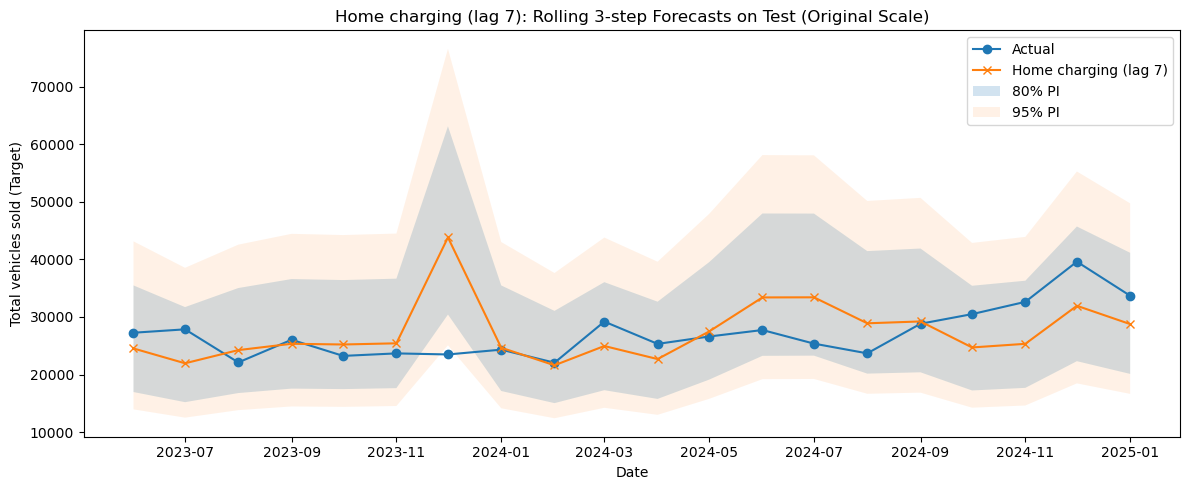

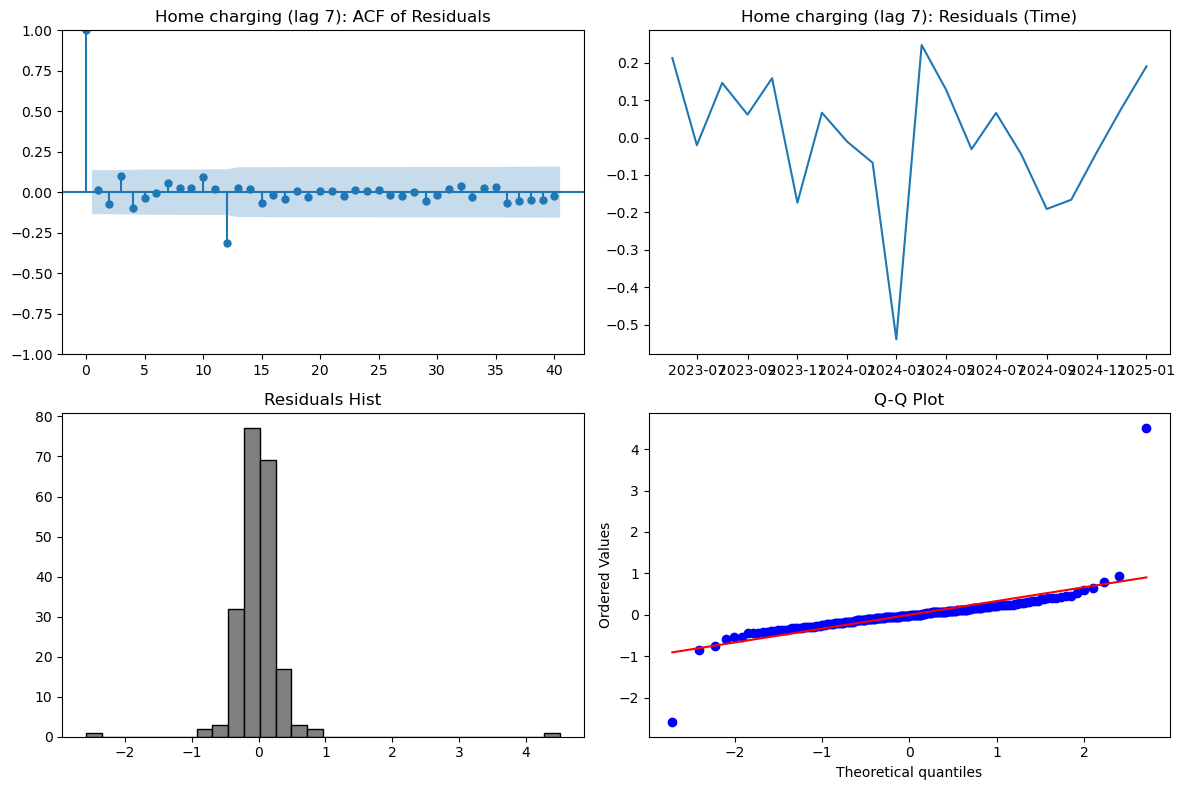

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   8.523056   0.577884
20  32.804359   0.035446
30  34.060258   0.278430

Consumer confidence (lag 4) — Test (rolling origin, h=3)
RMSE: 6317.03  MAE: 4483.90  MAPE: 16.59%


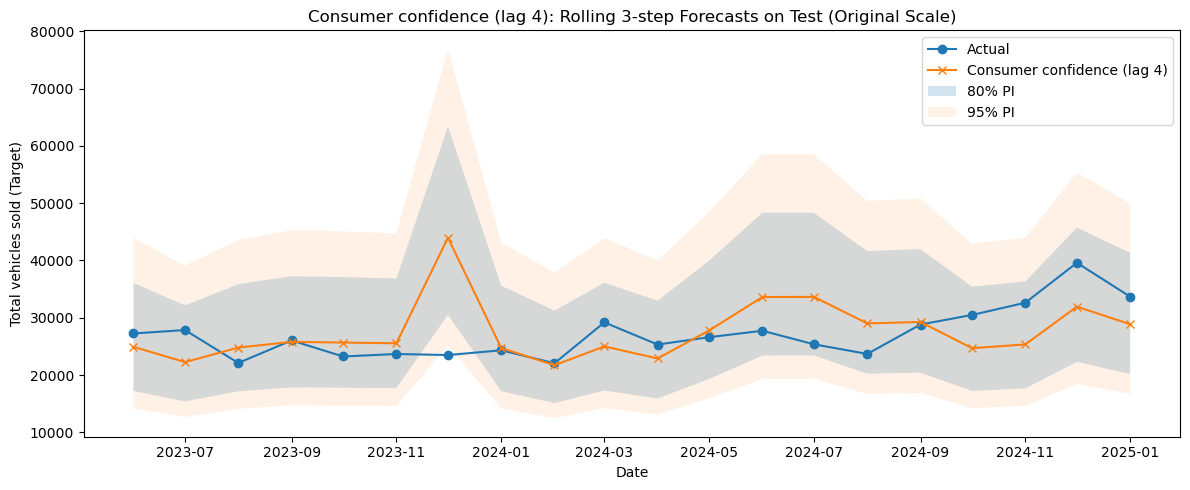

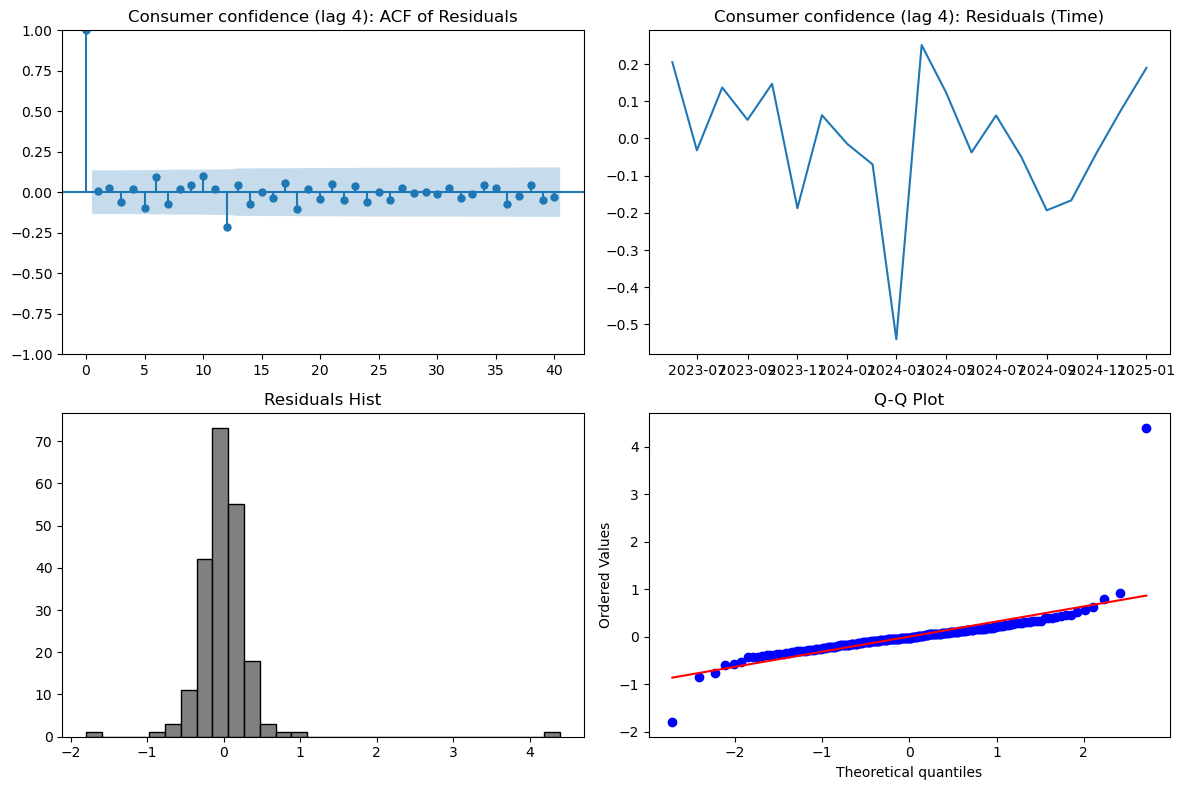

Ljung-Box (p>0.05 good):
      lb_stat  lb_pvalue
10   8.689346   0.561818
20  24.915299   0.204691
30  28.054474   0.567550

=== Test Set Summary (rolling origin, h=3) ===
                        Model     RMSE      MAE   MAPE
           Baseline (no exog) 6,237.96 4,422.84 16.29%
            Gasoline (lag 12) 6,735.43 4,984.25 18.48%
      Company car tax (lag 6) 6,265.59 4,441.38 16.38%
        Home charging (lag 7) 6,269.66 4,449.70 16.41%
  Consumer confidence (lag 4) 6,317.03 4,483.90 16.59%
All exogs (gas+tax+home+conf) 6,710.61 5,014.99 18.60%


In [ ]:
# import warnings
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.stats.diagnostic import acorr_ljungbox
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# import scipy.stats as stats
# import pandas as pd

# warnings.filterwarnings("ignore")

# # ----------------------------
# # Settings (test evaluation)
# # ----------------------------
# horizon = 3
# order = (0, 1, 1)           # your baseline chosen on val
# seasonal_order = (0, 1, 1, 12)

# # Best lags from validation
# best_lags = {
#     "gas": 12,
#     "companytax": 6,
#     "homechg": 7,
#     "conf": 4,
# }

# # ----------------------------
# # Helpers
# # ----------------------------
# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     if lag > 0:
#         out[:lag] = np.nan
#     return out

# def inv_boxcox_with_shift(z, lam, shift):
#     z = np.asarray(z, dtype=float)
#     y = np.exp(z) if np.isclose(lam, 0.0) else np.power(lam * z + 1.0, 1.0 / lam)
#     return y - shift

# def pick_col(df, needle):
#     cols = [c for c in df.columns if needle.lower() in c.lower()]
#     if not cols:
#         raise KeyError(f"Column containing '{needle}' not found.")
#     return cols[0]

# def confint_last_row(fc, alpha):
#     ci = fc.conf_int(alpha=alpha)
#     # Works whether it's ndarray or DataFrame
#     ci = np.asarray(ci)
#     return ci[-1, 0], ci[-1, 1]

# # ----------------------------
# # Data slices (BC/YJ space)
# # ----------------------------
# y_train_bc_arr = y_train_bc.to_numpy()
# y_val_bc_arr   = y_val_bc.to_numpy()
# y_test_bc_arr  = y_test_bc.to_numpy()

# train_val_bc = np.concatenate([y_train_bc_arr, y_val_bc_arr])
# n_trainval = len(train_val_bc)
# n_test = len(y_test_bc_arr)
# n_steps = n_test - horizon + 1
# if n_steps <= 0:
#     raise ValueError("Test set too short for the chosen horizon.")

# # Exogs (already transformed: BC for most, YJ for confidence)
# col_gas   = pick_col(bc_df, "Gasoline")
# col_tax   = pick_col(bc_df, "Company car tax rate")
# col_home  = pick_col(bc_df, "Home charging")
# col_conf  = pick_col(bc_df, "consumer confidence")

# gas_full   = bc_df[col_gas].to_numpy()
# tax_full   = bc_df[col_tax].to_numpy()
# home_full  = bc_df[col_home].to_numpy()
# conf_full  = bc_df[col_conf].to_numpy()

# # Inverse transform params for target
# lam   = boxcox_lambdas_all[target_raw]
# shift = boxcox_shifts_all[target_raw]

# # ----------------------------
# # Generic runner on TEST set
# # ----------------------------
# def run_test_roll(exog_dict=None, name="model"):
#     """
#     exog_dict: list of tuples [(array_full, lag), ...] or None for no exog.
#                Each array_full must be full series (train+val+test length).
#     """
#     preds, ci80_l, ci80_u, ci95_l, ci95_u = [], [], [], [], []

#     for t in range(n_steps):
#         # history up to origin: train+val + revealed test part
#         y_hist = np.concatenate([train_val_bc, y_test_bc_arr[:t]])
#         idx_offset = n_trainval + t

#         if exog_dict:
#             # build historical exog (match y_hist length), lag, and mask NaNs
#             hist_cols = []
#             for arr_full, lag in exog_dict:
#                 hist = np.concatenate([arr_full[:n_trainval], arr_full[n_trainval:n_trainval + t]])
#                 hist_cols.append(make_lag(hist, lag))
#             exog_hist = np.column_stack(hist_cols)
#             valid = ~np.isnan(exog_hist).any(axis=1)
#             y_hist_valid = y_hist[valid]
#             exog_hist_valid = exog_hist[valid]

#             # future exog for horizon steps
#             fut_cols = []
#             for arr_full, lag in exog_dict:
#                 fut = make_lag(arr_full[:idx_offset + horizon], lag)[-horizon:]
#                 fut_cols.append(fut)
#             exog_future = np.column_stack(fut_cols)
#         else:
#             y_hist_valid = y_hist
#             exog_hist_valid = None
#             exog_future = None

#         model = SARIMAX(
#             y_hist_valid,
#             exog=exog_hist_valid,
#             order=order,
#             seasonal_order=seasonal_order
#         )
#         res = model.fit(disp=False)

#         fc = res.get_forecast(steps=horizon, exog=exog_future)
#         bc_point = fc.predicted_mean[-1]

#         lo80, hi80 = confint_last_row(fc, alpha=0.20)
#         lo95, hi95 = confint_last_row(fc, alpha=0.05)

#         preds.append(inv_boxcox_with_shift(bc_point, lam, shift))
#         ci80_l.append(inv_boxcox_with_shift(lo80, lam, shift))
#         ci80_u.append(inv_boxcox_with_shift(hi80, lam, shift))
#         ci95_l.append(inv_boxcox_with_shift(lo95, lam, shift))
#         ci95_u.append(inv_boxcox_with_shift(hi95, lam, shift))

#     actuals = inv_boxcox_with_shift(y_test_bc_arr[horizon - 1:], lam, shift)
#     rmse = float(np.sqrt(mean_squared_error(actuals, preds)))
#     mae  = float(mean_absolute_error(actuals, preds))
#     mape = float(mean_absolute_percentage_error(actuals, preds))

#     # Dates for plotting
#     dates = df["Time Period (T)"].iloc[val_end_bc + horizon - 1 : test_end_bc][:len(preds)]

#     print(f"\n{name} — Test (rolling origin, h={horizon})")
#     print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  MAPE: {mape:.2%}")

#     # Plot
#     plt.figure(figsize=(12,5))
#     plt.plot(dates, actuals, label="Actual", marker="o")
#     plt.plot(dates, preds, label=name, marker="x")
#     plt.fill_between(dates, ci80_l, ci80_u, alpha=0.2, label="80% PI")
#     plt.fill_between(dates, ci95_l, ci95_u, alpha=0.1, label="95% PI")
#     plt.title(f"{name}: Rolling {horizon}-step Forecasts on Test (Original Scale)")
#     plt.xlabel("Date"); plt.ylabel(target_raw); plt.legend(); plt.tight_layout(); plt.show()

#     # Diagnostics from last fit (optional)
#     try:
#         fig, axes = plt.subplots(2, 2, figsize=(12, 8))
#         plot_acf(res.resid, ax=axes[0, 0], lags=40)
#         axes[0, 0].set_title(f"{name}: ACF of Residuals")
#         axes[0, 1].plot(dates, res.resid[-len(dates):]); axes[0, 1].set_title(f"{name}: Residuals (Time)")
#         axes[1, 0].hist(res.resid, bins=30, color='gray', edgecolor='black'); axes[1, 0].set_title("Residuals Hist")
#         stats.probplot(res.resid, dist="norm", plot=axes[1, 1]); axes[1, 1].set_title("Q-Q Plot")
#         plt.tight_layout(); plt.show()

#         lb = acorr_ljungbox(res.resid, lags=[10,20,30], return_df=True)
#         print("Ljung-Box (p>0.05 good):"); print(lb[['lb_stat','lb_pvalue']])
#     except Exception:
#         pass

#     return {"rmse": rmse, "mae": mae, "mape": mape}

# # ----------------------------
# # Run the requested test models
# # ----------------------------

# # 1) Baseline (no exog)
# baseline_res = run_test_roll(exog_dict=None, name="Baseline ARIMA(1,1,0)(0,0,1)[12]")

# # 2) Gas-only (Lag 12)
# gas_only_res = run_test_roll(
#     exog_dict=[(gas_full, best_lags["gas"])],
#     name="Gasoline (lag 12)"
# )

# # 3) All exogs together (distinct lags)
# all_exogs_res = run_test_roll(
#     exog_dict=[
#         (gas_full,  best_lags["gas"]),
#         (tax_full,  best_lags["companytax"]),
#         (home_full, best_lags["homechg"]),
#         (conf_full, best_lags["conf"]),
#     ],
#     name="All exogs (gas+tax+homechg+conf)"
# )


# # ----------------------------
# # 4) Each exog individually on TEST
# # ----------------------------
# # sanity: all chosen lags should be >= horizon
# for k,v in best_lags.items():
#     if v < horizon:
#         raise ValueError(f"Lag for '{k}' is {v} < horizon ({horizon}). Increase lag or reduce horizon.")

# tax_only_res = run_test_roll(
#     exog_dict=[(tax_full, best_lags["companytax"])],
#     name="Company car tax (lag 6)"
# )

# home_only_res = run_test_roll(
#     exog_dict=[(home_full, best_lags["homechg"])],
#     name="Home charging (lag 7)"
# )

# conf_only_res = run_test_roll(
#     exog_dict=[(conf_full, best_lags["conf"])],
#     name="Consumer confidence (lag 4)"
# )

# # ----------------------------
# # 5) Summary table (TEST)
# # ----------------------------
# import pandas as pd

# summary_rows = [
#     ("Baseline (no exog)",            baseline_res["rmse"], baseline_res["mae"], baseline_res["mape"]),
#     ("Gasoline (lag 12)",             gas_only_res["rmse"], gas_only_res["mae"], gas_only_res["mape"]),
#     ("Company car tax (lag 6)",       tax_only_res["rmse"], tax_only_res["mae"], tax_only_res["mape"]),
#     ("Home charging (lag 7)",         home_only_res["rmse"], home_only_res["mae"], home_only_res["mape"]),
#     ("Consumer confidence (lag 4)",   conf_only_res["rmse"], conf_only_res["mae"], conf_only_res["mape"]),
#     ("All exogs (gas+tax+home+conf)", all_exogs_res["rmse"], all_exogs_res["mae"], all_exogs_res["mape"]),
# ]

# summary_df = pd.DataFrame(summary_rows, columns=["Model", "RMSE", "MAE", "MAPE"])
# # pretty formatting
# summary_df["RMSE"] = summary_df["RMSE"].map(lambda x: f"{x:,.2f}")
# summary_df["MAE"]  = summary_df["MAE"].map(lambda x: f"{x:,.2f}")
# summary_df["MAPE"] = summary_df["MAPE"].map(lambda x: f"{x:.2%}")

# print("\n=== Test Set Summary (rolling origin, h=3) ===")
# print(summary_df.to_string(index=False))
